# Library

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import lognorm
from scipy.stats import ttest_ind, chi2_contingency, pearsonr,pointbiserialr
import matplotlib.pyplot as plt
# from pylab import rcParams
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(rc={'figure.figsize':(16, 10), 'axes.grid':True}, style='ticks', palette='muted', font_scale=2.0)
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeClassifier, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR,SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
shap.initjs()

import random


# Data

In [2]:
df_v2=pd.read_csv('Data/APPT_3-12week_adhr_v2_Feb16_24.csv')
print(df_v2.shape)

(118, 135)


In [3]:
df_per_v2=df_v2[['experiment_tag','z_ufov3', 'z_digitsymb','z_ravens', 'z_lettersets',
                     'z_hopkins_immediate', 'z_hopkins_delayed','z_rey_immediate', 'z_rey_delayed',
                     'z_iadl', 'z_indp', 'z_nict', 'z_mseq', 'z_pdq', 'z_gse', 'z_tse', 'z_cpq', 'z_mdpq',
                     'z_techreadiness', 'composite_tech_proficiency','composite_selfefficacy', 'composite_iadl',
                     'composite_reasoning','composite_subj_cognition', 'composite_obj_cognition_processingspeed',
                     'composite_obj_cognition_memory_immediaterecall','composite_obj_cognition_memory_delayedrecall',
                     'composite_obj_cognition_memory_immediate_and_delayed_recall']]
df_per_v2.shape

(118, 28)

In [4]:
print(df_v2['min_adhr'].median())
print(df_v2['ful_adhr'].median())

0.6
0.25


In [5]:
pd.crosstab(df_v2['min_adhr_cls'],df_v2['ful_adhr_cls'])

ful_adhr_cls   0   1
min_adhr_cls        
0             59   1
1              4  54

In [6]:
contingency_table = np.array([[59, 1],
                              [4, 54]])

In [7]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
# Calculate the total sample size (N)
N = np.sum(contingency_table)
# Calculate the Phi coefficient
phi = np.sqrt(chi2 / N)
print(f"Phi coefficient: {phi}")

Phi coefficient: 0.8993541495160176


In [8]:
p

1.5222130563912978e-22

# Classification Models

In [9]:
random.seed(123)
clf_lr = LogisticRegression(max_iter=1000) #penalty='none', 
clf_ridge = RidgeClassifier(random_state=42)
clf_svc = SVC(random_state=42)
clf_cart = DecisionTreeClassifier(random_state=42)
clf_rf = RandomForestClassifier(random_state=42)

In [10]:
def print_clf_metric(eval_metric):
    print(f"{'Metric':<10}{'Mean':>10}{'Std':>10}")
    print("-"*30)
    print(f"{'ACCU':<10}{eval_metric['test_accuracy'].mean():>10.4f}{eval_metric['test_accuracy'].std():>10.4f}")
    print(f"{'P':<10}{eval_metric['test_precision_weighted'].mean():>10.4f}{eval_metric['test_precision_weighted'].std():>10.4f}")
    print(f"{'R':<10}{eval_metric['test_recall_weighted'].mean():>10.4f}{eval_metric['test_recall_weighted'].std():>10.4f}")
    print(f"{'F1':<10}{eval_metric['test_f1_weighted'].mean():>10.4f}{eval_metric['test_f1_weighted'].std():>10.4f}")
    print(f"{'AUROC':<10}{eval_metric['test_roc_auc'].mean():>10.4f}{eval_metric['test_roc_auc'].std():>10.4f}")
    print(f"{'AUPRC':<10}{eval_metric['test_average_precision'].mean():>10.4f}{eval_metric['test_average_precision'].std():>10.4f}")

### Only Profile Features for Prediction  
#### Y=min_adhr_cls

In [11]:
v2_num_vars=['bg_age','z_ufov3', 'z_digitsymb','z_ravens', 'z_lettersets', 'z_hopkins_immediate',
            'z_hopkins_delayed','z_rey_immediate', 'z_rey_delayed', 'z_iadl', 'z_indp', 'z_nict','z_mseq',
            'z_pdq', 'z_gse', 'z_tse', 'z_cpq', 'z_mdpq','z_techreadiness', 'composite_tech_proficiency',
            'composite_selfefficacy', 'composite_iadl', 'composite_reasoning','composite_subj_cognition',
            'composite_obj_cognition_processingspeed','composite_obj_cognition_memory_immediaterecall',
            'composite_obj_cognition_memory_delayedrecall',
            'composite_obj_cognition_memory_immediate_and_delayed_recall']
cls_type = 'min_adhr_cls' 
df_nums = df_v2[v2_num_vars]
sel_num_cols = []
for col in df_nums.columns:
    correlation, p_value = pointbiserialr(df_v2[cls_type], df_nums[col])
    print(f"{col:<60}{correlation:.4f} (p={p_value:.4f})")
    if p_value <= 0.1:
        sel_num_cols.append(col)

bg_age                                                      -0.0441 (p=0.6351)
z_ufov3                                                     0.0521 (p=0.5750)
z_digitsymb                                                 0.0267 (p=0.7743)
z_ravens                                                    0.0035 (p=0.9696)
z_lettersets                                                -0.0075 (p=0.9359)
z_hopkins_immediate                                         0.0871 (p=0.3485)
z_hopkins_delayed                                           0.1921 (p=0.0371)
z_rey_immediate                                             0.1521 (p=0.1001)
z_rey_delayed                                               0.1996 (p=0.0303)
z_iadl                                                      -0.0029 (p=0.9749)
z_indp                                                      0.0231 (p=0.8038)
z_nict                                                      -0.1264 (p=0.1726)
z_mseq                                                      

In [12]:
sel_num_cols

['z_hopkins_delayed',
 'z_rey_delayed',
 'z_gse',
 'z_tse',
 'z_techreadiness',
 'composite_selfefficacy',
 'composite_obj_cognition_memory_delayedrecall',
 'composite_obj_cognition_memory_immediate_and_delayed_recall']

In [13]:
columns_to_check = ['condition', 'bg_gender']

for col in columns_to_check:
    unique_values = df_v2[col].unique()
    print(f"Unique values in {col}: {unique_values}")

Unique values in condition: [-1  1  0]
Unique values in bg_gender: [2 1 0]


In [14]:
v2_cat_vars = ['condition', 'bg_gender']
df_cats = df_v2[v2_cat_vars]
sel_cat_cols = []

def cramers_v(chi2, n, rows, cols):
    """Calculate Cramér's V statistic for a given Chi-square statistic, total sample size,
    and dimensions of the contingency table.

    Args:
        chi2 (float): The Chi-square statistic from the test of independence.
        n (int): Total sample size or total number of observations.
        rows (int): Number of rows in the contingency table (number of categories in the first variable).
        cols (int): Number of columns in the contingency table (number of categories in the second variable).

    Returns:
        float: Cramér's V statistic, a measure of association between two nominal variables.
    """
    # Correct Chi-square value for the bias:
    phi2 = chi2 / n
    # Apply the correction for bias in small samples if necessary:
    phi2_corrected = max(0, phi2 - ((cols - 1) * (rows - 1)) / (n - 1))
    r_corrected = rows - ((rows - 1) ** 2) / (n - 1)
    c_corrected = cols - ((cols - 1) ** 2) / (n - 1)
    # Calculate Cramér's V:
    cramers_v = np.sqrt(phi2_corrected / min(r_corrected - 1, c_corrected - 1))
    return cramers_v


for col in df_cats.columns:
    contingency_table = pd.crosstab(df_cats[col], df_v2[cls_type])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()  # Total sample size
    rows, cols = contingency_table.shape
    cramer_v = cramers_v(chi2, n, rows, cols)
    print(f"{col:<60} Cramér's V: {cramer_v:.4f} (p={p_value:.4f})")
    if p_value <= 0.1:
        sel_cat_cols.append(col)


condition                                                    Cramér's V: 0.1149 (p=0.1685)
bg_gender                                                    Cramér's V: 0.0000 (p=0.8031)


In [15]:
sel_cat_cols

[]

In [16]:
i=5
X_zscore = df_v2[sel_num_cols[:i]+sel_cat_cols]
y_zscore = df_v2[cls_type]
df = df_v2[sel_num_cols[:i]+sel_cat_cols+[cls_type]]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   z_hopkins_delayed  118 non-null    float64
 1   z_rey_delayed      118 non-null    float64
 2   z_gse              118 non-null    float64
 3   z_tse              118 non-null    float64
 4   z_techreadiness    118 non-null    float64
 5   min_adhr_cls       118 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 5.7 KB


In [18]:
X_compscore = df_v2[sel_num_cols[i:]+sel_cat_cols]
y_compscore = df_v2[cls_type]
df_comp = df_v2[sel_num_cols[i:]+sel_cat_cols+[cls_type]]

In [19]:
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 4 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   composite_selfefficacy                                       118 non-null    float64
 1   composite_obj_cognition_memory_delayedrecall                 118 non-null    float64
 2   composite_obj_cognition_memory_immediate_and_delayed_recall  118 non-null    float64
 3   min_adhr_cls                                                 118 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 3.8 KB


In [20]:
# logistic regression
clf_scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'average_precision']
eval_zscore = cross_validate(clf_lr, df_v2[sel_num_cols[:i]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
eval_comp = cross_validate(clf_lr, df_v2[sel_num_cols[i:]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
print_clf_metric(eval_zscore)
print_clf_metric(eval_comp)

Metric          Mean       Std
------------------------------
ACCU          0.6786    0.0602
P             0.6929    0.0846
R             0.6786    0.0602
F1            0.6766    0.0575
AUROC         0.7051    0.0872
AUPRC         0.6556    0.0701
Metric          Mean       Std
------------------------------
ACCU          0.6685    0.1071
P             0.6781    0.1117
R             0.6685    0.1071
F1            0.6660    0.1067
AUROC         0.7052    0.1125
AUPRC         0.6681    0.1119


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


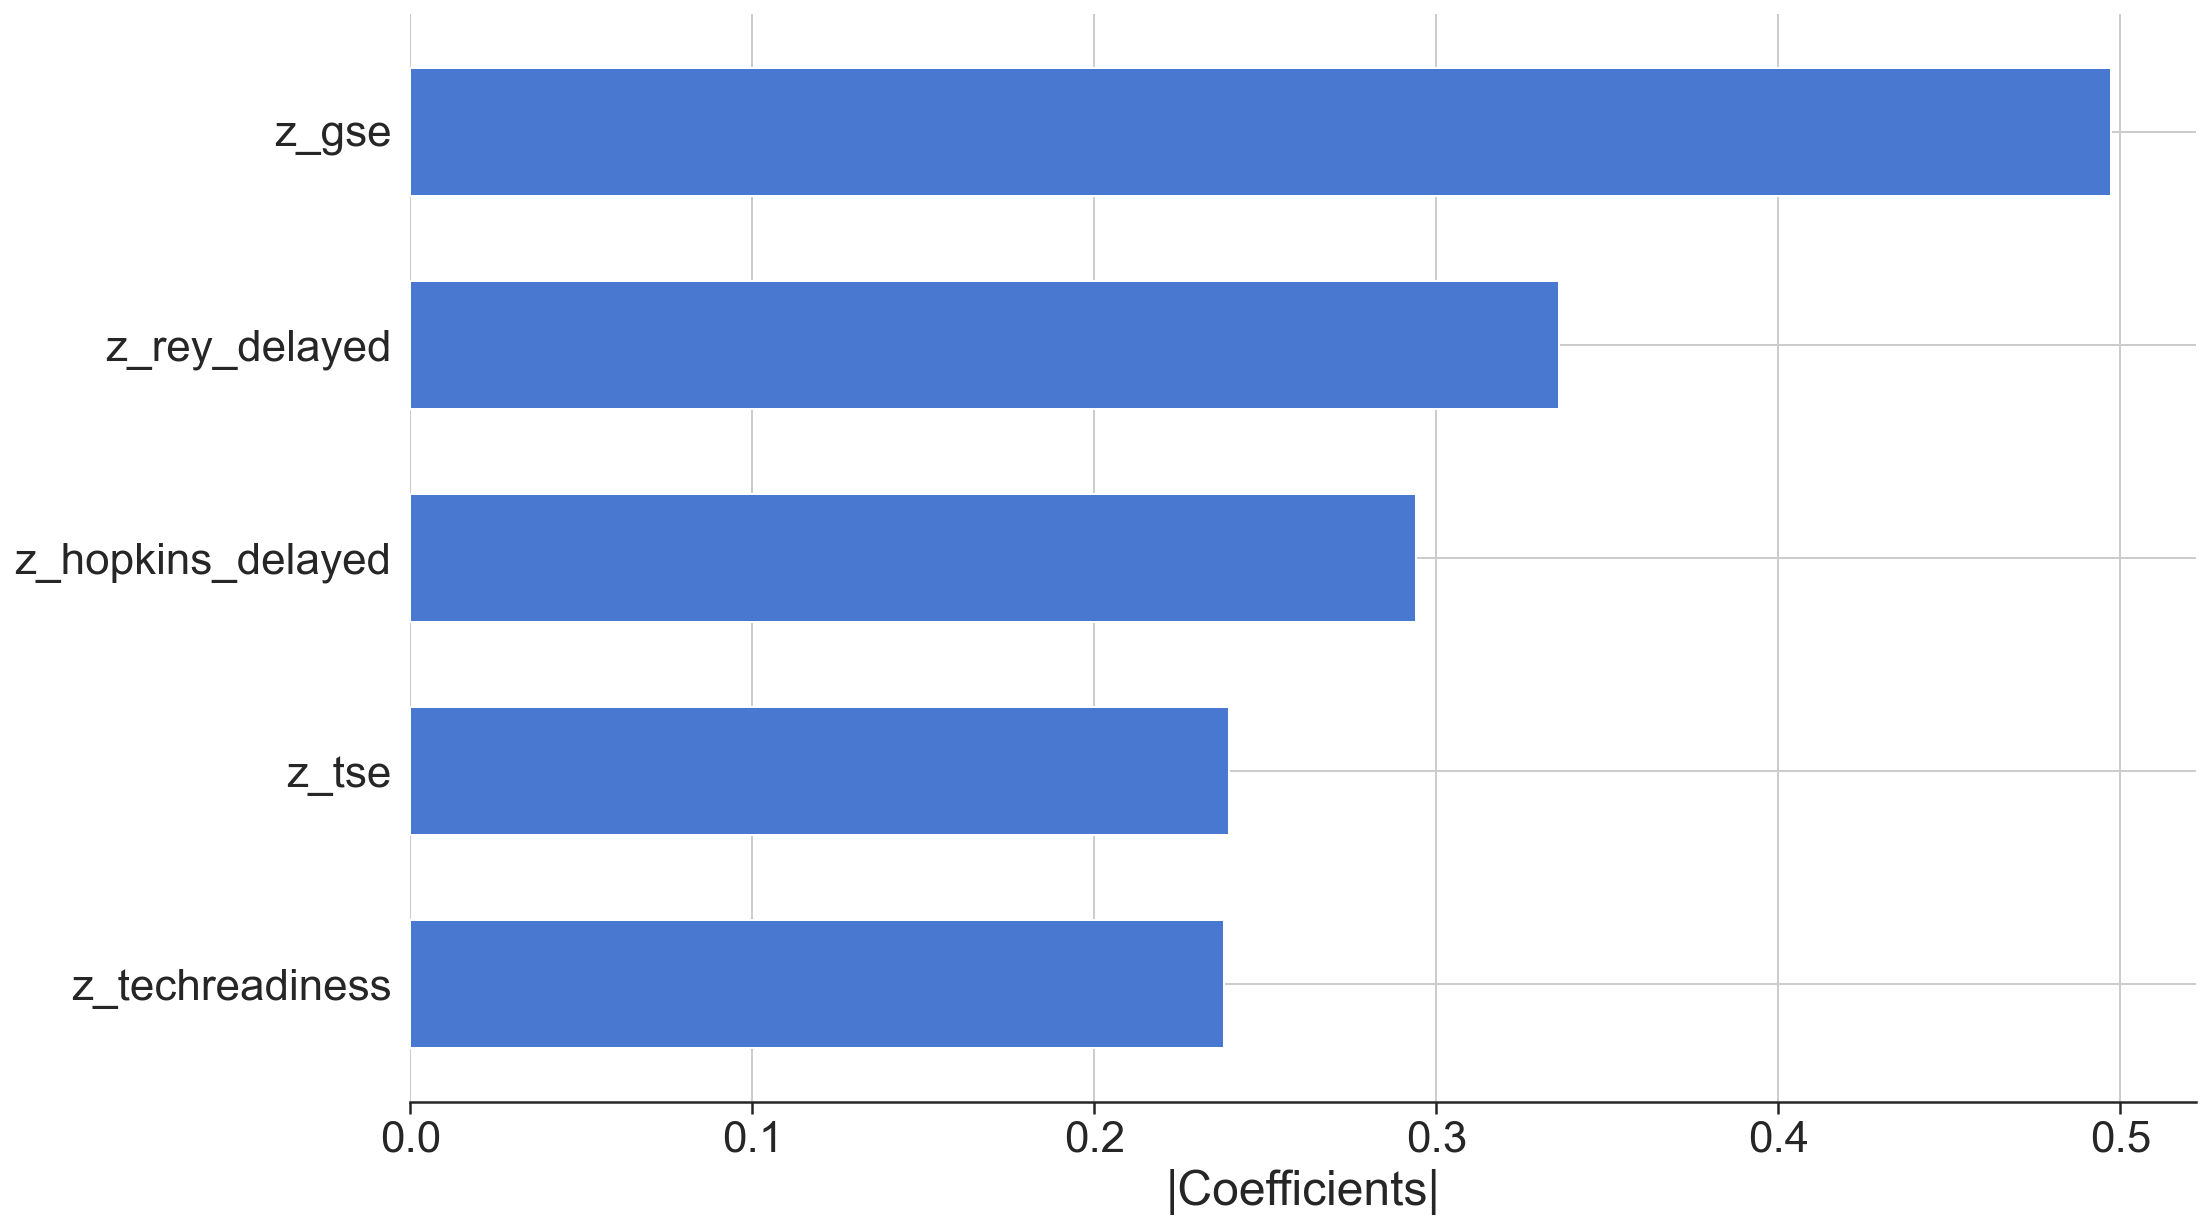

In [21]:
model = LogisticRegression(random_state=42)
model.fit(X_zscore, y_zscore)
explainer = shap.LinearExplainer(model, X_zscore, feature_dependence="independent")
shap_values = explainer.shap_values(X_zscore)

df = pd.DataFrame(data={'variables':list(X_zscore.columns), 'coefs':abs(model.coef_).tolist()[0]})

ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

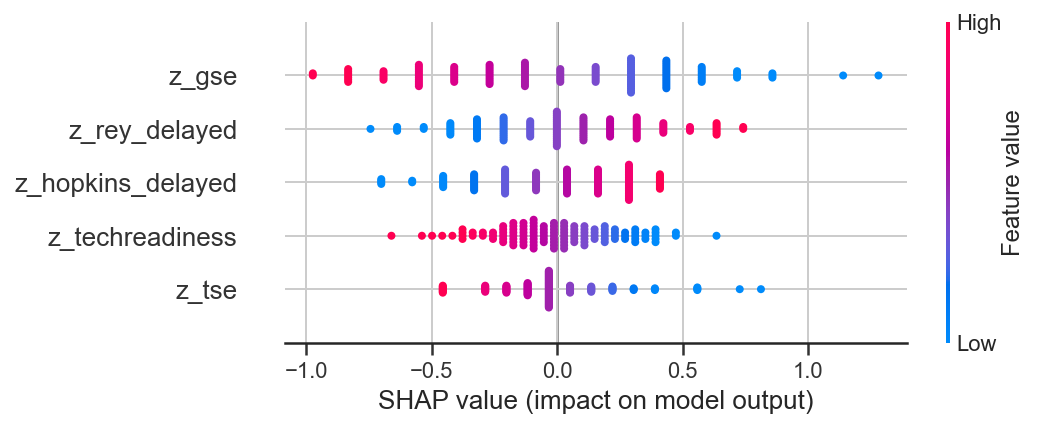

In [22]:
shap.summary_plot(shap_values, X_zscore, show=False)

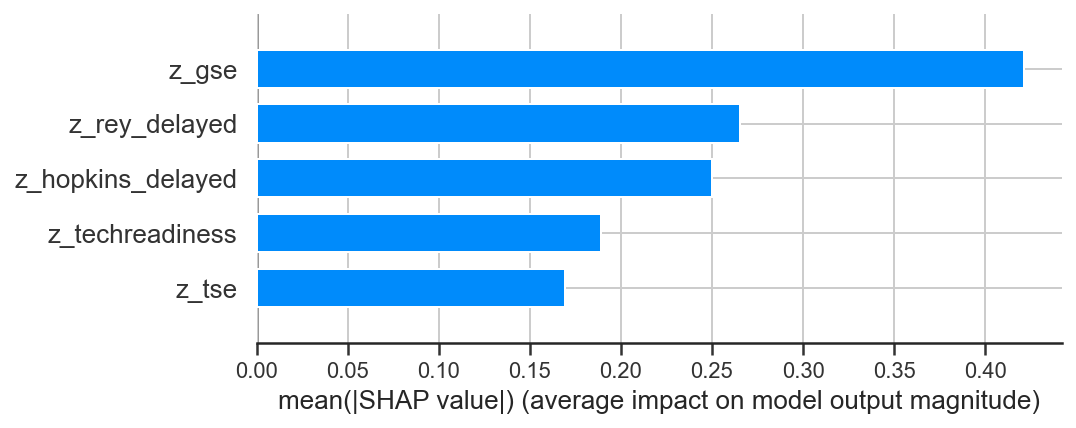

In [23]:
shap.summary_plot(shap_values, X_zscore, plot_type='bar', show=False)

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


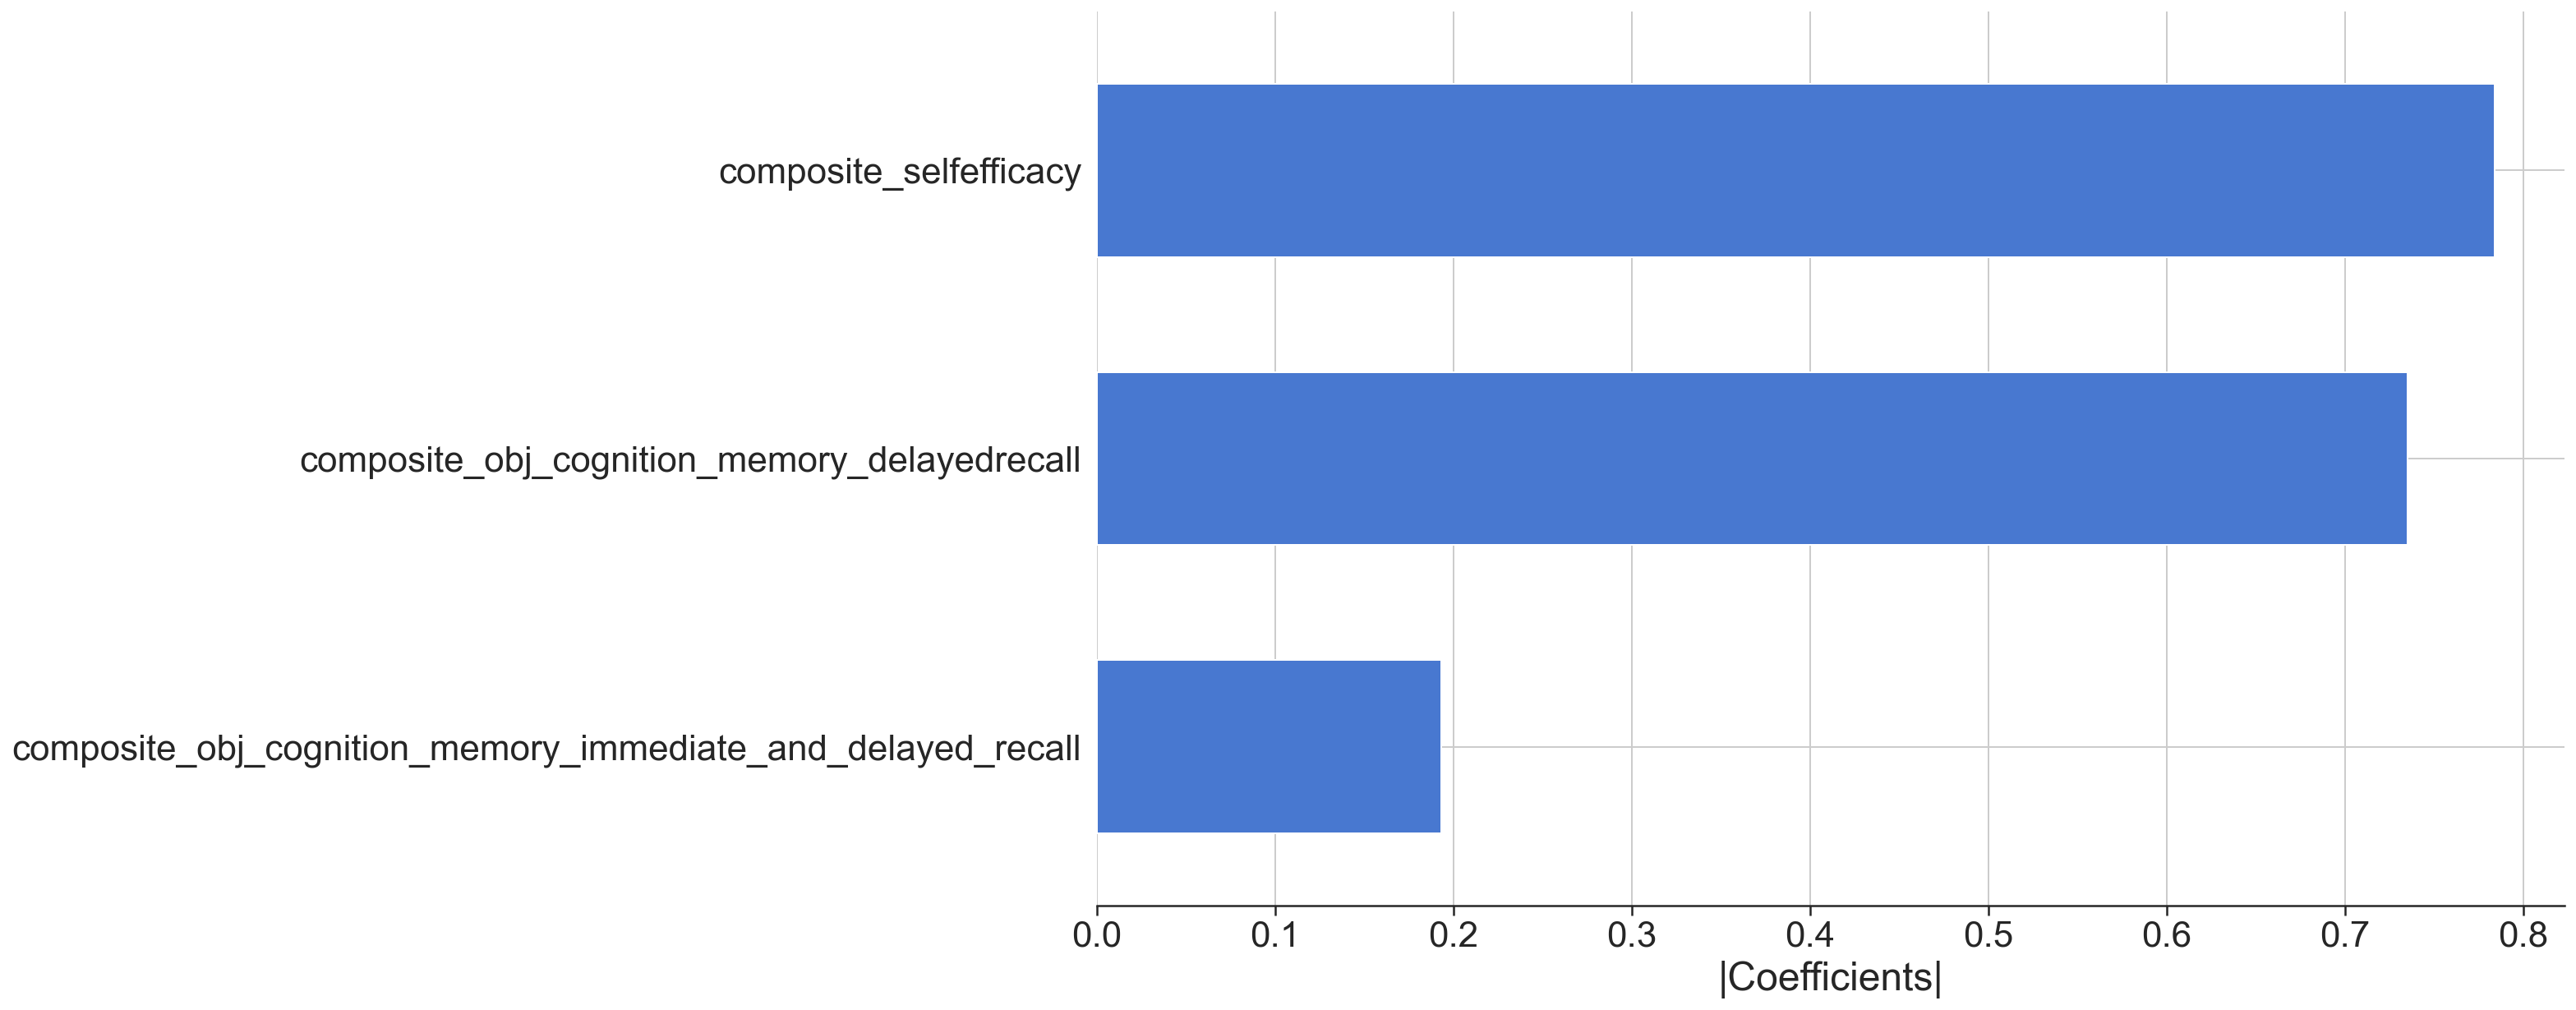

In [24]:
model = LogisticRegression(random_state=42)
model.fit(X_compscore, y_compscore)
explainer = shap.LinearExplainer(model, X_compscore, feature_dependence="independent")
shap_values = explainer.shap_values(X_compscore)

df = pd.DataFrame(data={'variables':list(X_compscore.columns), 'coefs':abs(model.coef_).tolist()[0]})

ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

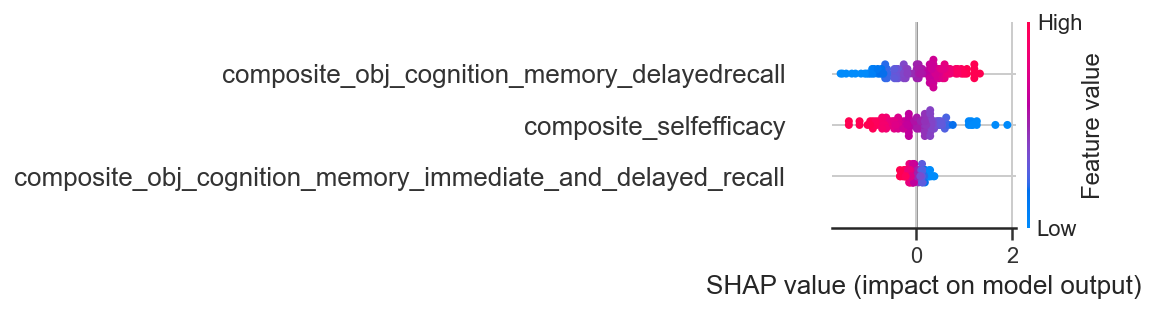

In [25]:
shap.summary_plot(shap_values, X_compscore, show=False)

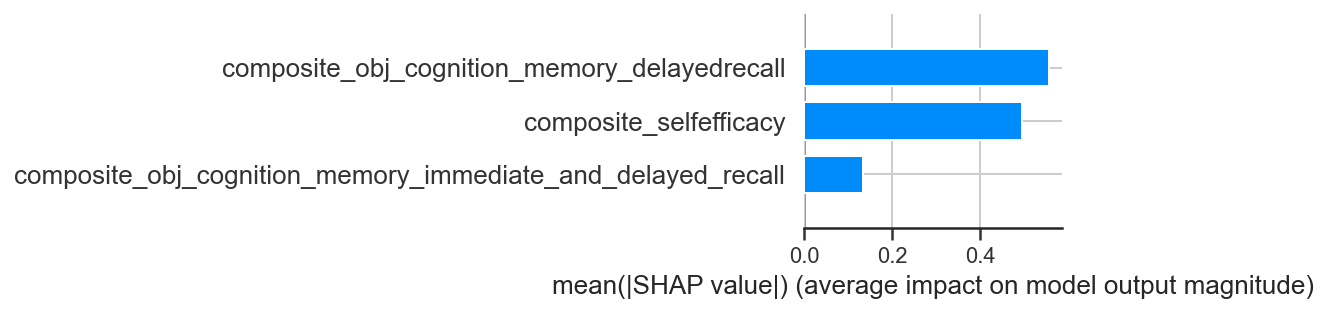

In [26]:
shap.summary_plot(shap_values, X_compscore, plot_type='bar', show=False)

In [27]:
# Ridge Regreesion
eval_zscore = cross_validate(clf_ridge, df_v2[sel_num_cols[:i]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
eval_comp = cross_validate(clf_ridge, df_v2[sel_num_cols[i:]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
print_clf_metric(eval_zscore)
print_clf_metric(eval_comp)

Metric          Mean       Std
------------------------------
ACCU          0.6786    0.0602
P             0.6929    0.0846
R             0.6786    0.0602
F1            0.6766    0.0575
AUROC         0.7023    0.0881
AUPRC         0.6506    0.0716
Metric          Mean       Std
------------------------------
ACCU          0.6609    0.0753
P             0.6697    0.0772
R             0.6609    0.0753
F1            0.6582    0.0753
AUROC         0.7128    0.0934
AUPRC         0.6658    0.0884


In [28]:
# SVM
eval_zscore = cross_validate(clf_svc, df_v2[sel_num_cols[:i]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
eval_comp = cross_validate(clf_svc, df_v2[sel_num_cols[i:]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
print_clf_metric(eval_zscore)
print_clf_metric(eval_comp)

Metric          Mean       Std
------------------------------
ACCU          0.6438    0.0713
P             0.6593    0.0801
R             0.6438    0.0713
F1            0.6380    0.0711
AUROC         0.6814    0.0738
AUPRC         0.6634    0.0445
Metric          Mean       Std
------------------------------
ACCU          0.6178    0.0953
P             0.6258    0.1008
R             0.6178    0.0953
F1            0.6148    0.0954
AUROC         0.6552    0.1322
AUPRC         0.6593    0.1474


In [29]:
# Decision Tree
eval_zscore = cross_validate(clf_cart, df_v2[sel_num_cols[:i]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
eval_comp = cross_validate(clf_cart, df_v2[sel_num_cols[i:]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
print_clf_metric(eval_zscore)
print_clf_metric(eval_comp)

Metric          Mean       Std
------------------------------
ACCU          0.5181    0.1044
P             0.5216    0.1121
R             0.5181    0.1044
F1            0.5084    0.1089
AUROC         0.5212    0.1054
AUPRC         0.5133    0.0545
Metric          Mean       Std
------------------------------
ACCU          0.5678    0.0549
P             0.5784    0.0756
R             0.5678    0.0549
F1            0.5583    0.0510
AUROC         0.5659    0.0550
AUPRC         0.5376    0.0511


In [30]:
# Random Forest
eval_zscore = cross_validate(clf_rf, df_v2[sel_num_cols[:i]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
eval_comp = cross_validate(clf_rf, df_v2[sel_num_cols[i:]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
print_clf_metric(eval_zscore)
print_clf_metric(eval_comp)

Metric          Mean       Std
------------------------------
ACCU          0.6272    0.1157
P             0.6321    0.1184
R             0.6272    0.1157
F1            0.6239    0.1173
AUROC         0.6677    0.1430
AUPRC         0.6636    0.1184
Metric          Mean       Std
------------------------------
ACCU          0.5511    0.0707
P             0.5545    0.0729
R             0.5511    0.0707
F1            0.5476    0.0715
AUROC         0.6083    0.0781
AUPRC         0.6310    0.0758


#### Y=ful_adhr_cls

In [31]:
cls_type = 'ful_adhr_cls' 
df_nums = df_v2[v2_num_vars]
sel_num_cols = []
for col in df_nums.columns:
    correlation, p_value = pointbiserialr(df_v2[cls_type], df_nums[col])
    print(f"{col:<60}{correlation:.4f} (p={p_value:.4f})")
    if p_value <= 0.1:
        sel_num_cols.append(col)

bg_age                                                      -0.0537 (p=0.5637)
z_ufov3                                                     0.0586 (p=0.5287)
z_digitsymb                                                 0.0479 (p=0.6063)
z_ravens                                                    0.0411 (p=0.6589)
z_lettersets                                                0.0495 (p=0.5945)
z_hopkins_immediate                                         0.0748 (p=0.4211)
z_hopkins_delayed                                           0.1904 (p=0.0389)
z_rey_immediate                                             0.1740 (p=0.0595)
z_rey_delayed                                               0.2263 (p=0.0137)
z_iadl                                                      0.0075 (p=0.9358)
z_indp                                                      -0.0279 (p=0.7640)
z_nict                                                      -0.1007 (p=0.2781)
z_mseq                                                      0

In [32]:
sel_num_cols

['z_hopkins_delayed',
 'z_rey_immediate',
 'z_rey_delayed',
 'z_gse',
 'z_tse',
 'z_techreadiness',
 'composite_selfefficacy',
 'composite_obj_cognition_memory_delayedrecall',
 'composite_obj_cognition_memory_immediate_and_delayed_recall']

In [33]:
v2_cat_vars = ['condition', 'bg_gender']
df_cats = df_v2[v2_cat_vars]
sel_cat_cols = []

def cramers_v(chi2, n, rows, cols):
    """Calculate Cramér's V statistic for a given Chi-square statistic, total sample size,
    and dimensions of the contingency table.

    Args:
        chi2 (float): The Chi-square statistic from the test of independence.
        n (int): Total sample size or total number of observations.
        rows (int): Number of rows in the contingency table (number of categories in the first variable).
        cols (int): Number of columns in the contingency table (number of categories in the second variable).

    Returns:
        float: Cramér's V statistic, a measure of association between two nominal variables.
    """
    # Correct Chi-square value for the bias:
    phi2 = chi2 / n
    # Apply the correction for bias in small samples if necessary:
    phi2_corrected = max(0, phi2 - ((cols - 1) * (rows - 1)) / (n - 1))
    r_corrected = rows - ((rows - 1) ** 2) / (n - 1)
    c_corrected = cols - ((cols - 1) ** 2) / (n - 1)
    # Calculate Cramér's V:
    cramers_v = np.sqrt(phi2_corrected / min(r_corrected - 1, c_corrected - 1))
    return cramers_v


for col in df_cats.columns:
    contingency_table = pd.crosstab(df_cats[col], df_v2[cls_type])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()  # Total sample size
    rows, cols = contingency_table.shape
    cramer_v = cramers_v(chi2, n, rows, cols)
    print(f"{col:<60} Cramér's V: {cramer_v:.4f} (p={p_value:.4f})")
    if p_value <= 0.1:
        sel_cat_cols.append(col)


condition                                                    Cramér's V: 0.1725 (p=0.0640)
bg_gender                                                    Cramér's V: 0.0000 (p=0.5635)


In [34]:
sel_cat_cols

['condition']

In [35]:
i=6
X_zscore = df_v2[sel_num_cols[:i]+sel_cat_cols]
y_zscore = df_v2[cls_type]
df = df_v2[sel_num_cols[:i]+sel_cat_cols+[cls_type]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   z_hopkins_delayed  118 non-null    float64
 1   z_rey_immediate    118 non-null    float64
 2   z_rey_delayed      118 non-null    float64
 3   z_gse              118 non-null    float64
 4   z_tse              118 non-null    float64
 5   z_techreadiness    118 non-null    float64
 6   condition          118 non-null    int64  
 7   ful_adhr_cls       118 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 7.5 KB


In [36]:
X_compscore = df_v2[sel_num_cols[i:]+sel_cat_cols]
y_compscore = df_v2[cls_type]
df_comp = df_v2[sel_num_cols[i:]+sel_cat_cols+[cls_type]]
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 5 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   composite_selfefficacy                                       118 non-null    float64
 1   composite_obj_cognition_memory_delayedrecall                 118 non-null    float64
 2   composite_obj_cognition_memory_immediate_and_delayed_recall  118 non-null    float64
 3   condition                                                    118 non-null    int64  
 4   ful_adhr_cls                                                 118 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 4.7 KB


In [37]:
# logistic Regression
i = 6
eval_zscore = cross_validate(clf_lr, df_v2[sel_num_cols[:i]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
eval_comp = cross_validate(clf_lr, df_v2[sel_num_cols[i:]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
print_clf_metric(eval_zscore)
print_clf_metric(eval_comp)

Metric          Mean       Std
------------------------------
ACCU          0.6264    0.0845
P             0.6331    0.0815
R             0.6264    0.0845
F1            0.6211    0.0848
AUROC         0.6498    0.1137
AUPRC         0.6313    0.1008
Metric          Mean       Std
------------------------------
ACCU          0.6181    0.0988
P             0.6255    0.1041
R             0.6181    0.0988
F1            0.6116    0.0992
AUROC         0.6704    0.1216
AUPRC         0.6429    0.1168


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


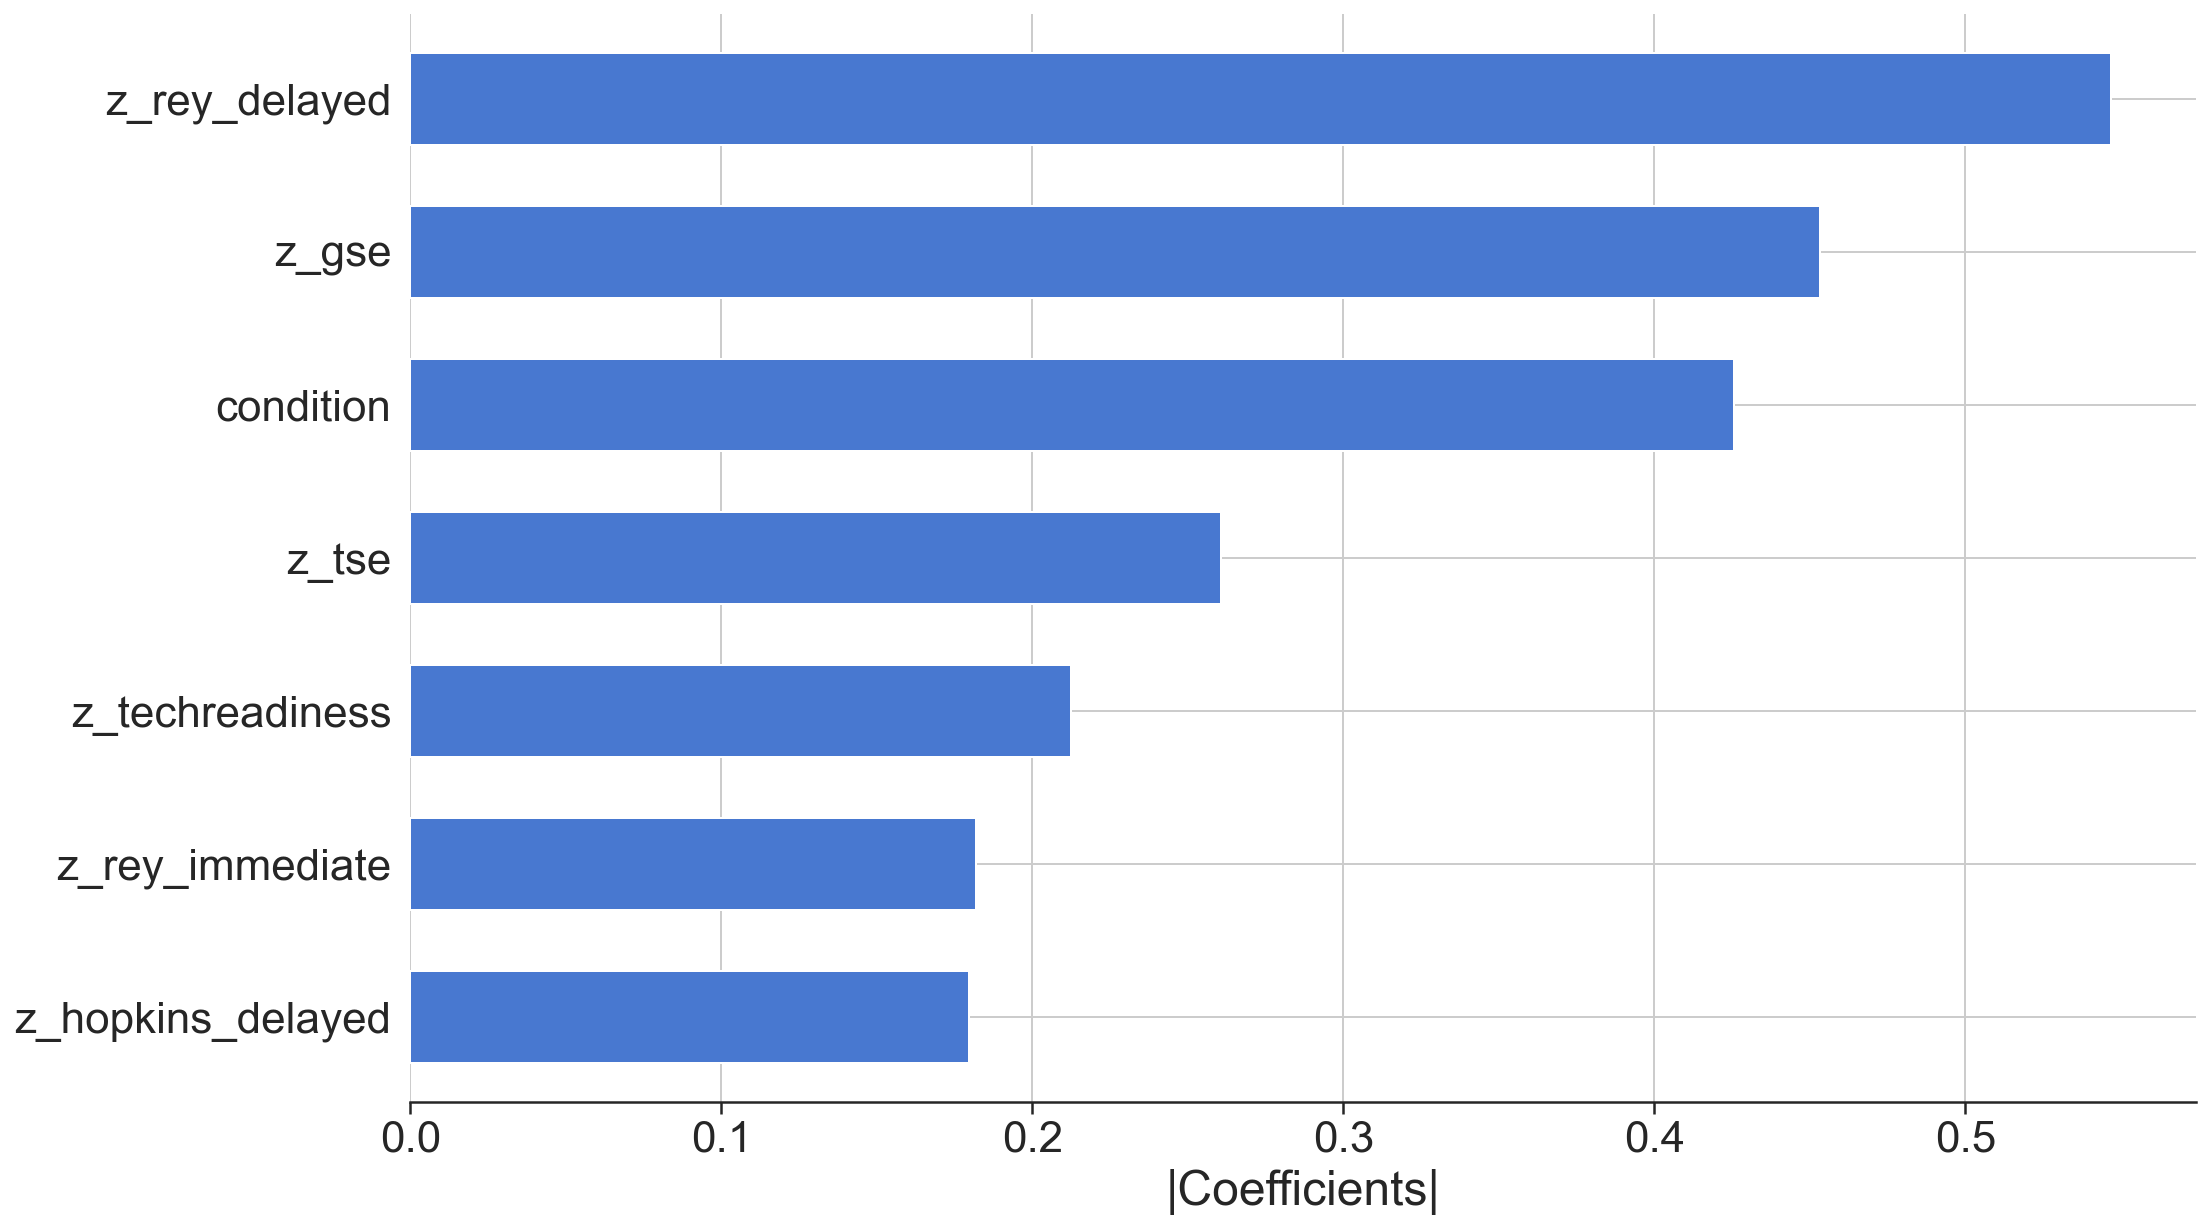

In [38]:
model = LogisticRegression(random_state=42)
model.fit(X_zscore, y_zscore)
explainer = shap.LinearExplainer(model, X_zscore, feature_dependence="independent")
shap_values = explainer.shap_values(X_zscore)

df = pd.DataFrame(data={'variables':list(X_zscore.columns), 'coefs':abs(model.coef_).tolist()[0]})

ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

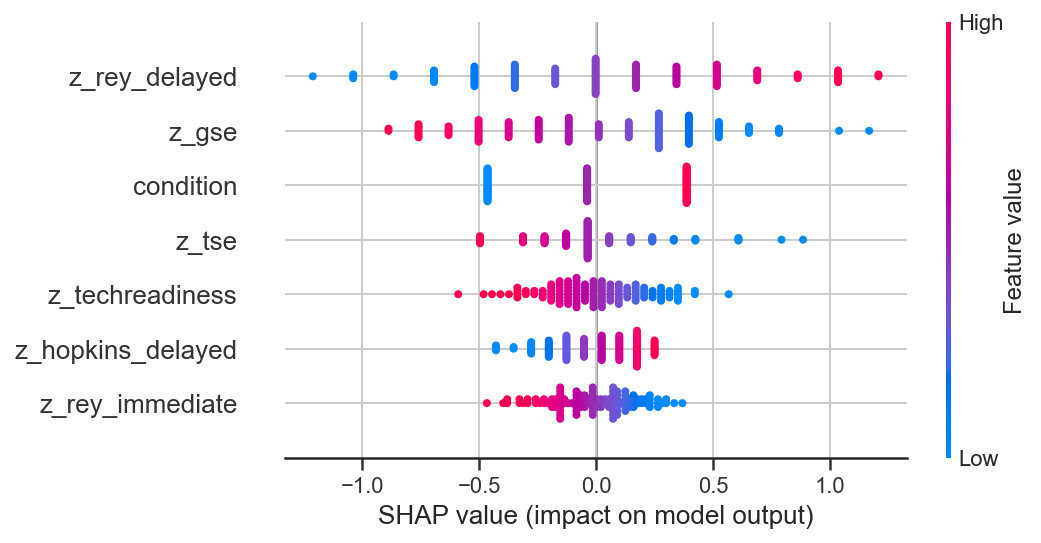

In [39]:
shap.summary_plot(shap_values, X_zscore, show=False)

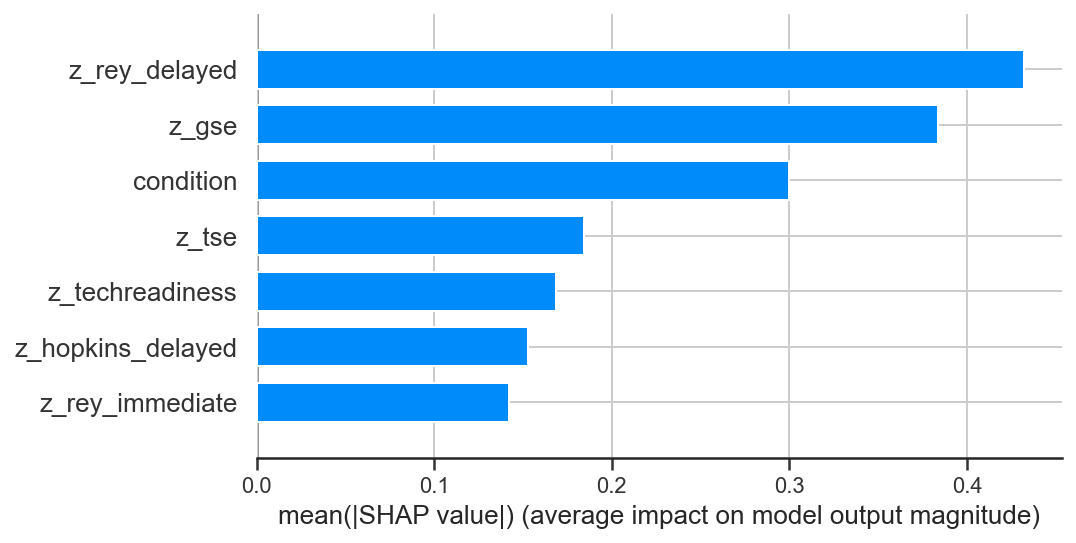

In [40]:
shap.summary_plot(shap_values, X_zscore, plot_type='bar', show=False)

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


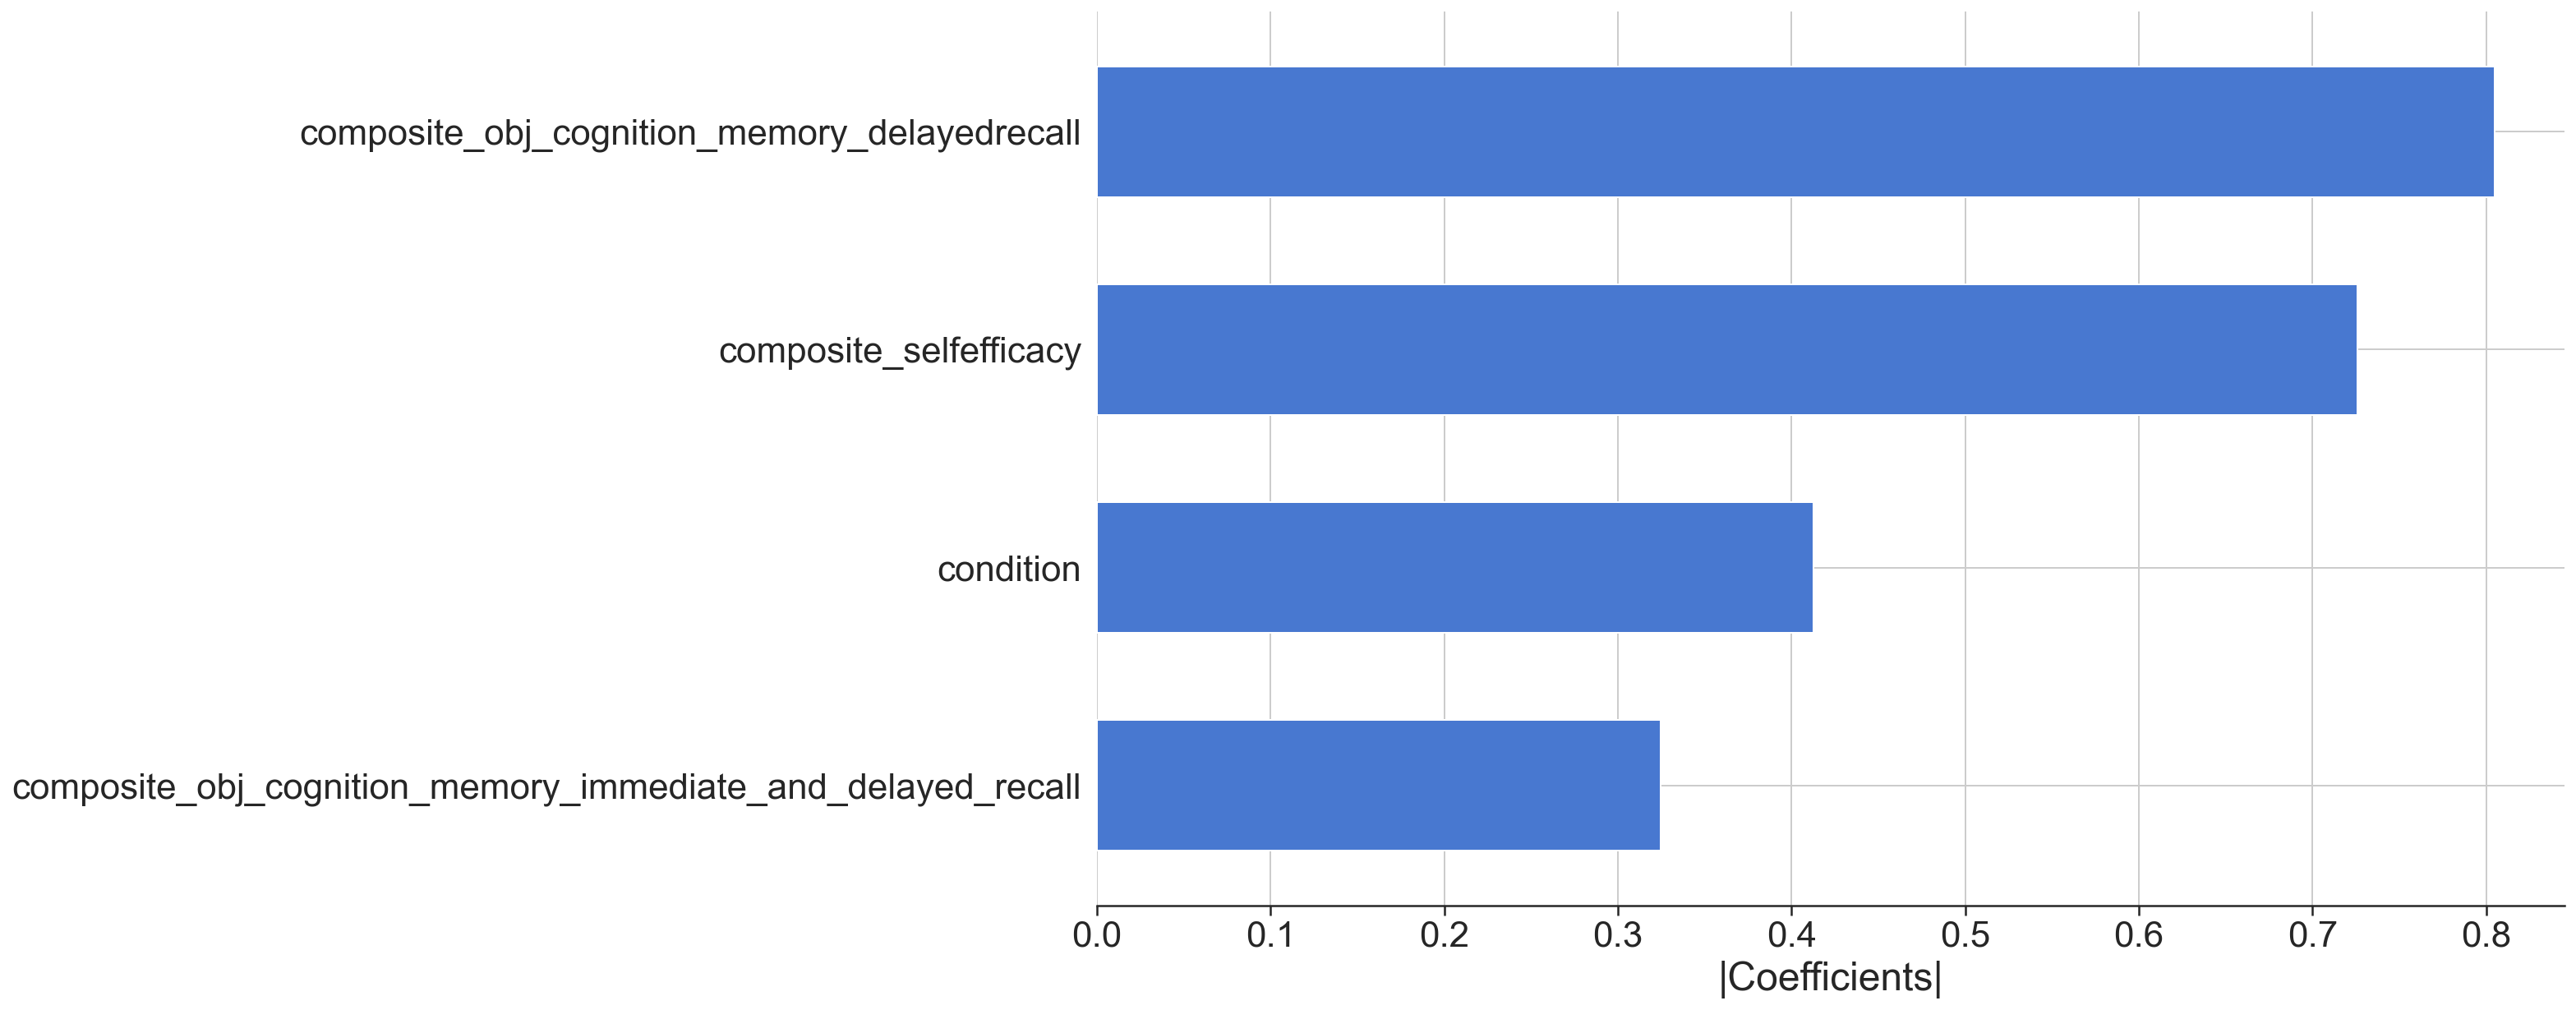

In [41]:
model = LogisticRegression(random_state=42)
model.fit(X_compscore, y_compscore)
explainer = shap.LinearExplainer(model, X_compscore, feature_dependence="independent")
shap_values = explainer.shap_values(X_compscore)

df = pd.DataFrame(data={'variables':list(X_compscore.columns), 'coefs':abs(model.coef_).tolist()[0]})

ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

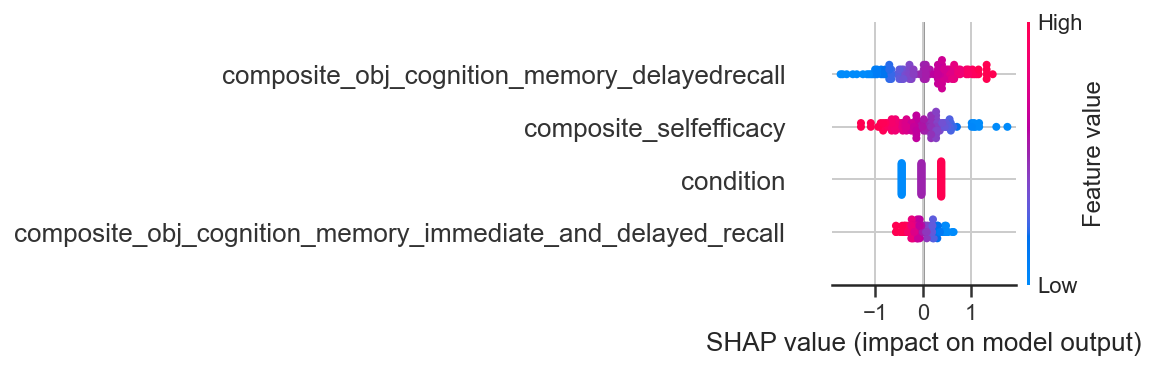

In [42]:
shap.summary_plot(shap_values, X_compscore, show=False)

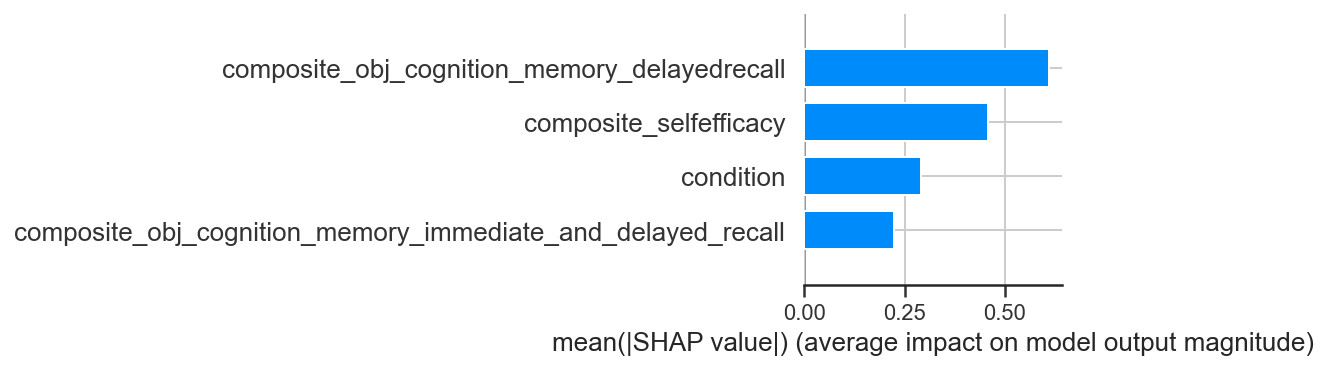

In [43]:
shap.summary_plot(shap_values, X_compscore, plot_type='bar', show=False)

In [44]:
# Ridge Regression
i = 6
eval_zscore = cross_validate(clf_ridge, df_v2[sel_num_cols[:i]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
eval_comp = cross_validate(clf_ridge, df_v2[sel_num_cols[i:]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
print_clf_metric(eval_zscore)
print_clf_metric(eval_comp)

Metric          Mean       Std
------------------------------
ACCU          0.6261    0.0910
P             0.6343    0.0884
R             0.6261    0.0910
F1            0.6187    0.0940
AUROC         0.6497    0.1147
AUPRC         0.6430    0.0902
Metric          Mean       Std
------------------------------
ACCU          0.6094    0.0896
P             0.6180    0.0965
R             0.6094    0.0896
F1            0.6033    0.0900
AUROC         0.6818    0.1222
AUPRC         0.6616    0.1230


In [45]:
# SVM
i = 6
eval_zscore = cross_validate(clf_svc, df_v2[sel_num_cols[:i]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
eval_comp = cross_validate(clf_svc, df_v2[sel_num_cols[i:]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
print_clf_metric(eval_zscore)
print_clf_metric(eval_comp)

Metric          Mean       Std
------------------------------
ACCU          0.5583    0.0748
P             0.5627    0.0767
R             0.5583    0.0748
F1            0.5531    0.0771
AUROC         0.5934    0.1289
AUPRC         0.5797    0.1102
Metric          Mean       Std
------------------------------
ACCU          0.5500    0.1082
P             0.5609    0.1220
R             0.5500    0.1082
F1            0.5473    0.1067
AUROC         0.6097    0.1027
AUPRC         0.5996    0.1010


In [46]:
# Decision Tree
i = 6
eval_zscore = cross_validate(clf_cart, df_v2[sel_num_cols[:i]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
eval_comp = cross_validate(clf_cart, df_v2[sel_num_cols[i:]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
print_clf_metric(eval_zscore)
print_clf_metric(eval_comp)

Metric          Mean       Std
------------------------------
ACCU          0.5101    0.1303
P             0.5103    0.1327
R             0.5101    0.1303
F1            0.5051    0.1307
AUROC         0.5076    0.1313
AUPRC         0.4866    0.0863
Metric          Mean       Std
------------------------------
ACCU          0.4920    0.0957
P             0.4856    0.1122
R             0.4920    0.0957
F1            0.4850    0.1054
AUROC         0.4888    0.1024
AUPRC         0.4774    0.0393


In [47]:
# Random Forest
i = 6
eval_zscore = cross_validate(clf_rf, df_v2[sel_num_cols[:i]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
eval_comp = cross_validate(clf_rf, df_v2[sel_num_cols[i:]+sel_cat_cols], df_v2[cls_type], scoring=clf_scoring, cv=5)
print_clf_metric(eval_zscore)
print_clf_metric(eval_comp)

Metric          Mean       Std
------------------------------
ACCU          0.5841    0.1218
P             0.5858    0.1196
R             0.5841    0.1218
F1            0.5824    0.1215
AUROC         0.6272    0.1330
AUPRC         0.6139    0.0983
Metric          Mean       Std
------------------------------
ACCU          0.5594    0.0615
P             0.5664    0.0664
R             0.5594    0.0615
F1            0.5533    0.0562
AUROC         0.5582    0.0783
AUPRC         0.5411    0.0545


### Only Game Prformance Features

In [48]:
game=df_v2[['SR_num_sessions','SR_pct','SR_Abort_pct','SR_Defeat_pct','SR_Victory_pct', 'SR_Stalemate_pct',
            'SR_NotYetFinished_pct','SR_days_med','SR_max_level',
            'I_num_sessions','I_pct','I_Abort_pct','I_Defeat_pct','I_Victory_pct', 'I_Stalemate_pct',
            'I_NotYetFinished_pct','I_days_med','I_max_level',
            'RS_num_sessions','RS_pct','RS_Abort_pct','RS_Defeat_pct','RS_Victory_pct', 'RS_Stalemate_pct',
            'RS_NotYetFinished_pct','RS_days_med','RS_max_level',
            'AU_num_sessions','AU_pct','AU_Abort_pct','AU_Defeat_pct','AU_Victory_pct', 'AU_Stalemate_pct',
            'AU_NotYetFinished_pct','AU_days_med','AU_max_level',
            'PEU_num_sessions','PEU_pct','PEU_Abort_pct','PEU_Defeat_pct','PEU_Victory_pct','PEU_Stalemate_pct',
            'PEU_NotYetFinished_pct','PEU_days_med','PEU_max_level',
            'SD_num_sessions','SD_pct','SD_Abort_pct','SD_Defeat_pct','SD_Victory_pct', 'SD_Stalemate_pct',
            'SD_NotYetFinished_pct','SD_days_med','SD_max_level',
            'TJ_num_sessions','TJ_pct','TJ_Abort_pct','TJ_Defeat_pct','TJ_Victory_pct', 'TJ_Stalemate_pct',
            'TJ_NotYetFinished_pct','TJ_days_med','TJ_max_level']]
scaler = StandardScaler()
scaler.fit(game)
game_std = scaler.transform(game)
game_std_df = pd.DataFrame(game_std, columns=game.columns)
game_std_df.columns=[f"{col}_std" for col in game_std_df.columns]
print(game_std_df.shape)
game_std_df.head()

(118, 63)


SR_num_sessions_std  SR_pct_std  SR_Abort_pct_std  SR_Defeat_pct_std  \
0            -0.008950   -0.170780         -0.098128           0.615833   
1            -1.432439    0.461847         -0.633497          -0.378605   
2            -0.330383   -0.424337         -0.410427           0.568479   
3            -1.156925   -0.910122          0.615697          -0.710085   
4             1.460458    1.871345         -0.447050           1.031419   

   SR_Victory_pct_std  SR_Stalemate_pct_std  SR_NotYetFinished_pct_std  \
0           -0.134541             -0.681744                  -0.219850   
1            1.327333             -0.681744                  -0.219850   
2            0.219852             -0.681744                  -0.219850   
3            0.397049             -0.681744                  -0.219850   
4           -0.361988             -0.681744                   5.325427   

   SR_days_med_std  SR_max_level_std  I_num_sessions_std  ...  \
0        -1.023252          0.054822           -0.108861  ...   
1         1.419541          1.114664           -0.578698  ...   
2        -0.499797         -0.083872           -0.108861  ...   
3         1.419541          1.037102           -0.458740  ...   
4        -0.150826         -1.775500            0.440949  ...   

   SD_max_level_std  TJ_num_sessions_std  TJ_pct_std  TJ_Abort_pct_std  \
0          0.049977            -0.081569   -0.041876         -0.602624   
1          1.116305            -0.707593    0.307828         -0.882812   
2         -0.097355            -0.525003   -0.974451          1.386707   
3          1.035973            -0.551087   -0.328424          0.798313   
4         -1.759934            -0.707593   -1.469749          1.638876   

   TJ_Defeat_pct_std  TJ_Victory_pct_std  TJ_Stalemate_pct_std  \
0           0.504419           -0.008153              0.187578   
1          -1.099028            2.219727             -0.880015   
2          -1.099028           -0.332208             -0.079321   
3           1.306143            0.396916             -1.413812   
4          -1.099028            0.396916             -0.880015   

   TJ_NotYetFinished_pct_std  TJ_days_med_std  TJ_max_level_std  
0                  -0.185753         -1.03801          0.049053  
1                  -0.185753          1.36366          1.115453  
2                  -0.185753         -1.03801         -0.096240  
3                  -0.185753          1.36366          1.035211  
4                  -0.185753          1.36366         -1.756153  

[5 rows x 63 columns]

In [49]:
df_v2=pd.concat([df_v2,game_std_df], axis=1)
print(df_v2.shape)
df_v2.head()

(118, 198)


Unnamed: 0 experiment_tag  condition  bg_gender  bg_age   z_ufov3  \
0           0          11AAA         -1          2      67  1.275424   
1           1          11ART         -1          1      64 -0.529076   
2           2          12ADD         -1          2      73  0.898735   
3           3          12BBB         -1          2      71  0.673172   
4           4          13AHS         -1          1      77 -1.319672   

   z_digitsymb  z_ravens  z_lettersets  z_hopkins_immediate  ...  \
0    -0.280536  0.207616     -1.000675             0.570660  ...   
1    -0.723487 -0.558414     -1.000675            -0.077757  ...   
2    -0.634896  0.207616      1.037737             0.408556  ...   
3    -0.457716  0.207616      1.037737             0.084347  ...   
4     2.465761 -1.324444     -0.592993             0.084347  ...   

   SD_max_level_std  TJ_num_sessions_std  TJ_pct_std  TJ_Abort_pct_std  \
0          0.049977            -0.081569   -0.041876         -0.602624   
1          1.116305            -0.707593    0.307828         -0.882812   
2         -0.097355            -0.525003   -0.974451          1.386707   
3          1.035973            -0.551087   -0.328424          0.798313   
4         -1.759934            -0.707593   -1.469749          1.638876   

   TJ_Defeat_pct_std  TJ_Victory_pct_std  TJ_Stalemate_pct_std  \
0           0.504419           -0.008153              0.187578   
1          -1.099028            2.219727             -0.880015   
2          -1.099028           -0.332208             -0.079321   
3           1.306143            0.396916             -1.413812   
4          -1.099028            0.396916             -0.880015   

   TJ_NotYetFinished_pct_std  TJ_days_med_std  TJ_max_level_std  
0                  -0.185753         -1.03801          0.049053  
1                  -0.185753          1.36366          1.115453  
2                  -0.185753         -1.03801         -0.096240  
3                  -0.185753          1.36366          1.035211  
4                  -0.185753          1.36366         -1.756153  

[5 rows x 198 columns]

In [50]:
cls_type = 'min_adhr_cls' 
SR_game=['SR_num_sessions_std','SR_pct_std','SR_Abort_pct_std','SR_Defeat_pct_std','SR_Victory_pct_std',
         'SR_Stalemate_pct_std','SR_NotYetFinished_pct_std','SR_days_med_std','SR_max_level_std']
df_SR = df_v2[SR_game]

In [51]:
cls_type = 'min_adhr_cls' 
model = LogisticRegression(random_state=42)
model.fit(df_SR, df_v2[cls_type])
masker = shap.maskers.Independent(data=df_SR)
explainer = shap.LinearExplainer(model, masker)
shap_values = explainer.shap_values(df_SR)

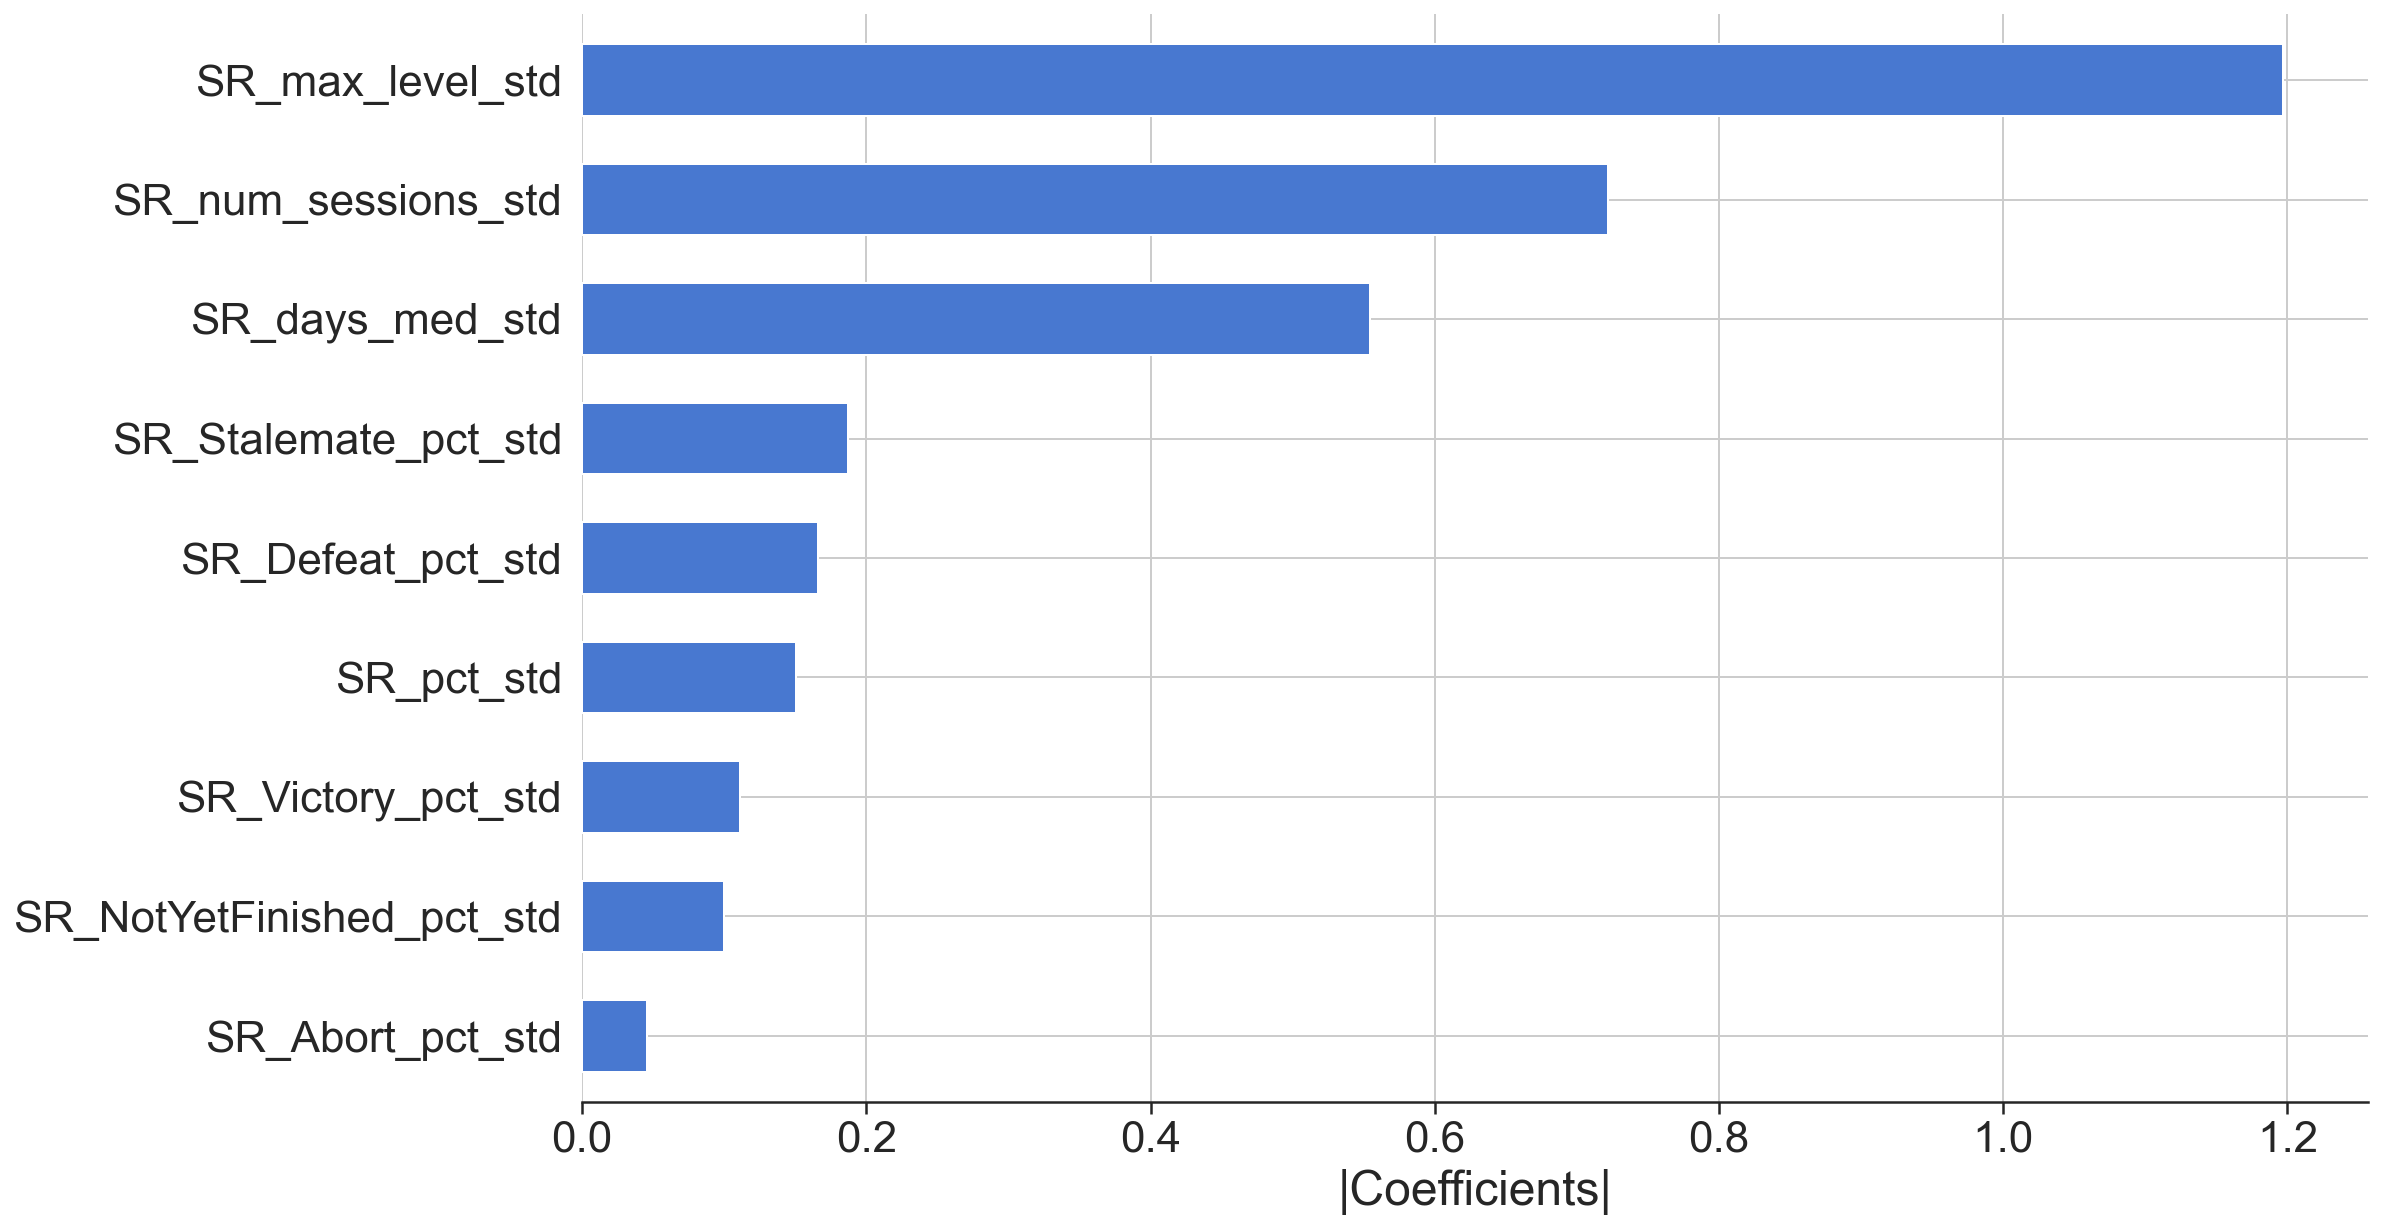

In [52]:
df = pd.DataFrame(data={'variables':list(df_SR.columns), 'coefs':abs(model.coef_).tolist()[0]})
ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

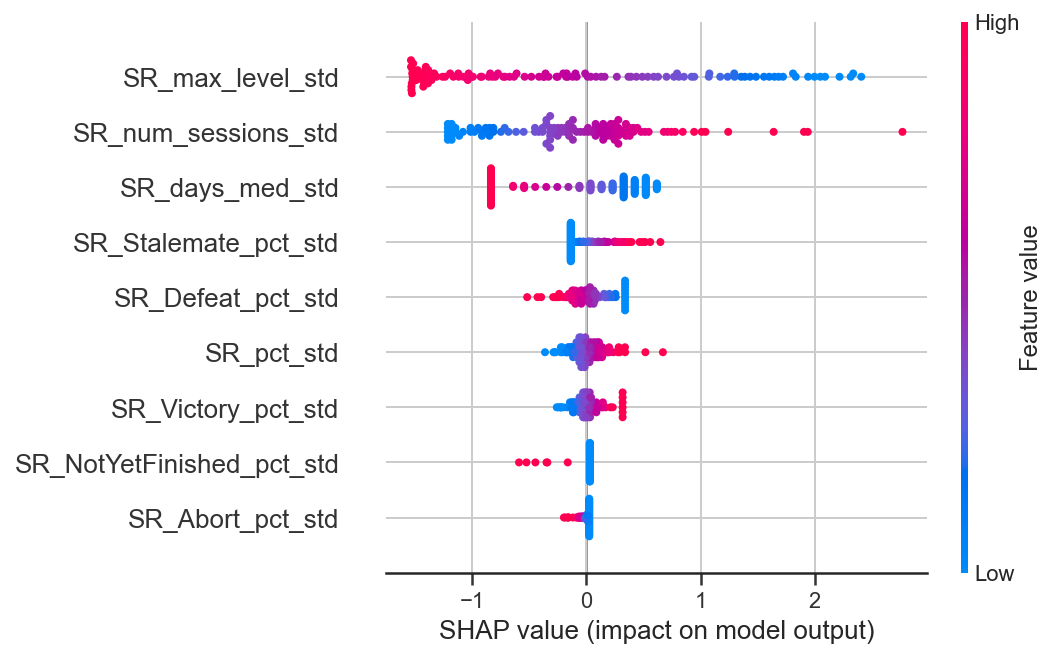

In [53]:
shap.summary_plot(shap_values, df_SR, show=False)

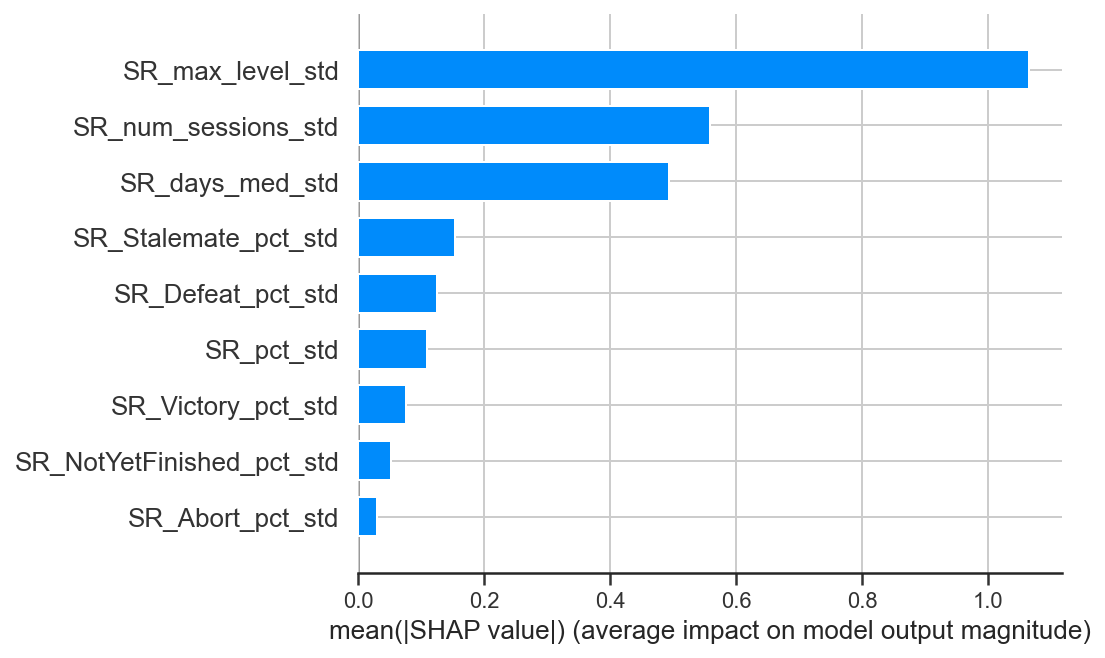

In [54]:
shap.summary_plot(shap_values, df_SR, plot_type='bar', show=False)

In [55]:
classifiers = {
    "Logistic Regression": clf_lr,
    "Ridge Regression": clf_ridge,
    "Support Vector Machine":clf_svc,
    "Decision Tree": clf_cart,
    "Random Forest": clf_rf
}

clf_scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'average_precision']

for name, clf in classifiers.items():
    print(f"Evaluating {name}:")
    
    eval_game = cross_validate(clf, df_SR, df_v2[cls_type], scoring=clf_scoring, cv=5)
    print(f"Results for {name} on first subset of columns which are related game performance:")
    print_clf_metric(eval_game)   
    print("--------------------------------------------------")

Evaluating Logistic Regression:
Results for Logistic Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7801    0.1029
P             0.7843    0.1023
R             0.7801    0.1029
F1            0.7790    0.1035
AUROC         0.8378    0.0986
AUPRC         0.8246    0.1247
--------------------------------------------------
Evaluating Ridge Regression:
Results for Ridge Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7714    0.1145
P             0.7761    0.1136
R             0.7714    0.1145
F1            0.7703    0.1149
AUROC         0.8348    0.1056
AUPRC         0.8224    0.1280
--------------------------------------------------
Evaluating Support Vector Machine:
Results for Support Vector Machine on first subset of columns which are related game performance:
Metric          Mean 

In [56]:
cls_type = 'min_adhr_cls' 
I_game=['I_num_sessions_std','I_pct_std','I_Abort_pct_std','I_Defeat_pct_std','I_Victory_pct_std',
         'I_Stalemate_pct_std','I_NotYetFinished_pct_std','I_days_med_std','I_max_level_std']
df_I = df_v2[I_game]

In [57]:
cls_type = 'min_adhr_cls' 
model = LogisticRegression(random_state=42)
model.fit(df_I, df_v2[cls_type])
masker = shap.maskers.Independent(data=df_I)
explainer = shap.LinearExplainer(model, masker)
shap_values = explainer.shap_values(df_I)

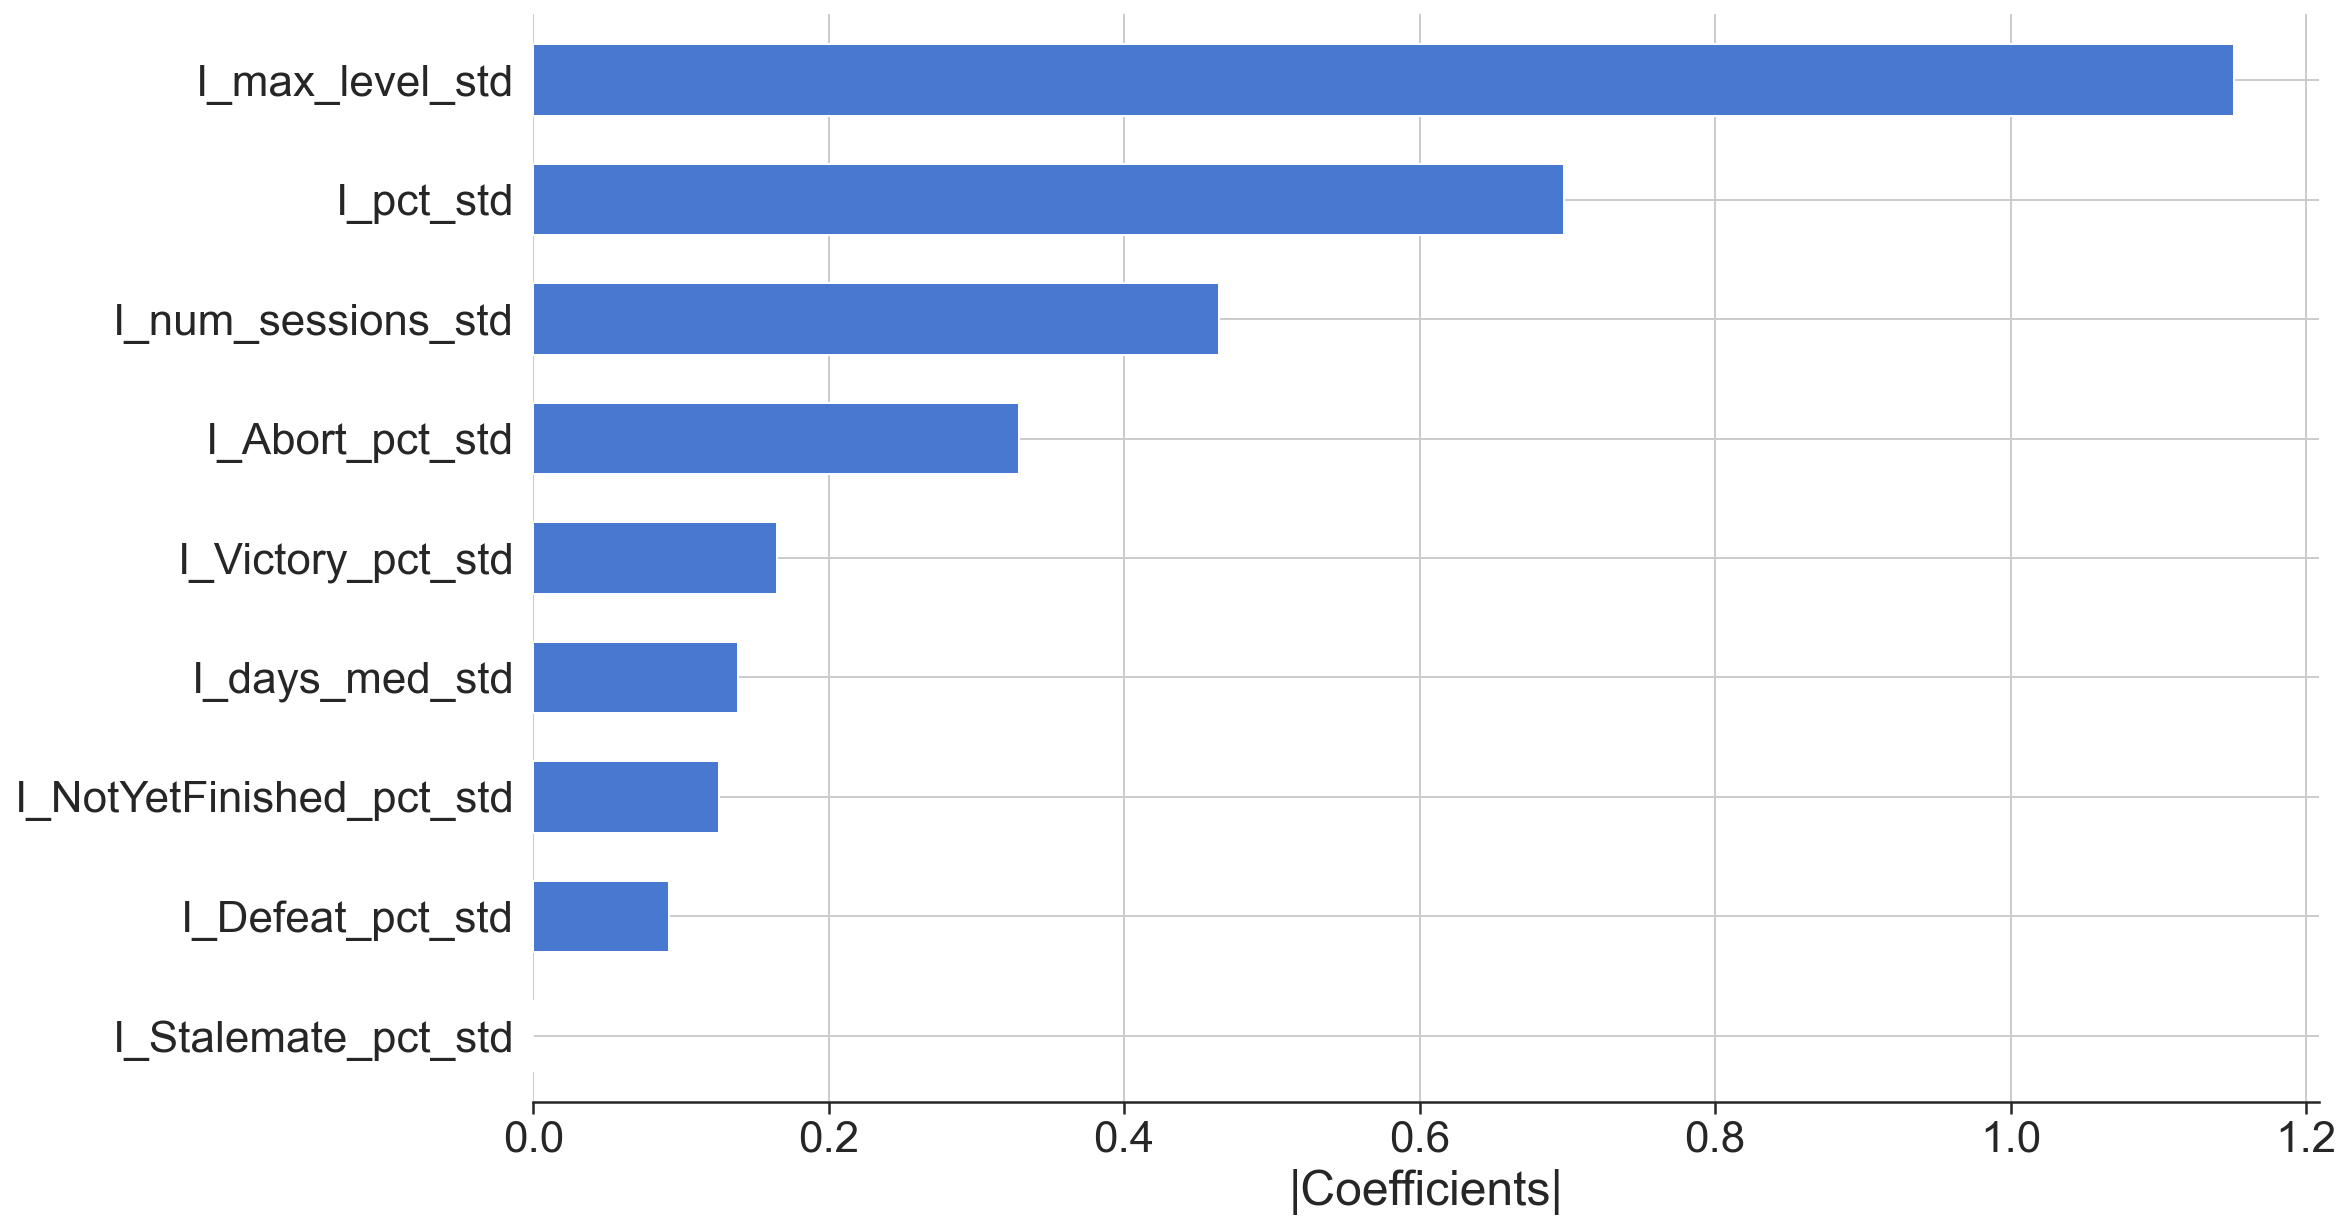

In [58]:
df = pd.DataFrame(data={'variables':list(df_I.columns), 'coefs':abs(model.coef_).tolist()[0]})
ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

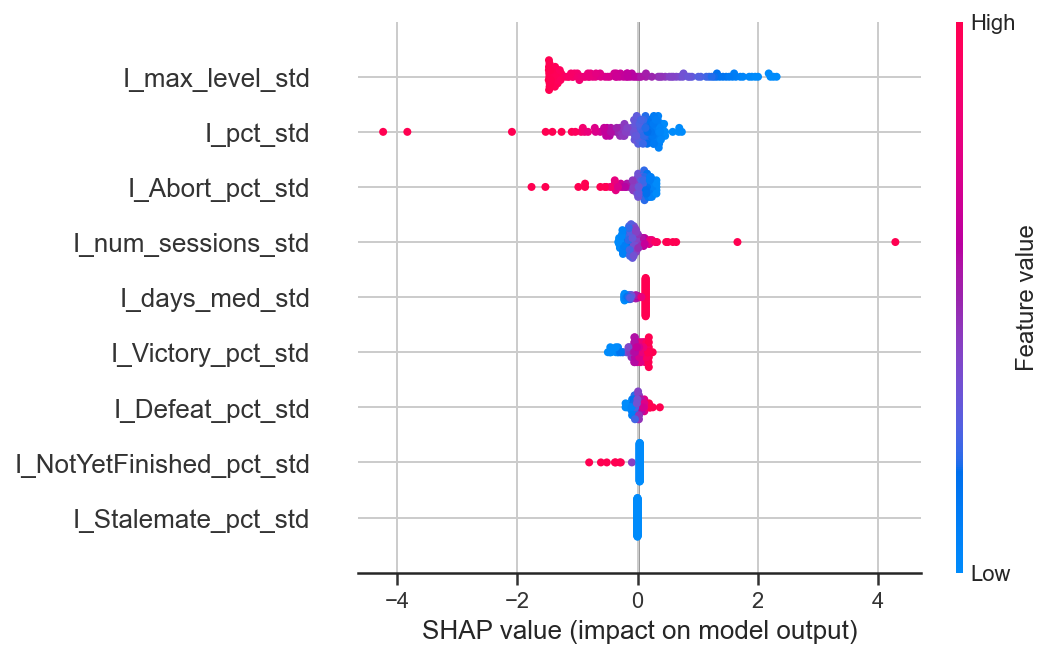

In [59]:
shap.summary_plot(shap_values, df_I, show=False)

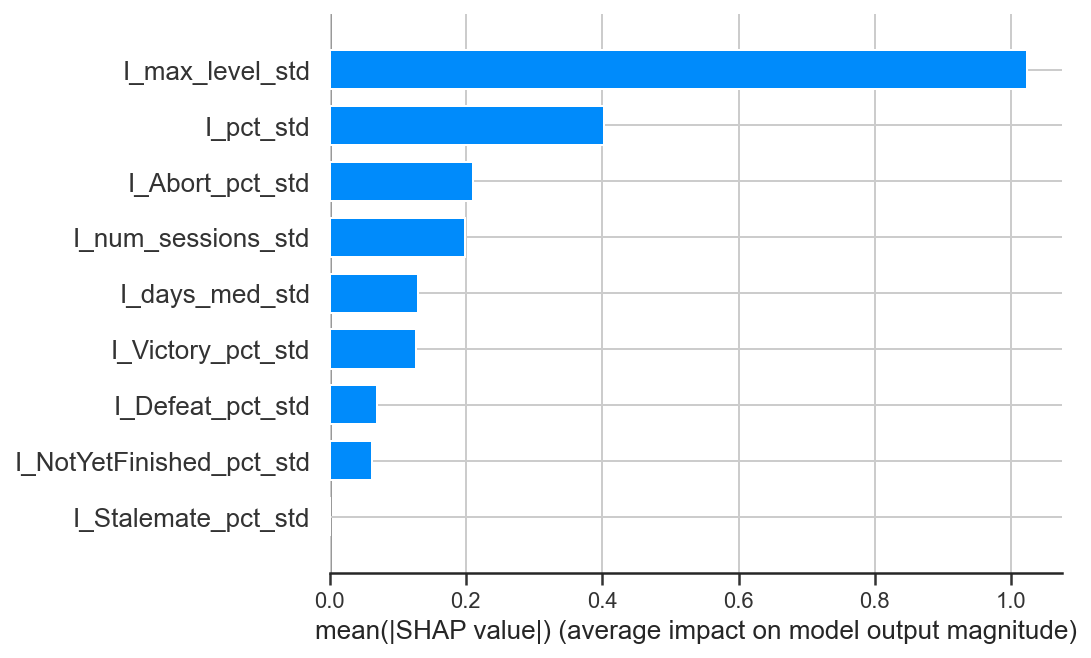

In [60]:
shap.summary_plot(shap_values, df_I, plot_type='bar', show=False)

In [62]:
classifiers = {
    "Logistic Regression": clf_lr,
    "Ridge Regression": clf_ridge,
    "Support Vector Machine":clf_svc,
    "Decision Tree": clf_cart,
    "Random Forest": clf_rf
}


clf_scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'average_precision']

for name, clf in classifiers.items():
    print(f"Evaluating {name}:")
    
    eval_game = cross_validate(clf, df_I, df_v2[cls_type], scoring=clf_scoring, cv=5)
    print(f"Results for {name} on first subset of columns which are related game performance:")
    print_clf_metric(eval_game)   
    print("--------------------------------------------------")

Evaluating Logistic Regression:
Results for Logistic Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7033    0.0613
P             0.7194    0.0818
R             0.7033    0.0613
F1            0.7004    0.0596
AUROC         0.7404    0.0795
AUPRC         0.7091    0.1125
--------------------------------------------------
Evaluating Ridge Regression:
Results for Ridge Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7120    0.0491
P             0.7282    0.0709
R             0.7120    0.0491
F1            0.7093    0.0469
AUROC         0.7571    0.0722
AUPRC         0.7231    0.0973
--------------------------------------------------
Evaluating Support Vector Machine:
Results for Support Vector Machine on first subset of columns which are related game performance:
Metric          Mean 

In [63]:
cls_type = 'min_adhr_cls' 
RS_game=['RS_num_sessions_std','RS_pct_std','RS_Abort_pct_std','RS_Defeat_pct_std','RS_Victory_pct_std', 'RS_Stalemate_pct_std',
        'RS_NotYetFinished_pct_std','RS_days_med_std','RS_max_level_std']
df_RS = df_v2[RS_game]

In [64]:
cls_type = 'min_adhr_cls' 
model = LogisticRegression(random_state=42)
model.fit(df_RS, df_v2[cls_type])
masker = shap.maskers.Independent(data=df_RS)
explainer = shap.LinearExplainer(model, masker)
shap_values = explainer.shap_values(df_RS)

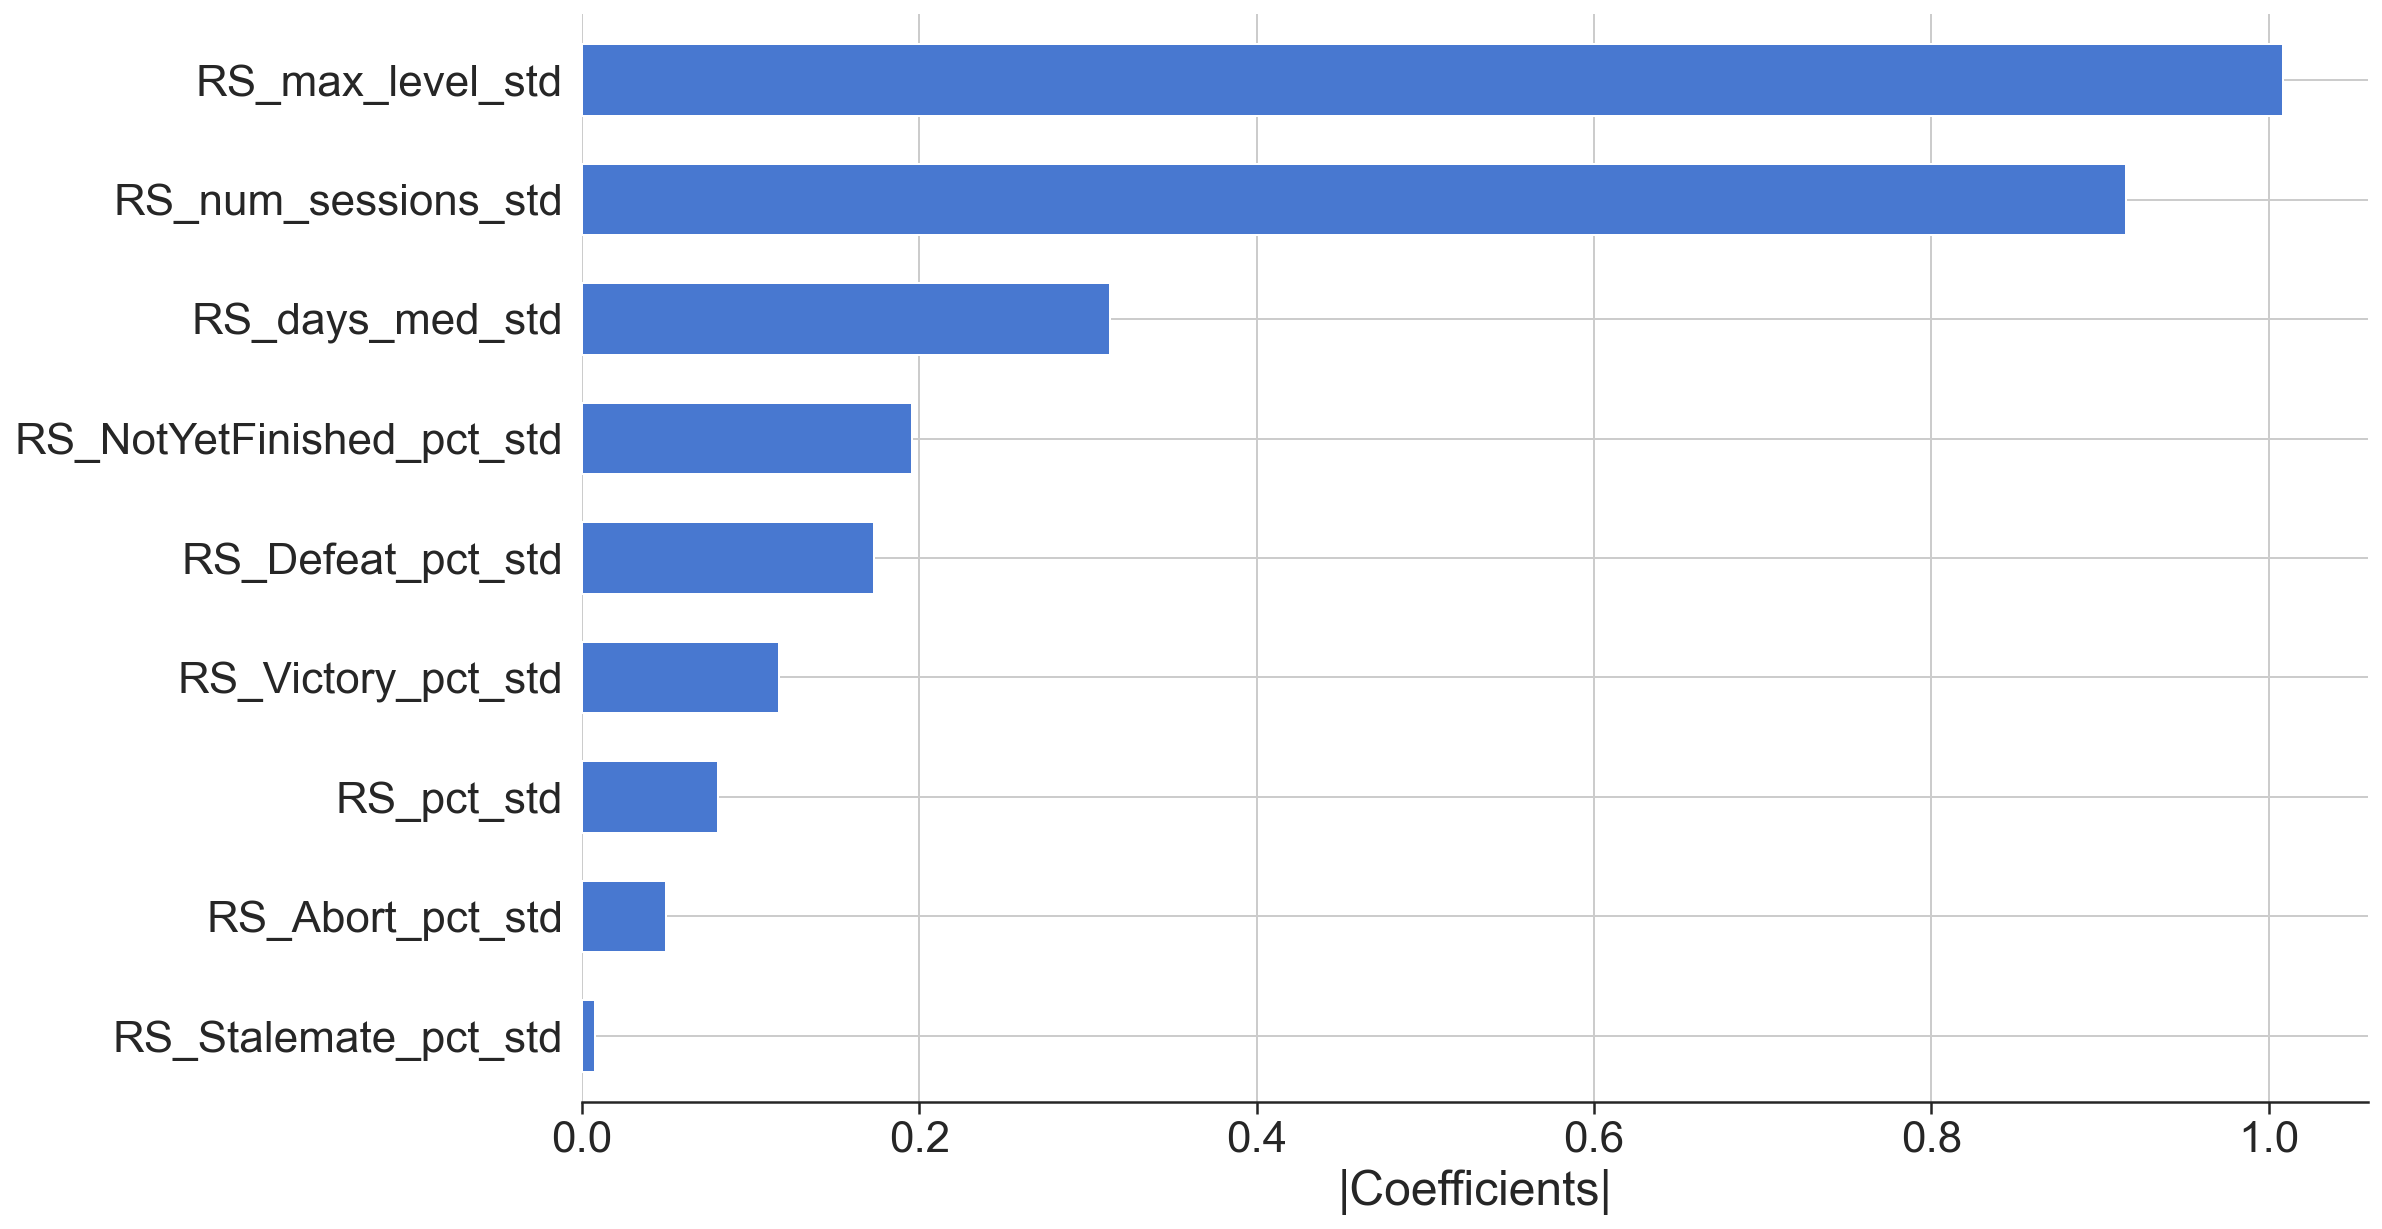

In [65]:
df = pd.DataFrame(data={'variables':list(df_RS.columns), 'coefs':abs(model.coef_).tolist()[0]})
ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

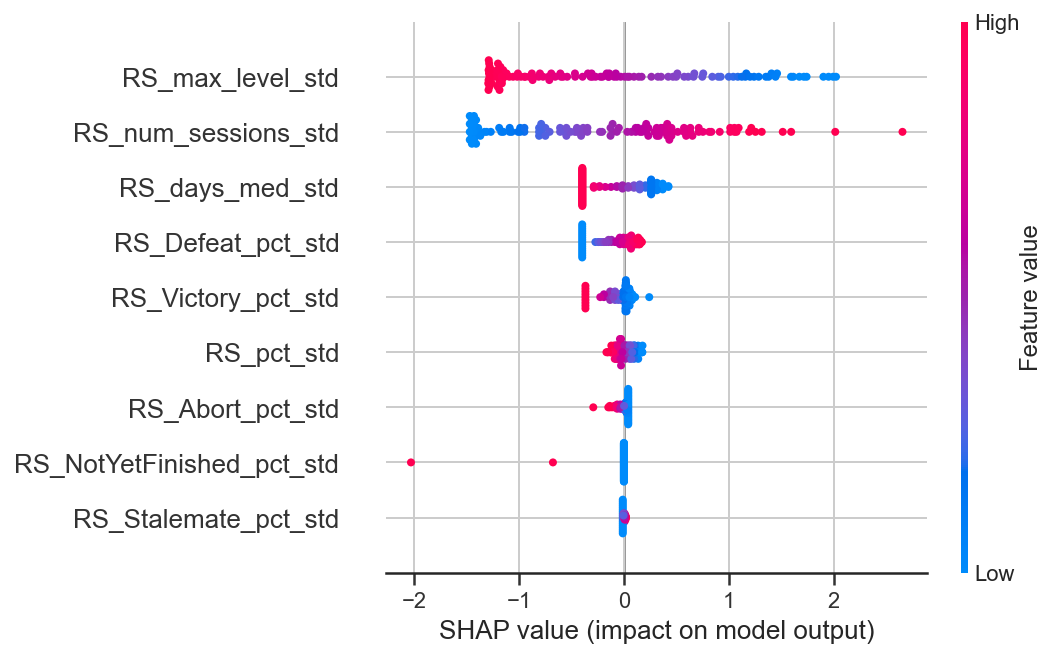

In [66]:
shap.summary_plot(shap_values, df_RS, show=False)

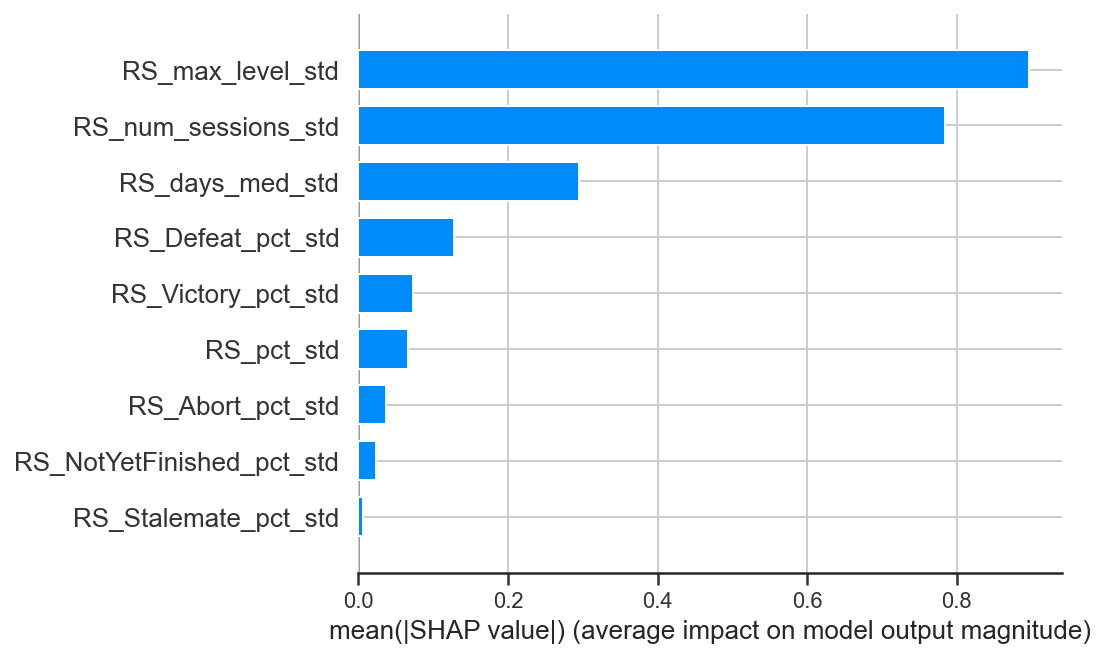

In [67]:
shap.summary_plot(shap_values, df_RS, plot_type='bar', show=False)

In [68]:
classifiers = {
    "Logistic Regression": clf_lr,
    "Ridge Regression": clf_ridge,
    "Support Vector Machine":clf_svc,
    "Decision Tree": clf_cart,
    "Random Forest": clf_rf
}


clf_scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'average_precision']

for name, clf in classifiers.items():
    print(f"Evaluating {name}:")
    
    eval_game = cross_validate(clf, df_RS, df_v2[cls_type], scoring=clf_scoring, cv=5)
    print(f"Results for {name} on first subset of columns which are related game performance:")
    print_clf_metric(eval_game)
    
    print("--------------------------------------------------")

Evaluating Logistic Regression:
Results for Logistic Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7638    0.0851
P             0.7759    0.0791
R             0.7638    0.0851
F1            0.7605    0.0877
AUROC         0.8082    0.0752
AUPRC         0.7920    0.1094
--------------------------------------------------
Evaluating Ridge Regression:
Results for Ridge Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7554    0.0839
P             0.7618    0.0793
R             0.7554    0.0839
F1            0.7532    0.0861
AUROC         0.8202    0.0705
AUPRC         0.7960    0.1064
--------------------------------------------------
Evaluating Support Vector Machine:
Results for Support Vector Machine on first subset of columns which are related game performance:
Metric          Mean 

In [69]:
cls_type = 'min_adhr_cls' 
PEU_game=['PEU_num_sessions_std','PEU_pct_std','PEU_Abort_pct_std','PEU_Defeat_pct_std','PEU_Victory_pct_std', 'PEU_Stalemate_pct_std',
              'PEU_NotYetFinished_pct_std','PEU_days_med_std','PEU_max_level_std']
df_PEU = df_v2[PEU_game]

In [70]:
model = LogisticRegression(random_state=42)
model.fit(df_PEU, df_v2[cls_type])
masker = shap.maskers.Independent(data=df_PEU)
explainer = shap.LinearExplainer(model, masker)
shap_values = explainer.shap_values(df_PEU)

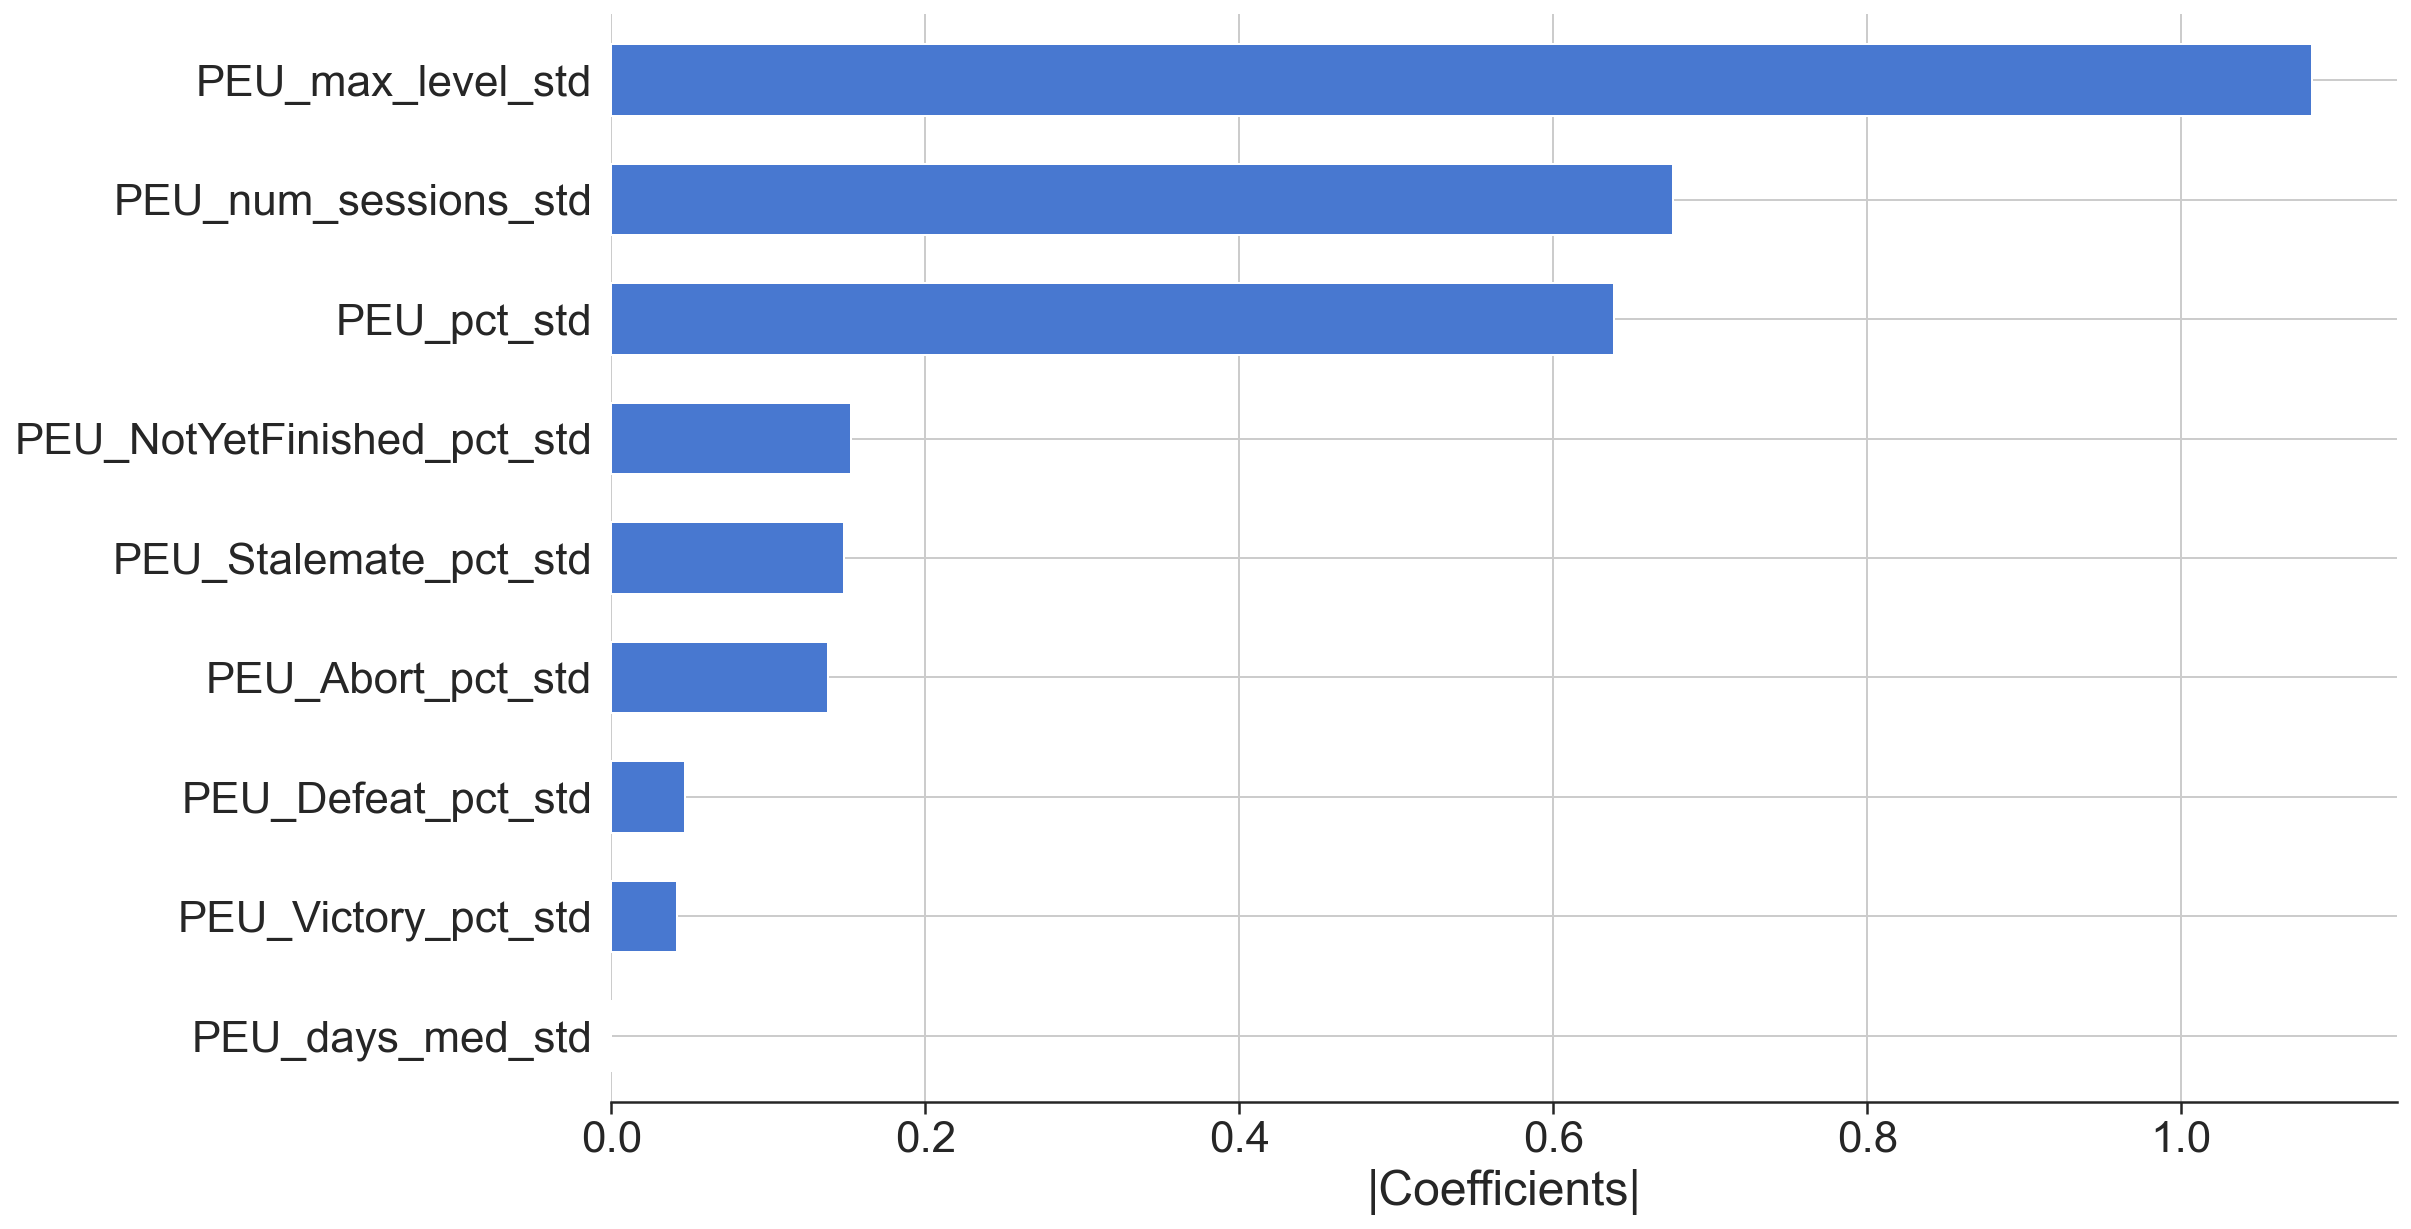

In [71]:
df = pd.DataFrame(data={'variables':list(df_PEU.columns), 'coefs':abs(model.coef_).tolist()[0]})
ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

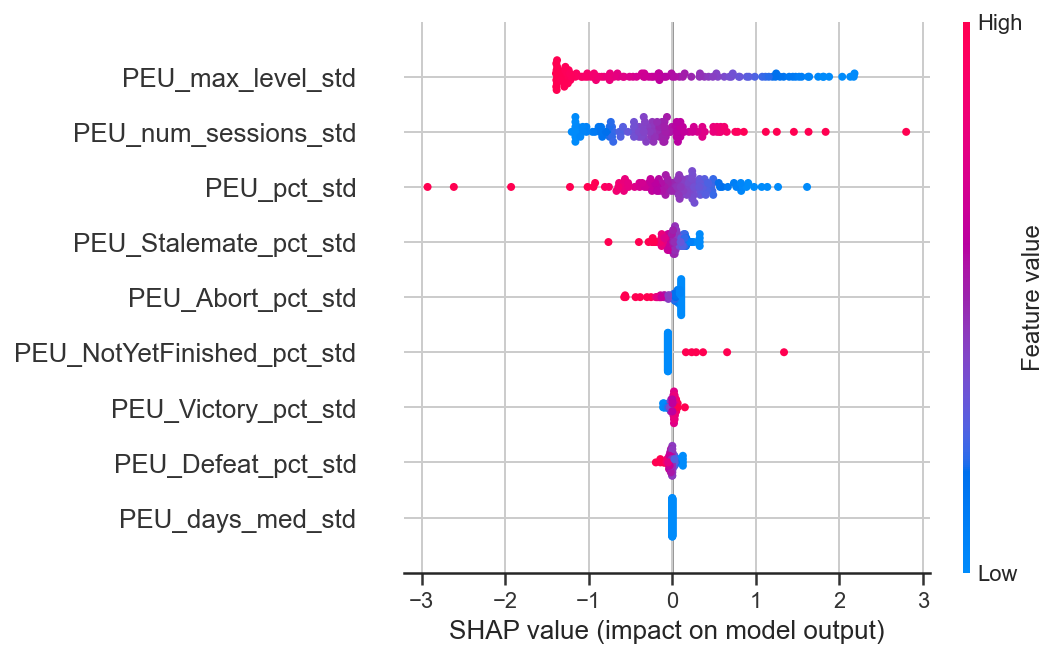

In [72]:
shap.summary_plot(shap_values, df_PEU, show=False)

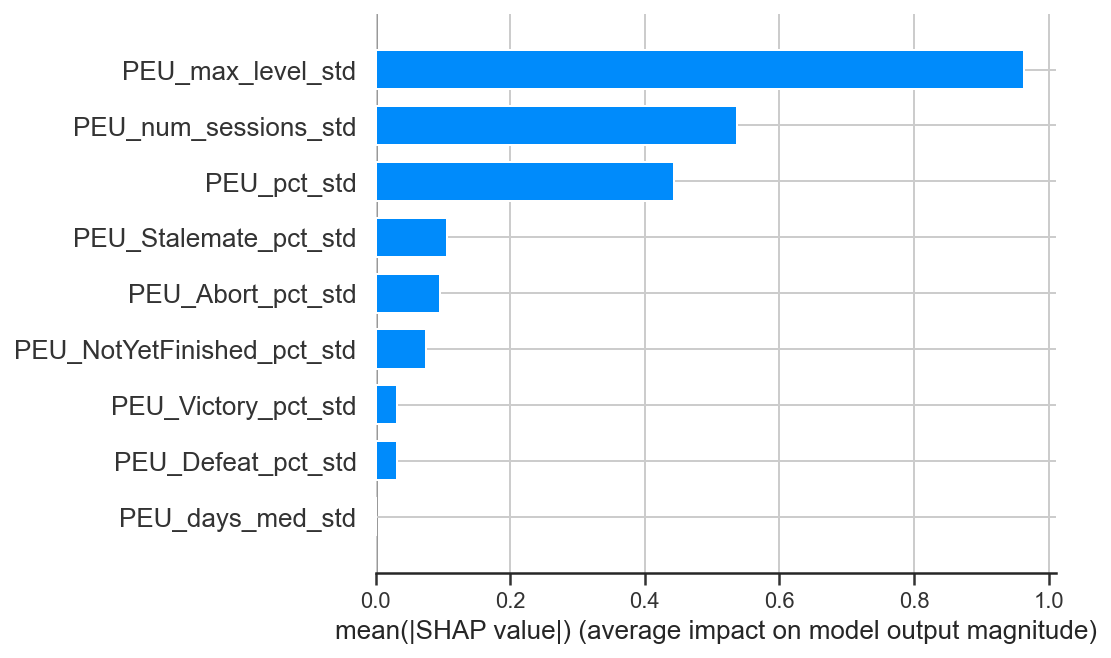

In [73]:
shap.summary_plot(shap_values, df_PEU, plot_type='bar', show=False)

In [74]:
classifiers = {
    "Logistic Regression": clf_lr,
    "Ridge Regression": clf_ridge,
    "Support Vector Machine":clf_svc,
    "Decision Tree": clf_cart,
    "Random Forest": clf_rf
}


clf_scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'average_precision']

for name, clf in classifiers.items():
    print(f"Evaluating {name}:")
    
    eval_zscore = cross_validate(clf, df_PEU, df_v2[cls_type], scoring=clf_scoring, cv=5)
    print(f"Results for {name} on first subset of columns which are related game performance and z-scores:")
    print_clf_metric(eval_zscore)
    
    
    print("--------------------------------------------------")

Evaluating Logistic Regression:
Results for Logistic Regression on first subset of columns which are related game performance and z-scores:
Metric          Mean       Std
------------------------------
ACCU          0.7290    0.0634
P             0.7443    0.0748
R             0.7290    0.0634
F1            0.7251    0.0650
AUROC         0.8159    0.0415
AUPRC         0.7788    0.0737
--------------------------------------------------
Evaluating Ridge Regression:
Results for Ridge Regression on first subset of columns which are related game performance and z-scores:
Metric          Mean       Std
------------------------------
ACCU          0.7040    0.0739
P             0.7213    0.0849
R             0.7040    0.0739
F1            0.6982    0.0770
AUROC         0.8202    0.0399
AUPRC         0.7808    0.0738
--------------------------------------------------
Evaluating Support Vector Machine:
Results for Support Vector Machine on first subset of columns which are related game performa

In [75]:
cls_type = 'min_adhr_cls' 
AU_game=['AU_num_sessions_std','AU_pct_std','AU_Abort_pct_std','AU_Defeat_pct_std','AU_Victory_pct_std', 'AU_Stalemate_pct_std',
        'AU_NotYetFinished_pct_std','AU_days_med_std','AU_max_level_std']
df_AU = df_v2[AU_game]

In [76]:
model = LogisticRegression(random_state=42)
model.fit(df_AU, df_v2[cls_type])
masker = shap.maskers.Independent(data=df_AU)
explainer = shap.LinearExplainer(model, masker)
shap_values = explainer.shap_values(df_AU)

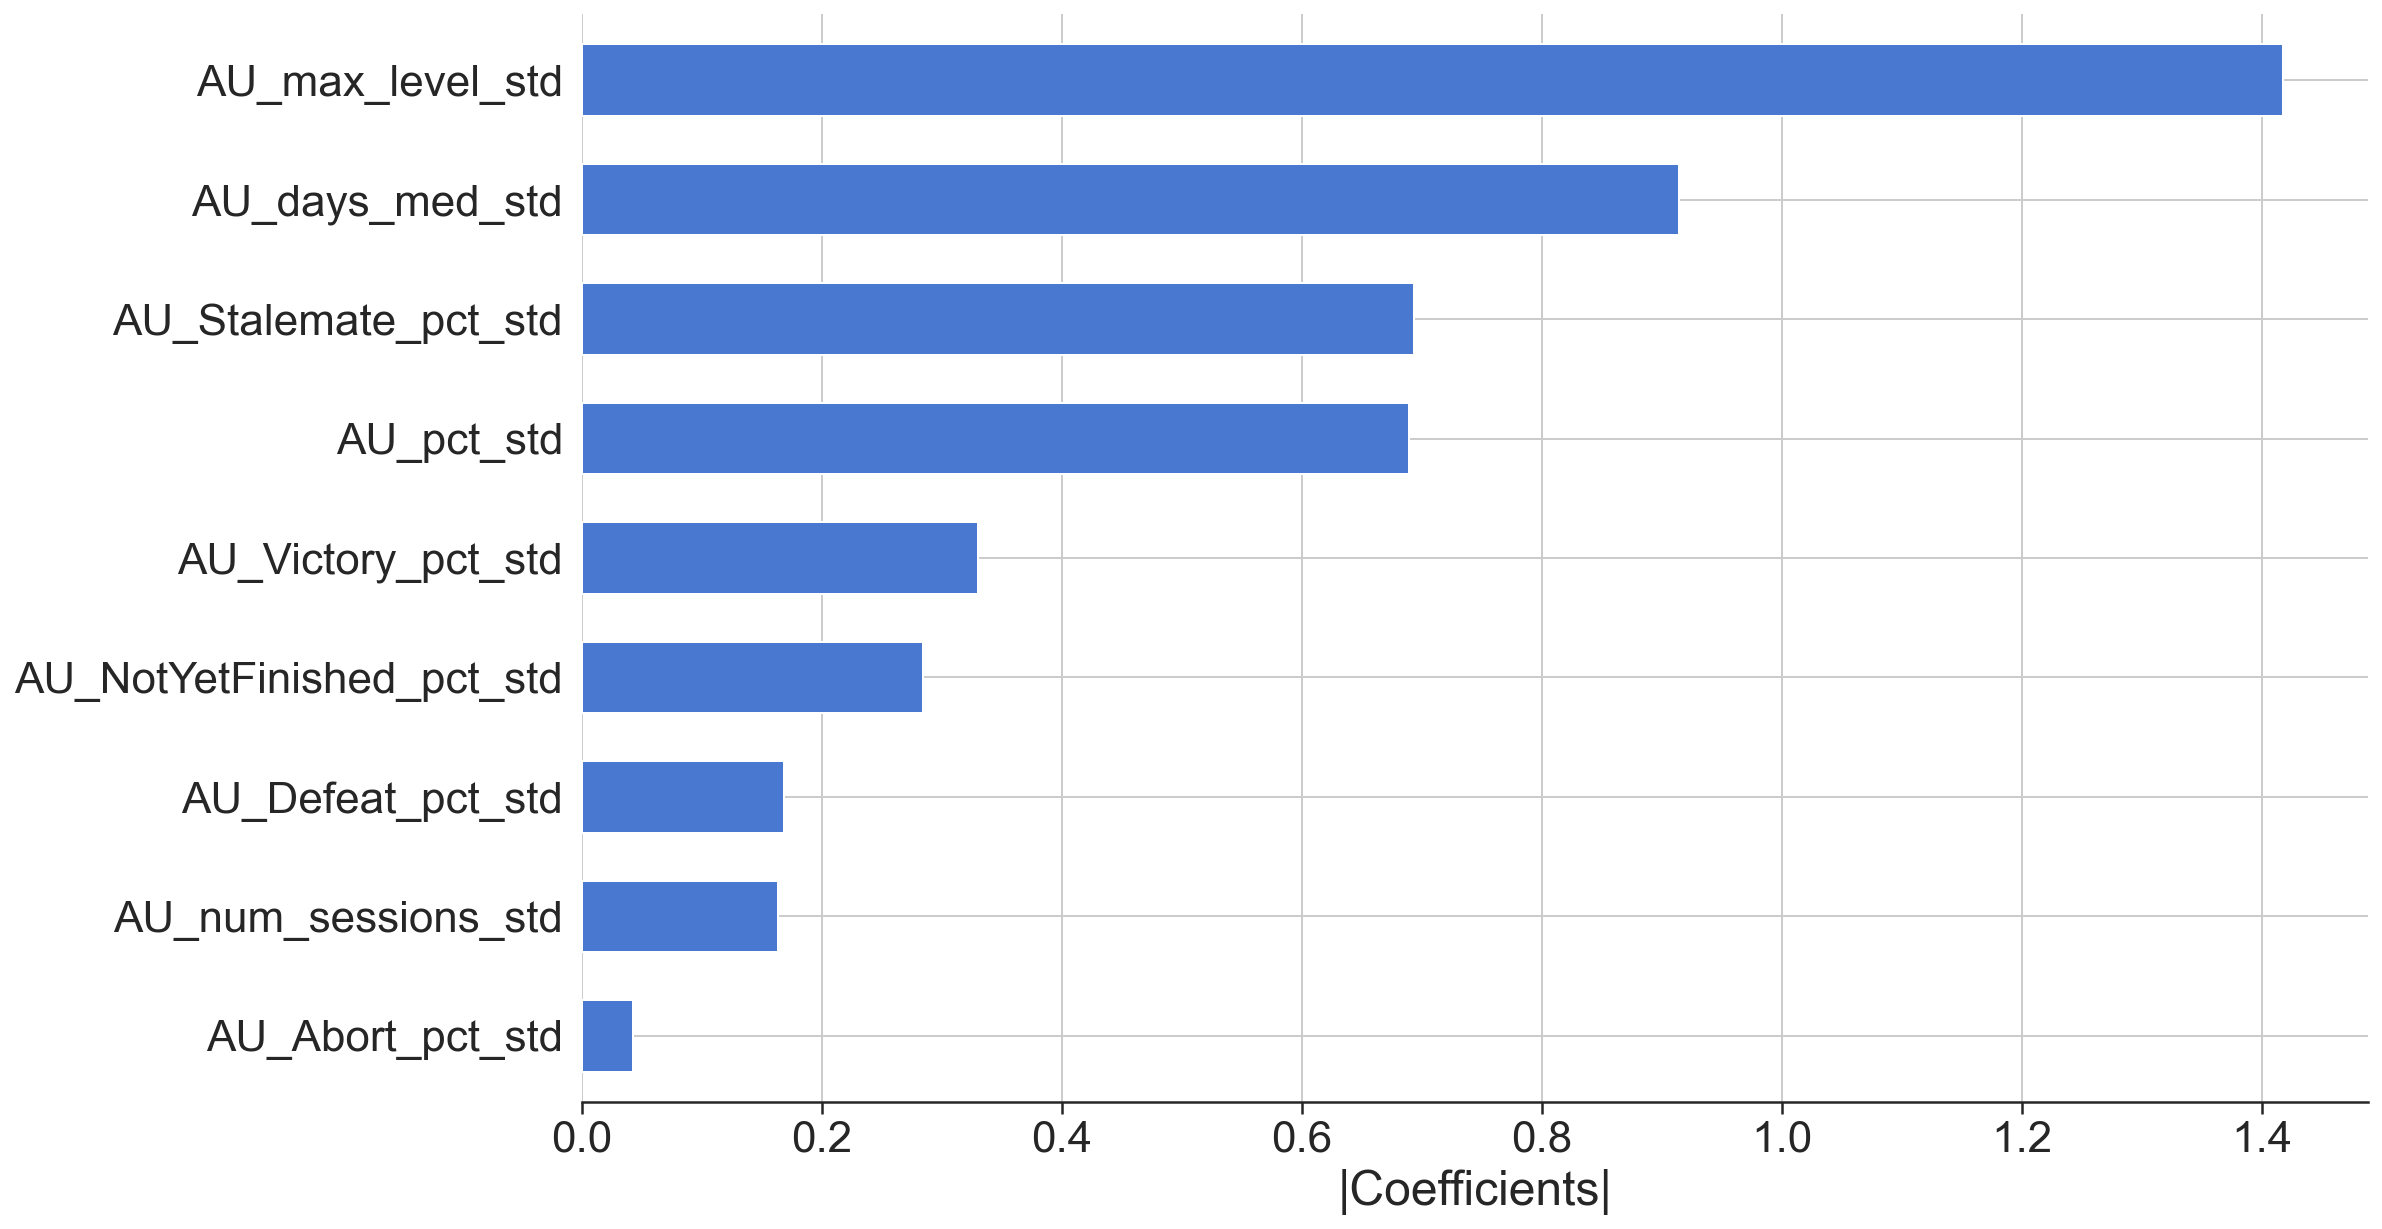

In [77]:
df = pd.DataFrame(data={'variables':list(df_AU.columns), 'coefs':abs(model.coef_).tolist()[0]})
ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

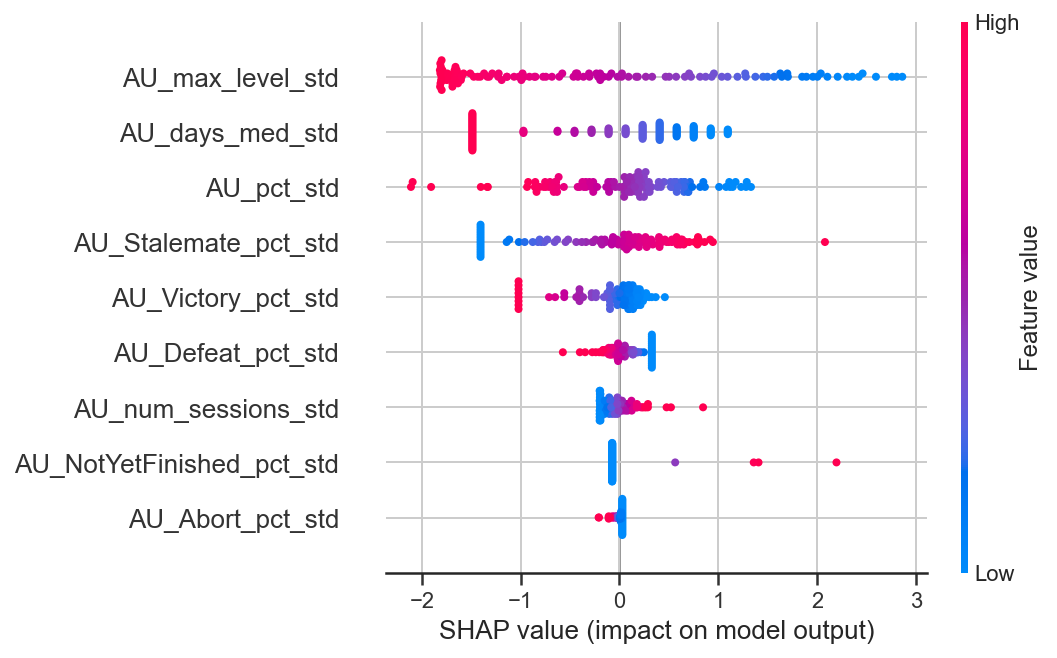

In [78]:
shap.summary_plot(shap_values, df_AU, show=False)

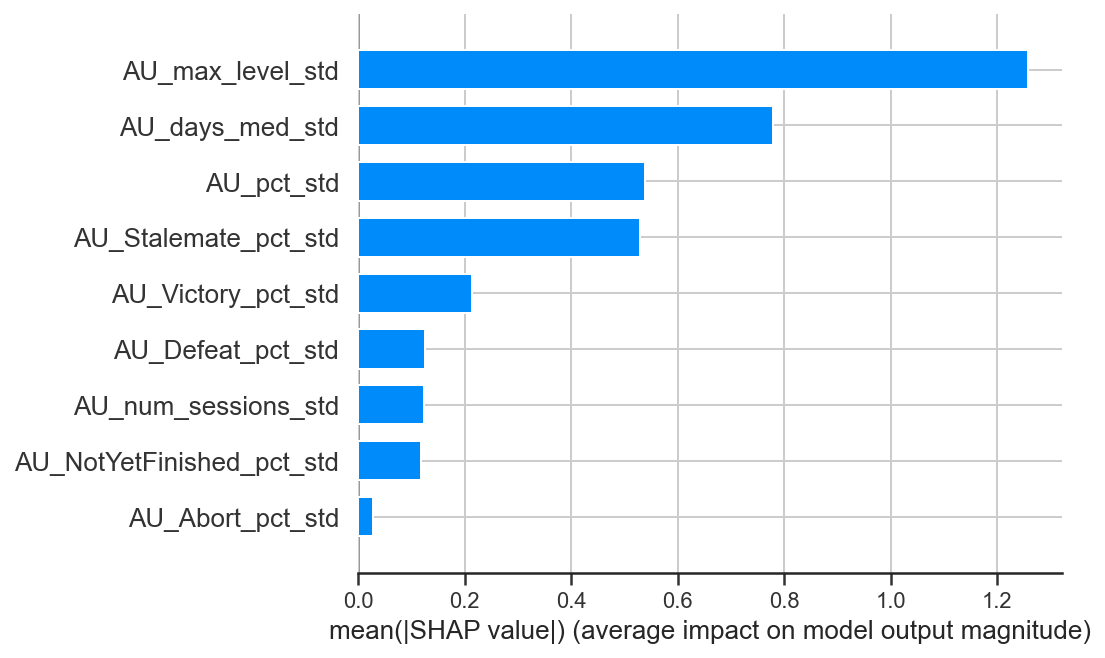

In [79]:
shap.summary_plot(shap_values, df_AU, plot_type='bar', show=False)

In [80]:
classifiers = {
    "Logistic Regression": clf_lr,
    "Ridge Regression": clf_ridge,
    "Support Vector Machine":clf_svc,
    "Decision Tree": clf_cart,
    "Random Forest": clf_rf
}


clf_scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'average_precision']

for name, clf in classifiers.items():
    print(f"Evaluating {name}:")
    
    eval_zscore = cross_validate(clf, df_AU, df_v2[cls_type], scoring=clf_scoring, cv=5)
    print(f"Results for {name} on first subset of columns which are related game performance:")
    print_clf_metric(eval_zscore)
    
    
    print("--------------------------------------------------")

Evaluating Logistic Regression:
Results for Logistic Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7554    0.1059
P             0.7577    0.1058
R             0.7554    0.1059
F1            0.7552    0.1059
AUROC         0.8302    0.0666
AUPRC         0.8108    0.0590
--------------------------------------------------
Evaluating Ridge Regression:
Results for Ridge Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7547    0.1083
P             0.7564    0.1067
R             0.7547    0.1083
F1            0.7543    0.1087
AUROC         0.8545    0.0719
AUPRC         0.8566    0.0764
--------------------------------------------------
Evaluating Support Vector Machine:
Results for Support Vector Machine on first subset of columns which are related game performance:
Metric          Mean 

In [81]:
cls_type = 'min_adhr_cls' 
TJ_game=['TJ_num_sessions_std','TJ_pct_std','TJ_Abort_pct_std','TJ_Defeat_pct_std','TJ_Victory_pct_std', 'TJ_Stalemate_pct_std',
        'TJ_NotYetFinished_pct_std','TJ_days_med_std','TJ_max_level_std']
df_TJ = df_v2[TJ_game]

In [82]:
model = LogisticRegression(random_state=42)
model.fit(df_TJ, df_v2[cls_type])
masker = shap.maskers.Independent(data=df_TJ)
explainer = shap.LinearExplainer(model, masker)
shap_values = explainer.shap_values(df_TJ)

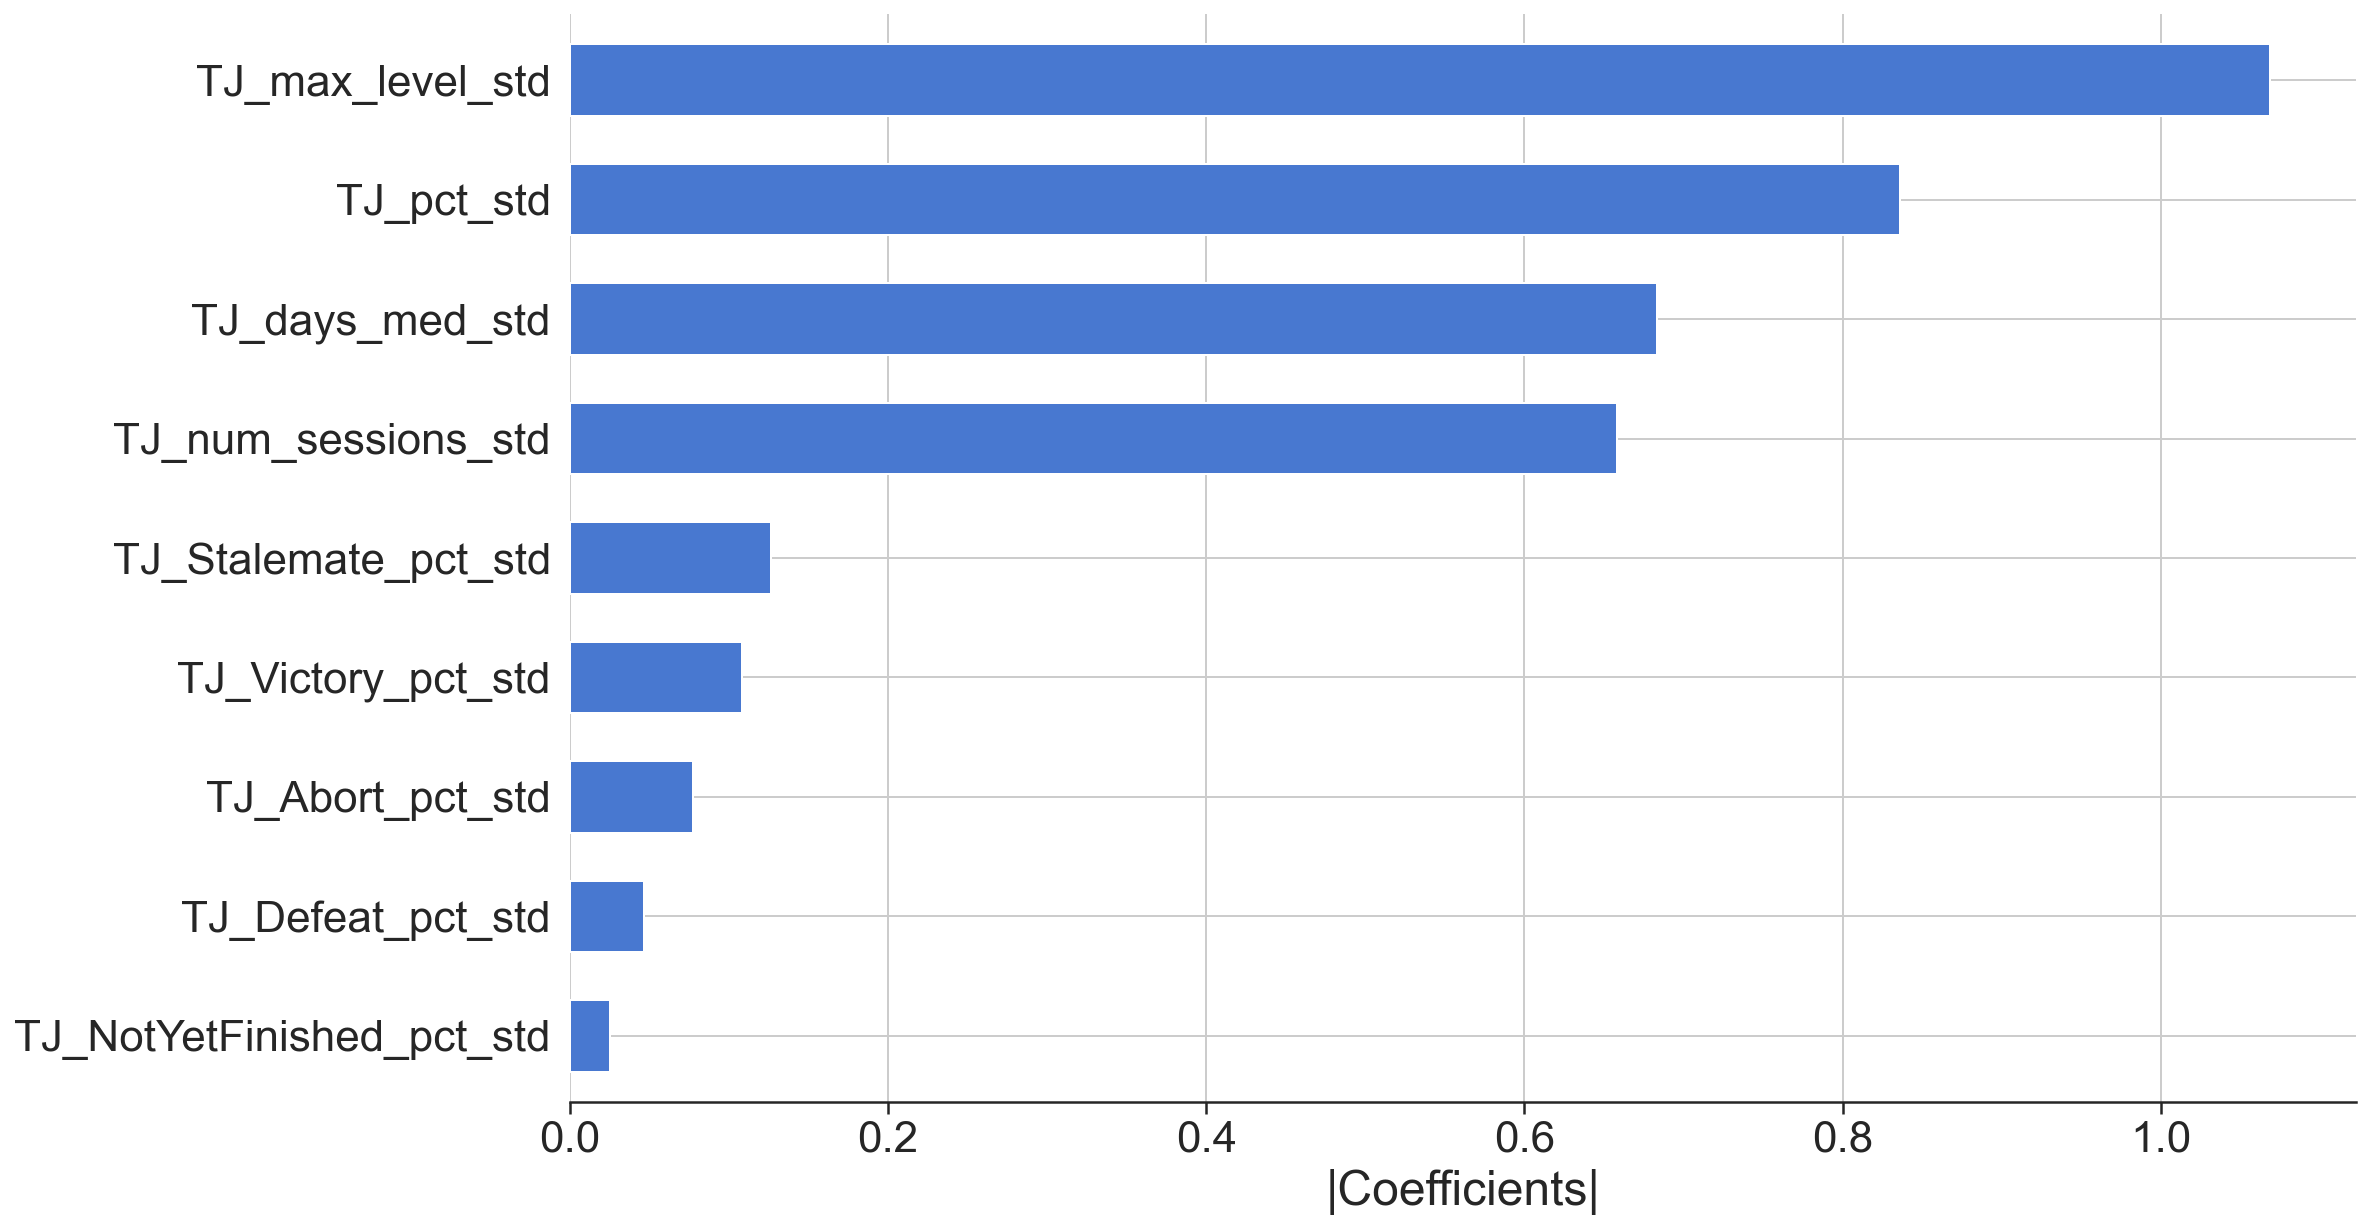

In [83]:
df = pd.DataFrame(data={'variables':list(df_TJ.columns), 'coefs':abs(model.coef_).tolist()[0]})
ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

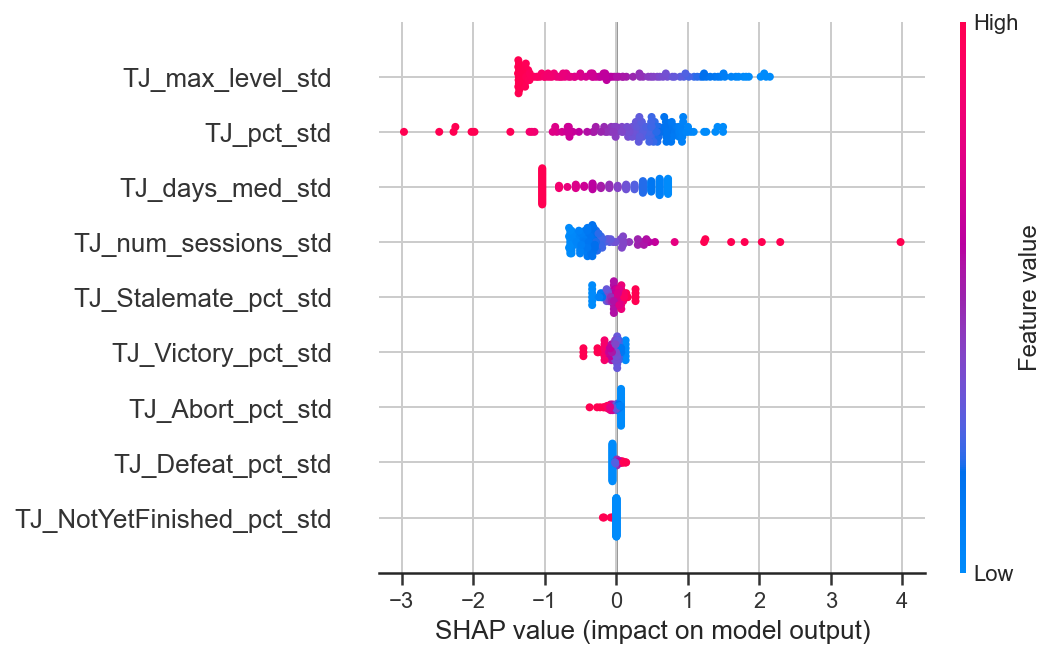

In [84]:
shap.summary_plot(shap_values, df_TJ, show=False)

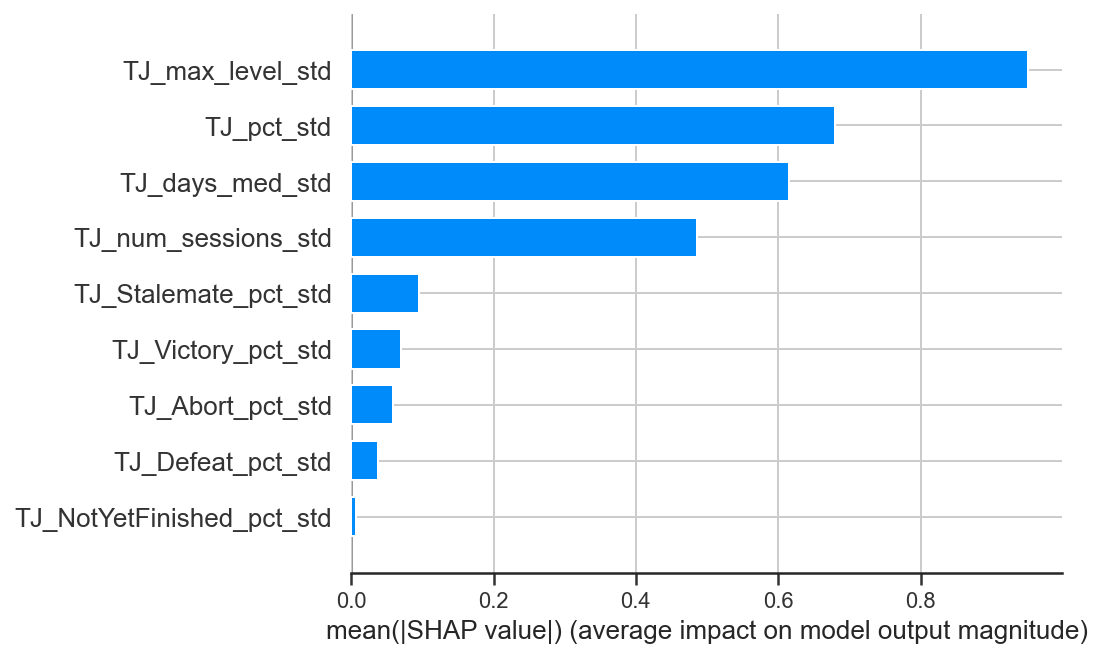

In [85]:
shap.summary_plot(shap_values, df_TJ, plot_type='bar', show=False)

In [86]:
classifiers = {
    "Logistic Regression": clf_lr,
    "Ridge Regression": clf_ridge,
    "Support Vector Machine":clf_svc,
    "Decision Tree": clf_cart,
    "Random Forest": clf_rf
}


clf_scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'average_precision']

for name, clf in classifiers.items():
    print(f"Evaluating {name}:")
    
    eval_zscore = cross_validate(clf, df_TJ, df_v2[cls_type], scoring=clf_scoring, cv=5)
    print(f"Results for {name} on first subset of columns which are related game performance and z-scores:")
    print_clf_metric(eval_zscore)
    
    print("--------------------------------------------------")

Evaluating Logistic Regression:
Results for Logistic Regression on first subset of columns which are related game performance and z-scores:
Metric          Mean       Std
------------------------------
ACCU          0.7286    0.1304
P             0.7328    0.1352
R             0.7286    0.1304
F1            0.7278    0.1308
AUROC         0.7961    0.1062
AUPRC         0.7928    0.1273
--------------------------------------------------
Evaluating Ridge Regression:
Results for Ridge Regression on first subset of columns which are related game performance and z-scores:
Metric          Mean       Std
------------------------------
ACCU          0.7457    0.1192
P             0.7526    0.1248
R             0.7457    0.1192
F1            0.7449    0.1188
AUROC         0.7973    0.1196
AUPRC         0.7988    0.1416
--------------------------------------------------
Evaluating Support Vector Machine:
Results for Support Vector Machine on first subset of columns which are related game performa

In [87]:
cls_type = 'min_adhr_cls' 
SD_game=['SD_num_sessions_std','SD_pct_std','SD_Abort_pct_std','SD_Defeat_pct_std','SD_Victory_pct_std', 'SD_Stalemate_pct_std',
        'SD_NotYetFinished_pct_std','SD_days_med_std','SD_max_level_std']
df_SD = df_v2[SD_game]

In [88]:
model = LogisticRegression(random_state=42)
model.fit(df_SD, df_v2[cls_type])
masker = shap.maskers.Independent(data=df_SD)
explainer = shap.LinearExplainer(model, masker)
shap_values = explainer.shap_values(df_SD)

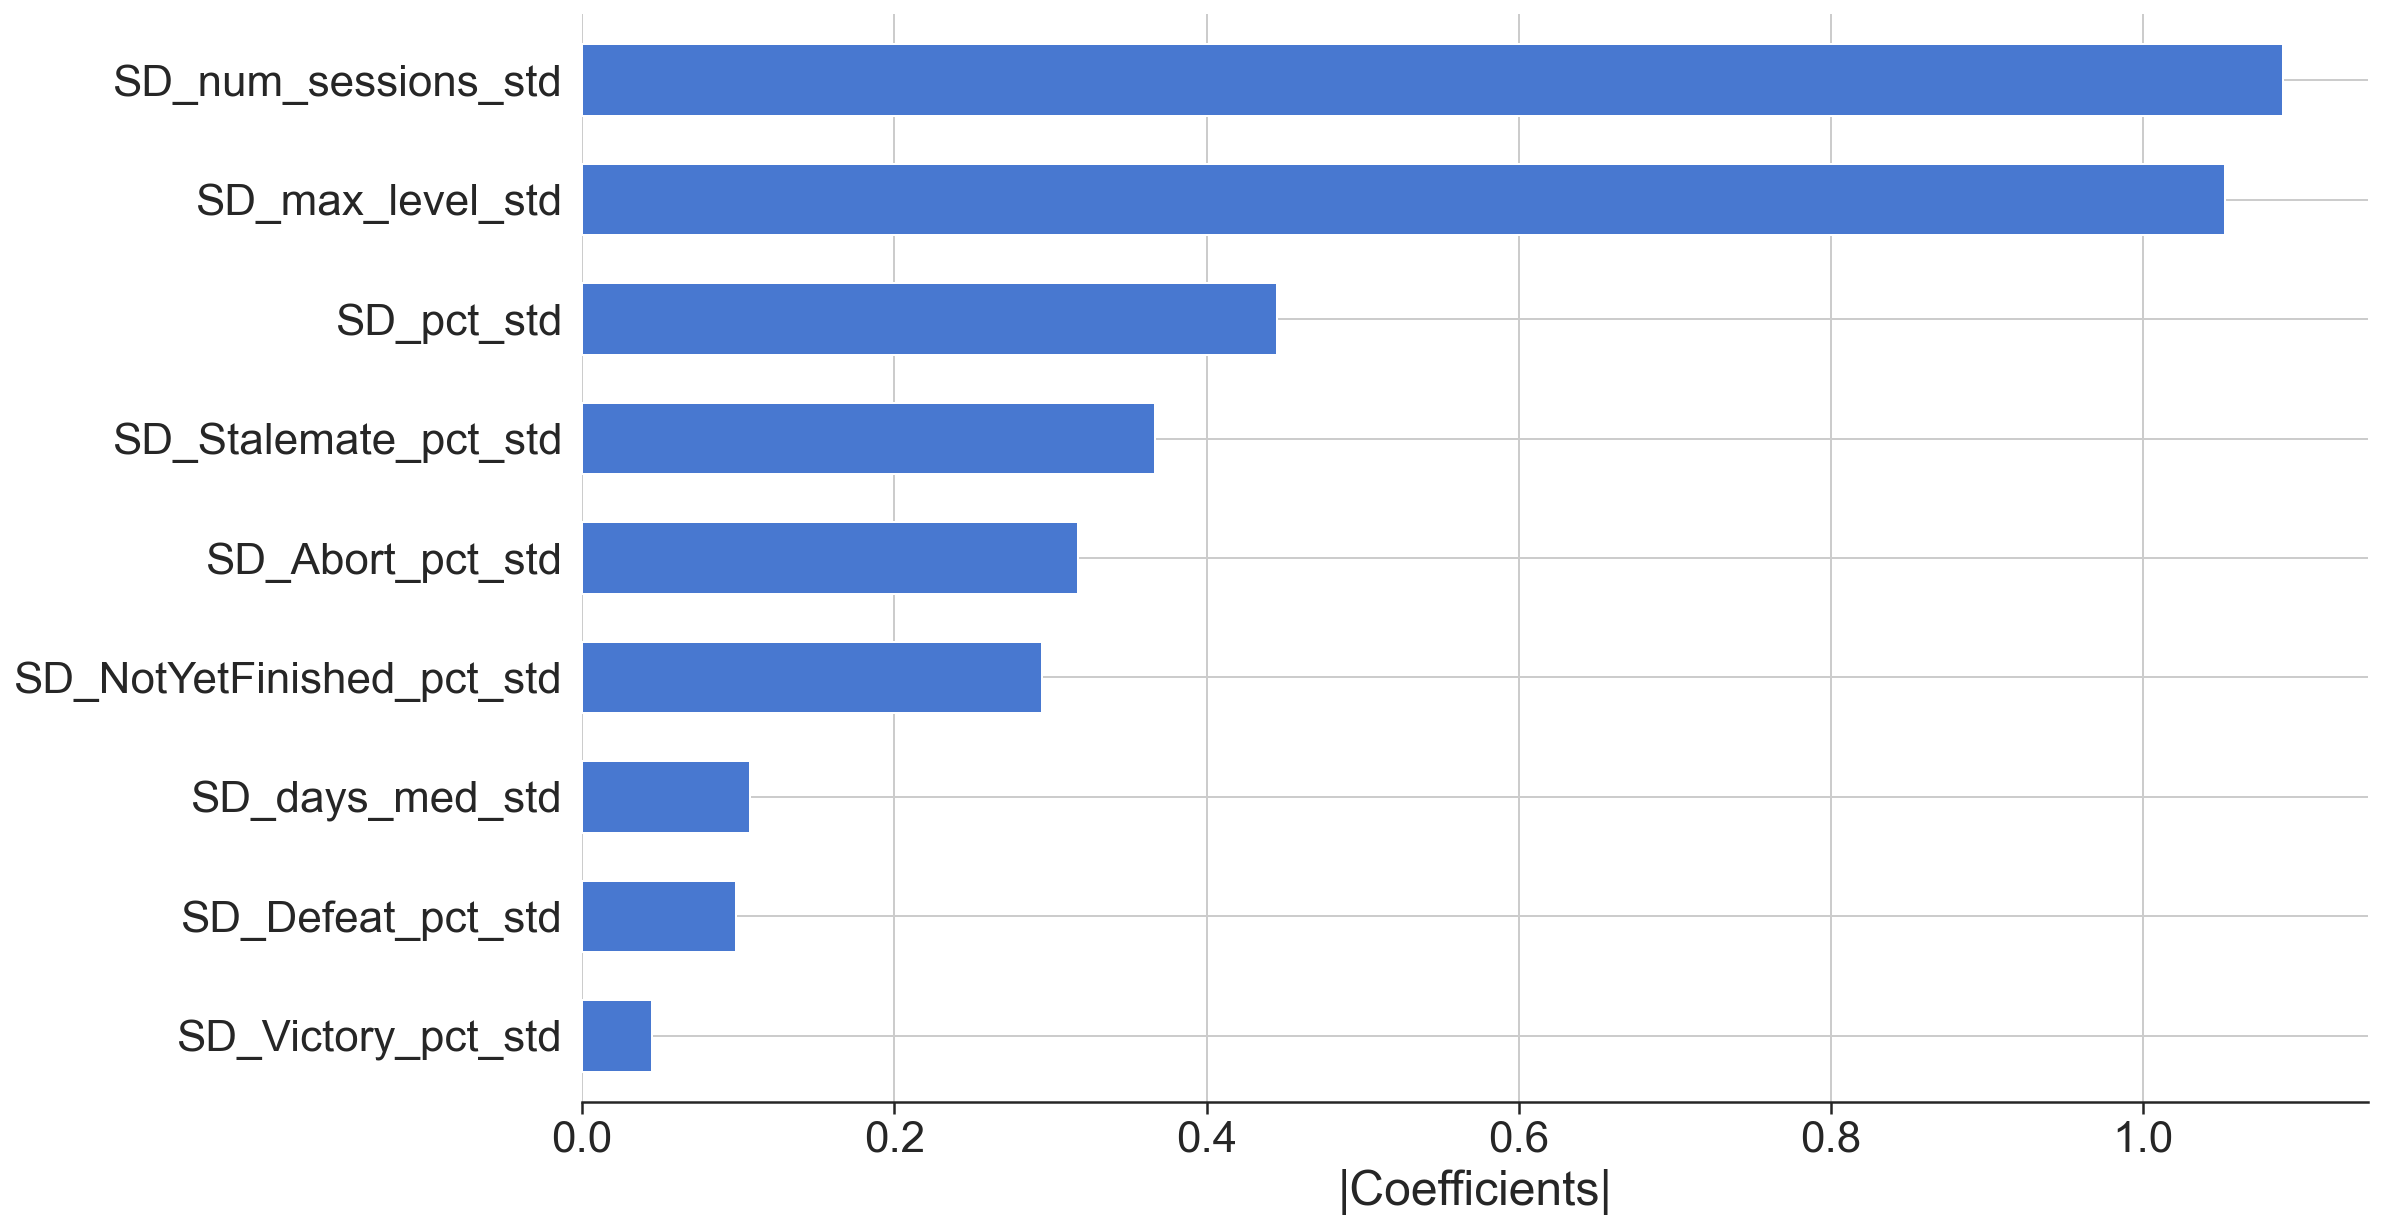

In [89]:
df = pd.DataFrame(data={'variables':list(df_SD.columns), 'coefs':abs(model.coef_).tolist()[0]})
ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

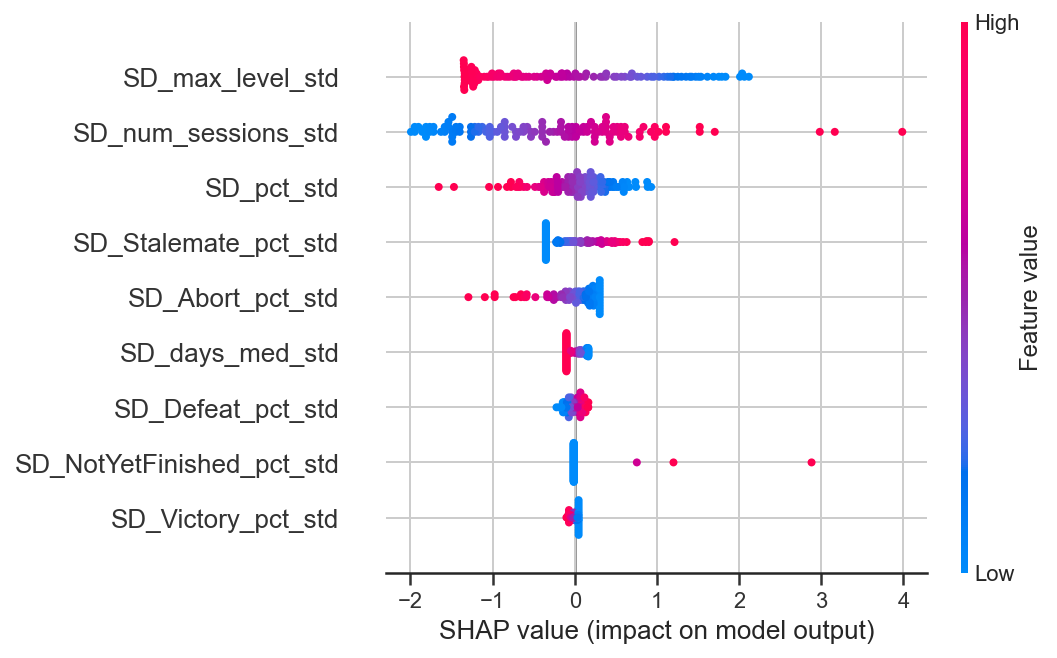

In [90]:
shap.summary_plot(shap_values, df_SD, show=False)

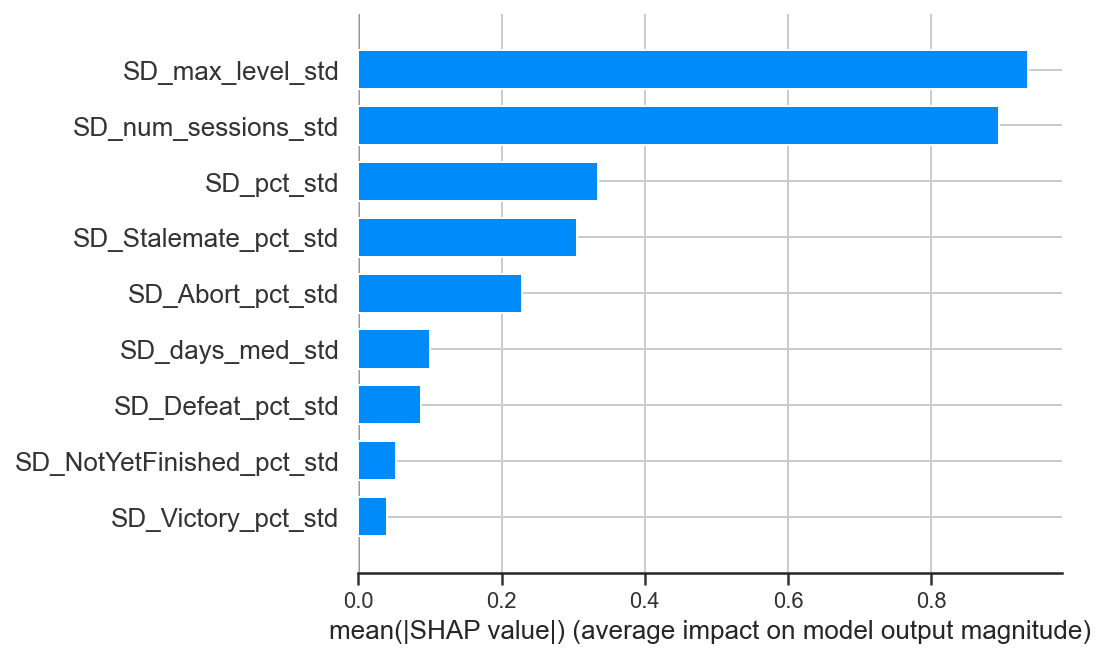

In [91]:
shap.summary_plot(shap_values, df_SD, plot_type='bar', show=False)

In [92]:
classifiers = {
    "Logistic Regression": clf_lr,
    "Ridge Regression": clf_ridge,
    "Support Vector Machine":clf_svc,
    "Decision Tree": clf_cart,
    "Random Forest": clf_rf
}


clf_scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'average_precision']

for name, clf in classifiers.items():
    print(f"Evaluating {name}:")
    
    eval_game = cross_validate(clf, df_SD, df_v2[cls_type], scoring=clf_scoring, cv=5)
    print(f"Results for {name} on first subset of columns which are related game performance:")
    print_clf_metric(eval_game)
    
    print("--------------------------------------------------")

Evaluating Logistic Regression:
Results for Logistic Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7460    0.0806
P             0.7523    0.0762
R             0.7460    0.0806
F1            0.7443    0.0825
AUROC         0.8365    0.0789
AUPRC         0.8004    0.1229
--------------------------------------------------
Evaluating Ridge Regression:
Results for Ridge Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7638    0.0965
P             0.7756    0.0978
R             0.7638    0.0965
F1            0.7616    0.0977
AUROC         0.8396    0.0752
AUPRC         0.8005    0.1154
--------------------------------------------------
Evaluating Support Vector Machine:
Results for Support Vector Machine on first subset of columns which are related game performance:
Metric          Mean 

#### Y=ful_adhr_cls

In [93]:
cls_type = 'ful_adhr_cls' 
SR_game=['SR_num_sessions_std','SR_pct_std','SR_Abort_pct_std','SR_Defeat_pct_std','SR_Victory_pct_std', 'SR_Stalemate_pct_std',
              'SR_NotYetFinished_pct_std','SR_days_med_std','SR_max_level_std']
df_SR = df_v2[SR_game]

In [94]:
model = LogisticRegression(random_state=42)
model.fit(df_SR, df_v2[cls_type])
masker = shap.maskers.Independent(data=df_SR)
explainer = shap.LinearExplainer(model, masker)
shap_values = explainer.shap_values(df_SR)

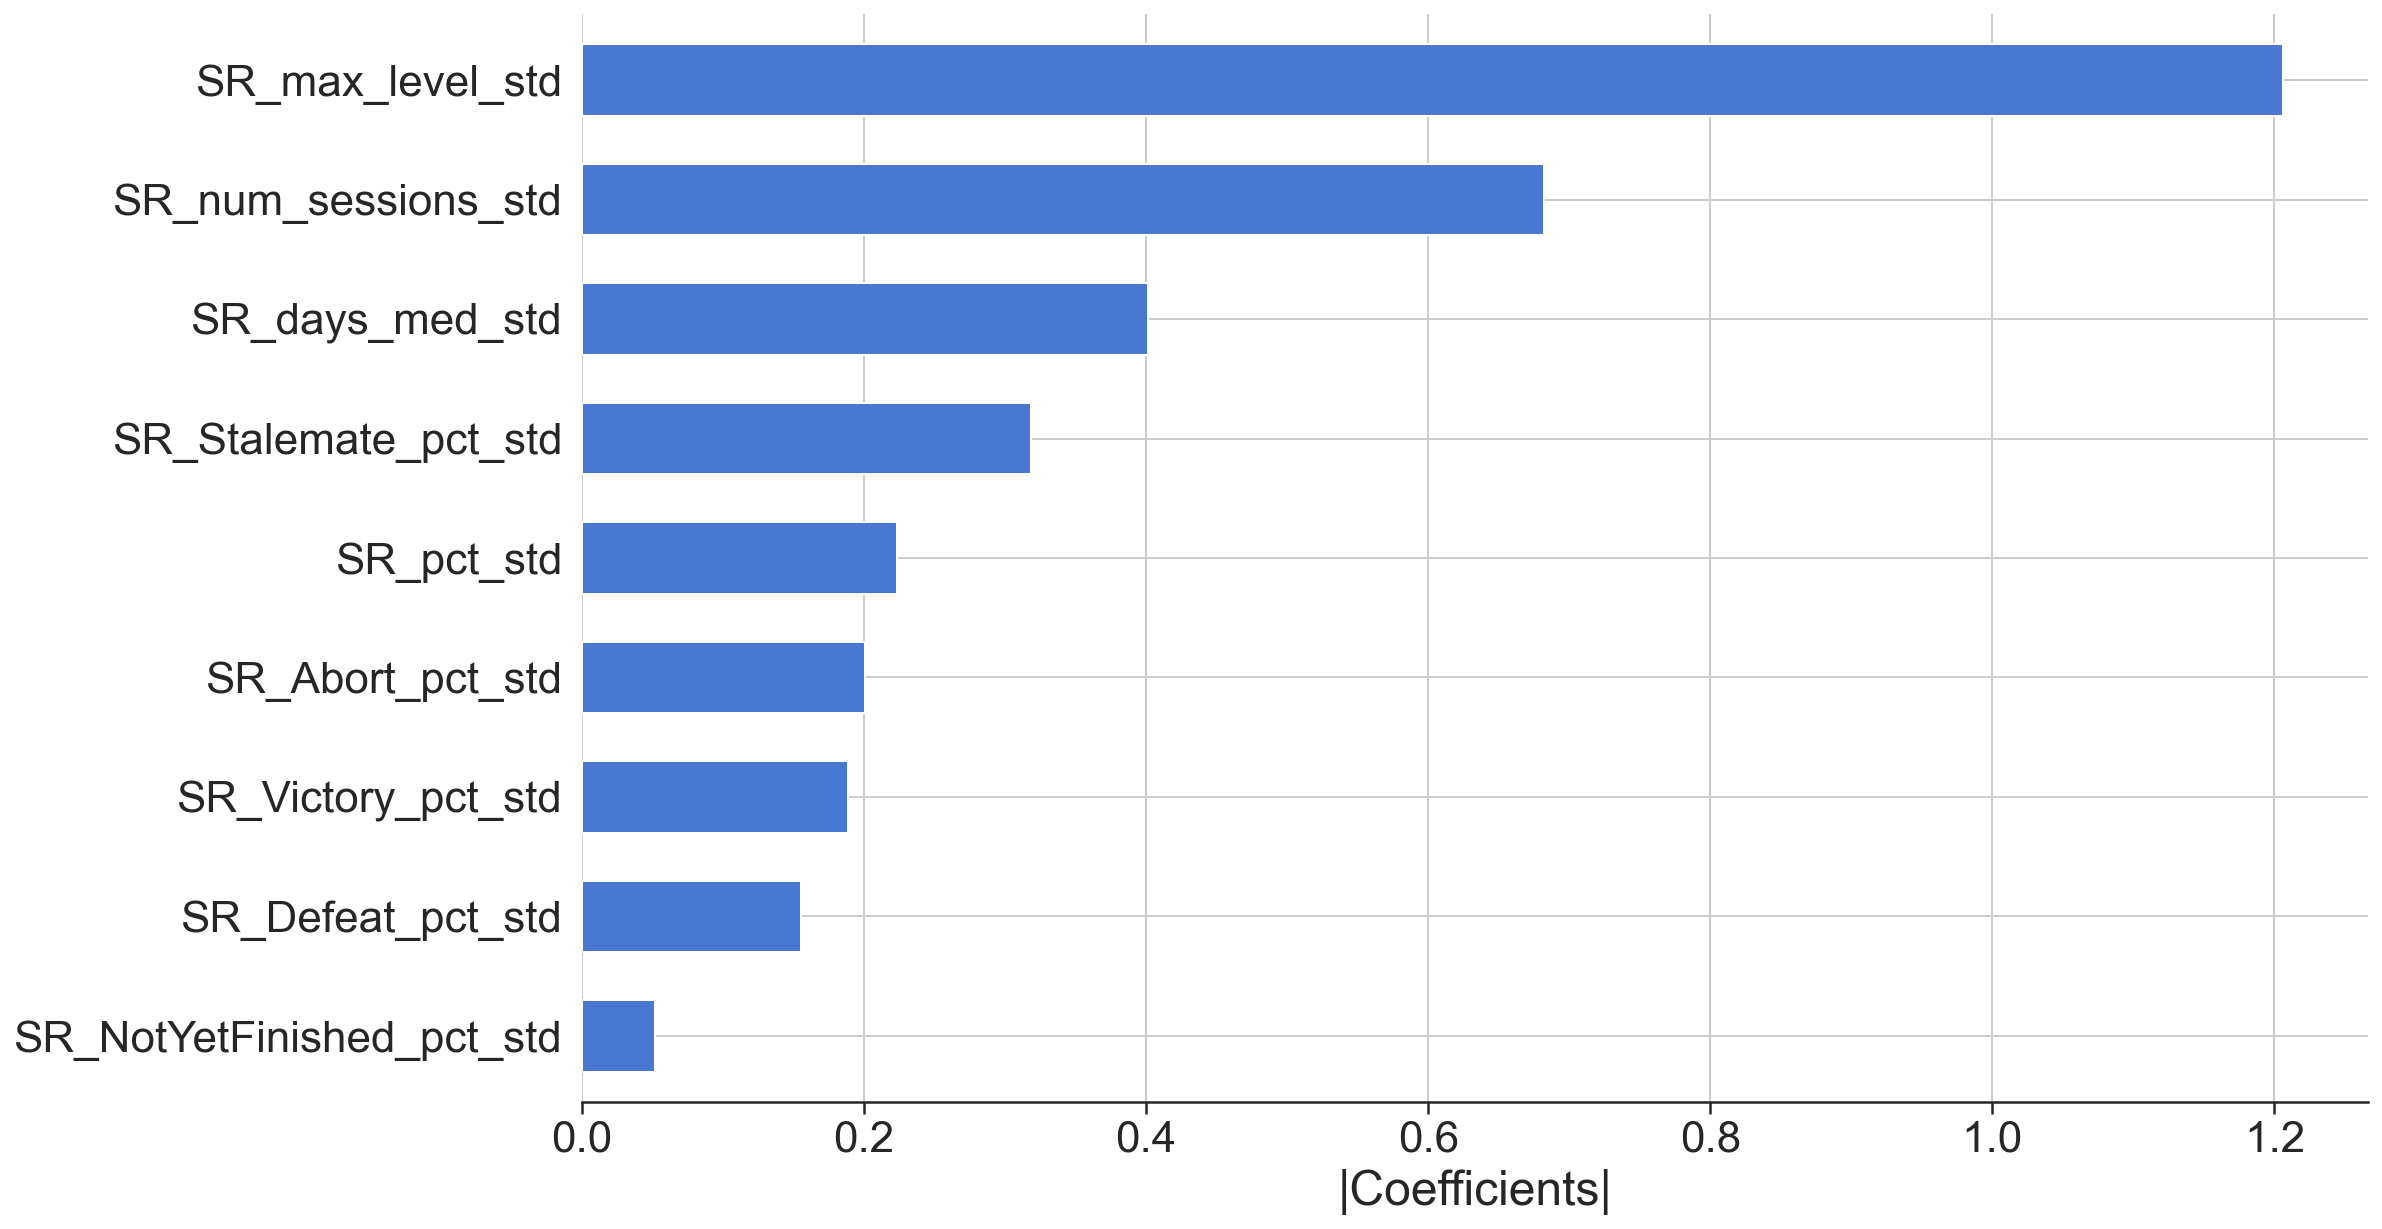

In [95]:
df = pd.DataFrame(data={'variables':list(df_SR.columns), 'coefs':abs(model.coef_).tolist()[0]})
ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

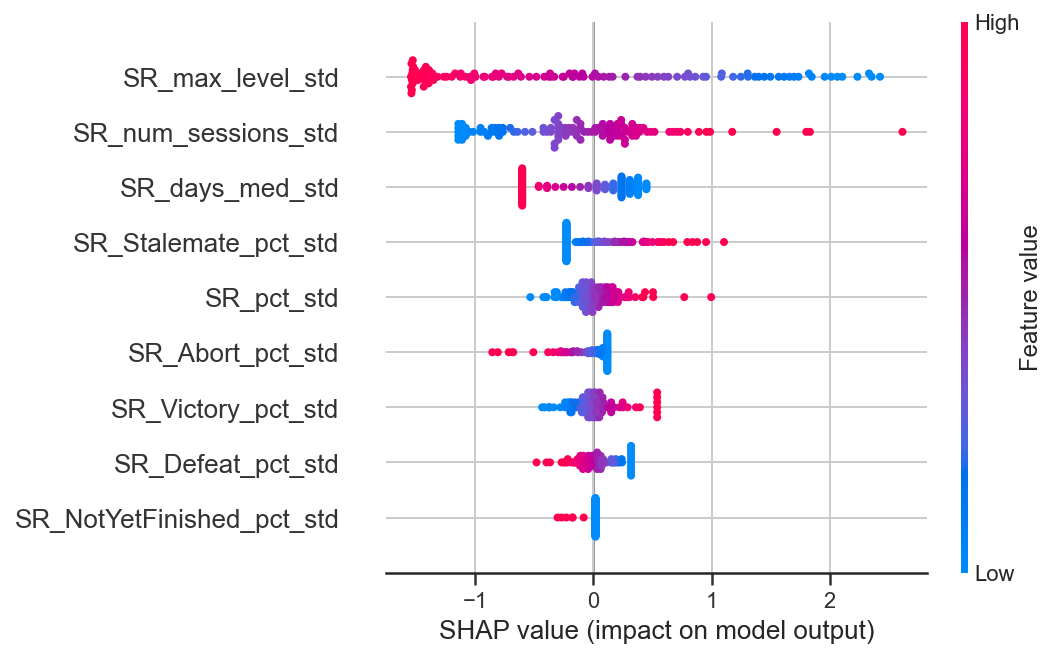

In [96]:
shap.summary_plot(shap_values, df_SR, show=False)

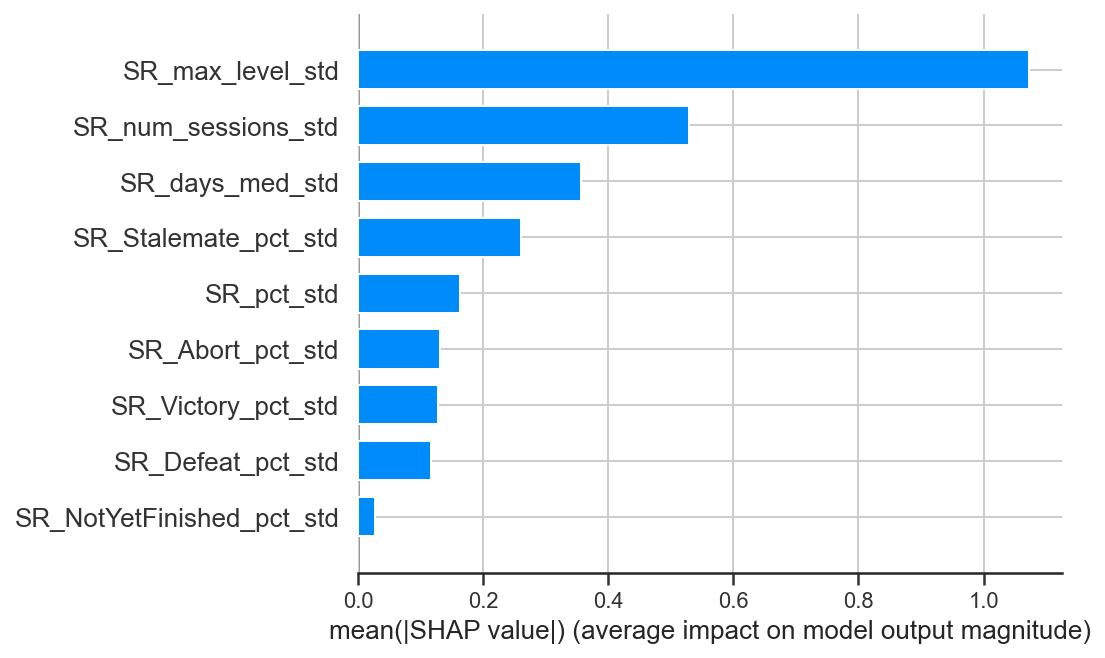

In [97]:
shap.summary_plot(shap_values, df_SR, plot_type='bar', show=False)

In [98]:
classifiers = {
    "Logistic Regression": clf_lr,
    "Ridge Regression": clf_ridge,
    "Support Vector Machine":clf_svc,
    "Decision Tree": clf_cart,
    "Random Forest": clf_rf
}


clf_scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'average_precision']

for name, clf in classifiers.items():
    print(f"Evaluating {name}:")
    
    eval_game = cross_validate(clf, df_SR, df_v2[cls_type], scoring=clf_scoring, cv=5)
    print(f"Results for {name} on first subset of columns which are related game performance:")
    print_clf_metric(eval_game)
    
    print("--------------------------------------------------")

Evaluating Logistic Regression:
Results for Logistic Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7623    0.0937
P             0.7712    0.0971
R             0.7623    0.0937
F1            0.7601    0.0950
AUROC         0.8301    0.1056
AUPRC         0.8168    0.1242
--------------------------------------------------
Evaluating Ridge Regression:
Results for Ridge Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7623    0.1009
P             0.7676    0.1004
R             0.7623    0.1009
F1            0.7607    0.1017
AUROC         0.8332    0.1019
AUPRC         0.8185    0.1172
--------------------------------------------------
Evaluating Support Vector Machine:
Results for Support Vector Machine on first subset of columns which are related game performance:
Metric          Mean 

In [99]:
cls_type = 'ful_adhr_cls' 
I_game=['I_num_sessions_std','I_pct_std','I_Abort_pct_std','I_Defeat_pct_std','I_Victory_pct_std', 'I_Stalemate_pct_std',
              'I_NotYetFinished_pct_std','I_days_med_std','I_max_level_std']
df_I = df_v2[I_game]

In [100]:
model = LogisticRegression(random_state=42)
model.fit(df_I, df_v2[cls_type])
masker = shap.maskers.Independent(data=df_I)
explainer = shap.LinearExplainer(model, masker)
shap_values = explainer.shap_values(df_I)

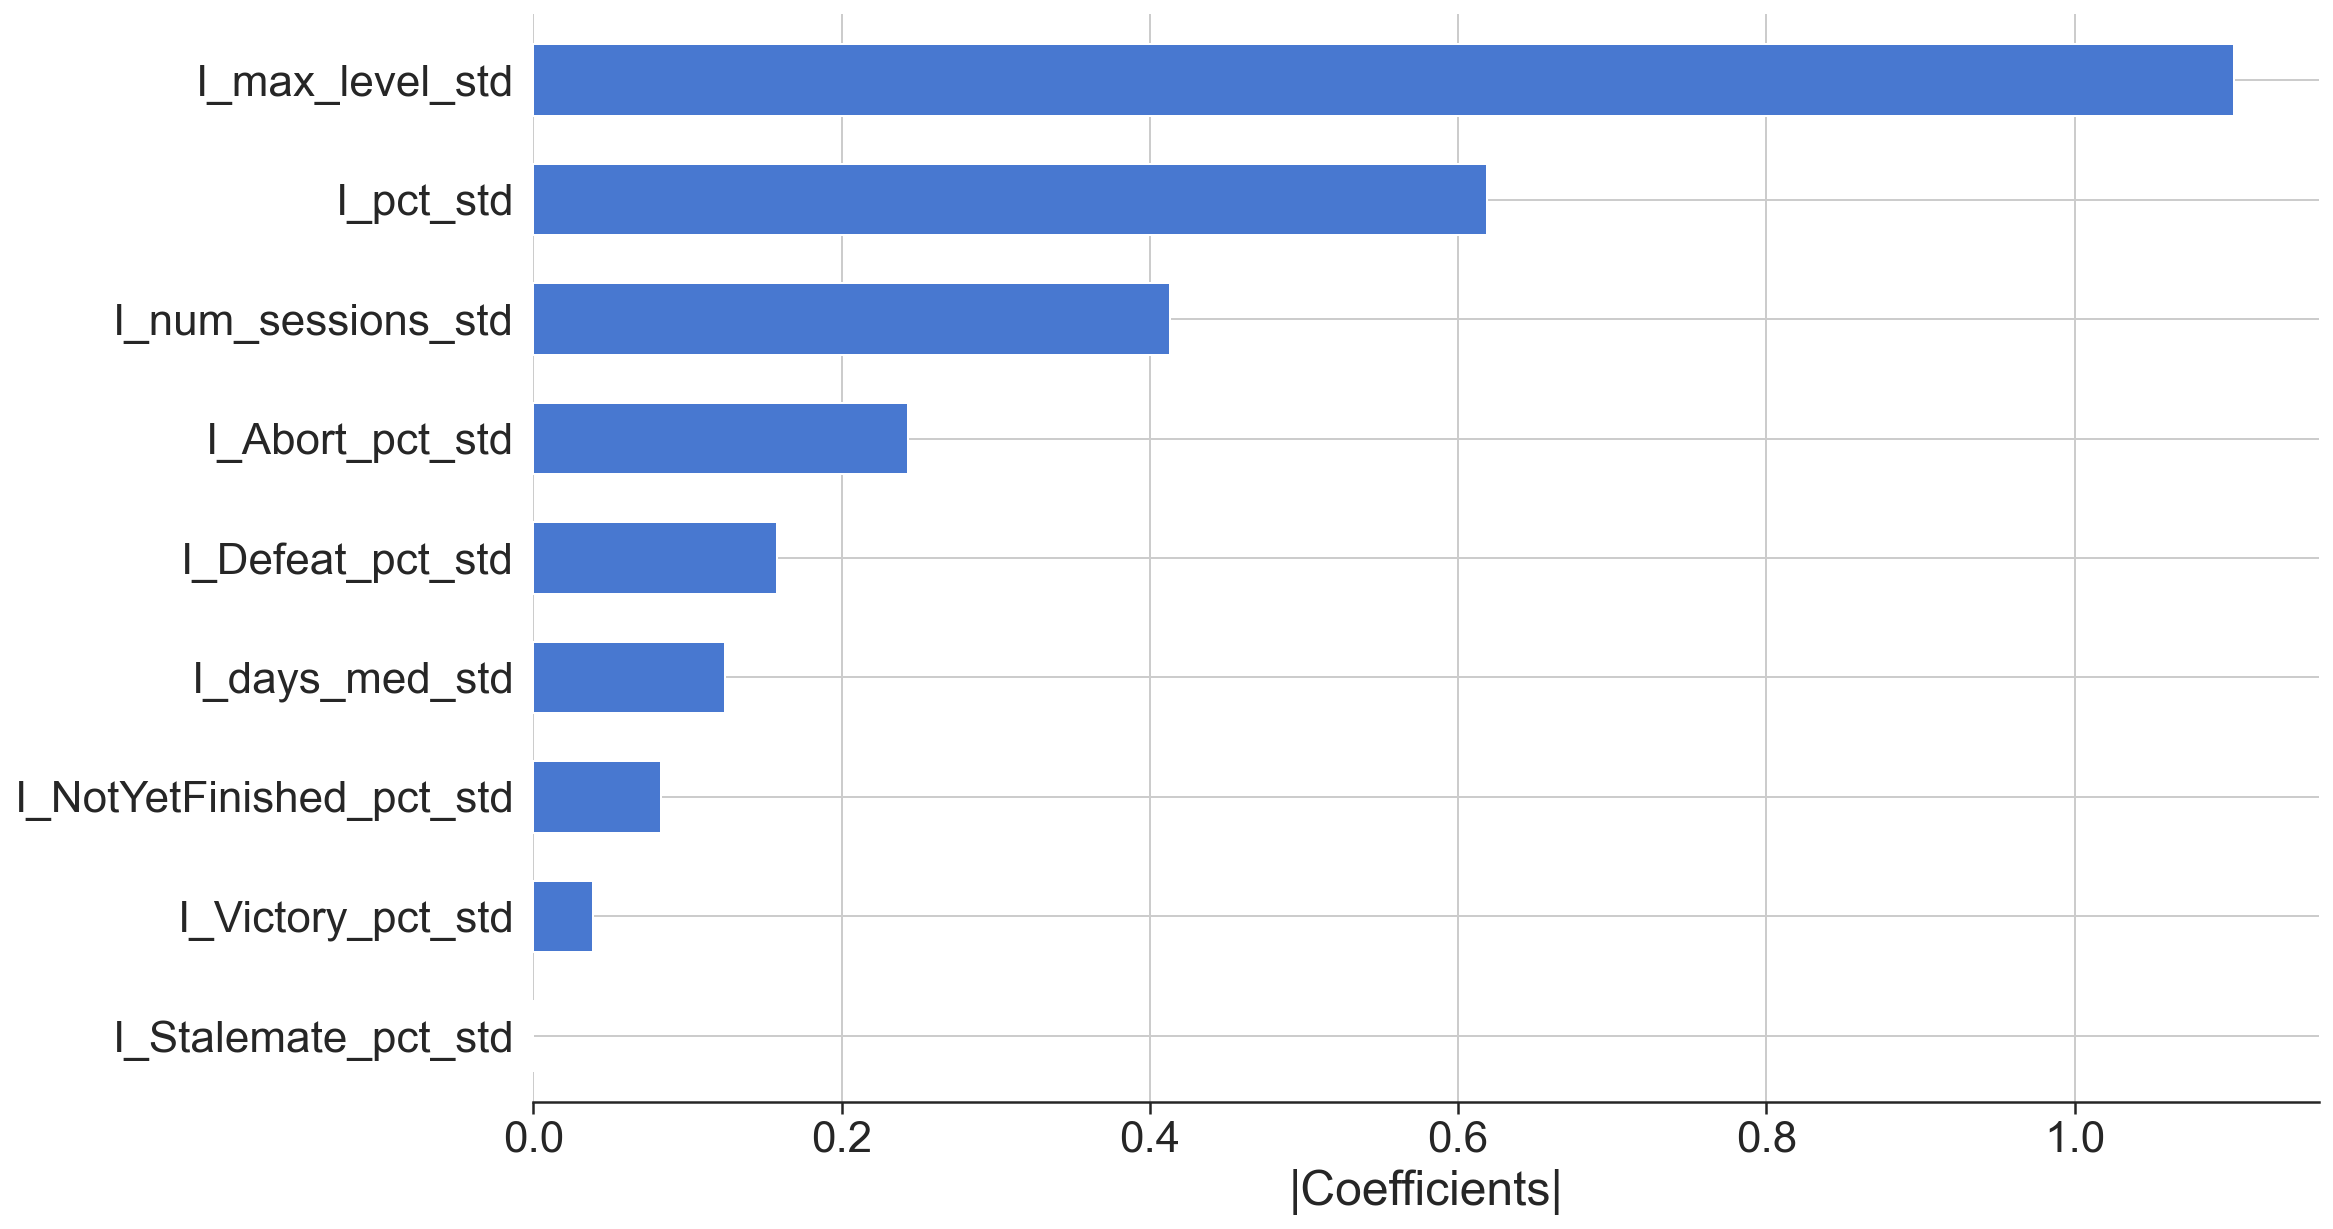

In [101]:
df = pd.DataFrame(data={'variables':list(df_I.columns), 'coefs':abs(model.coef_).tolist()[0]})
ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

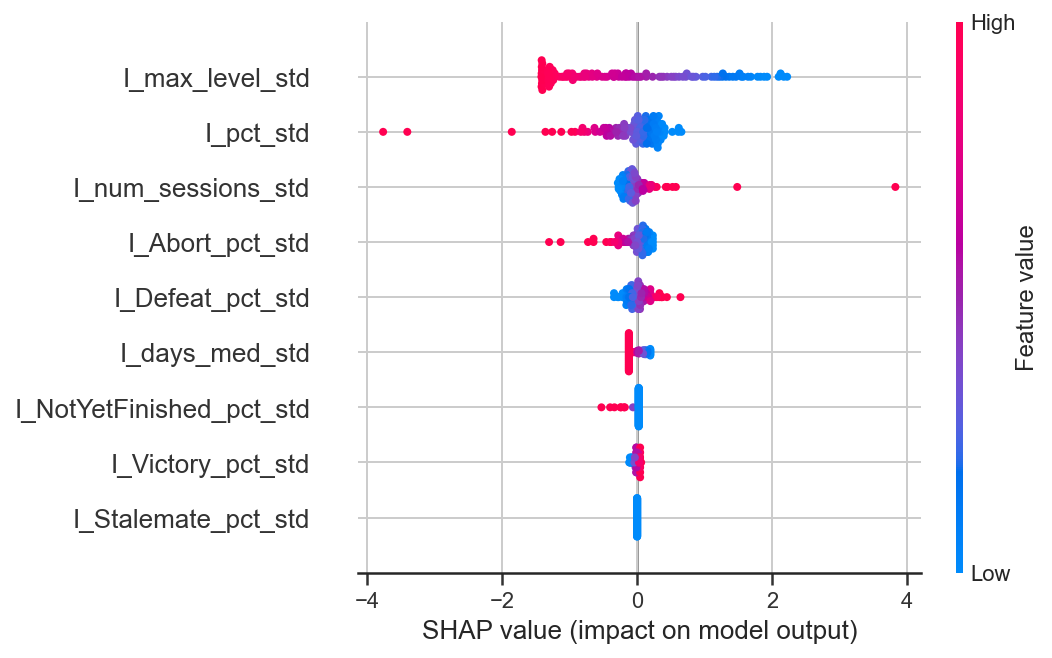

In [102]:
shap.summary_plot(shap_values, df_I, show=False)

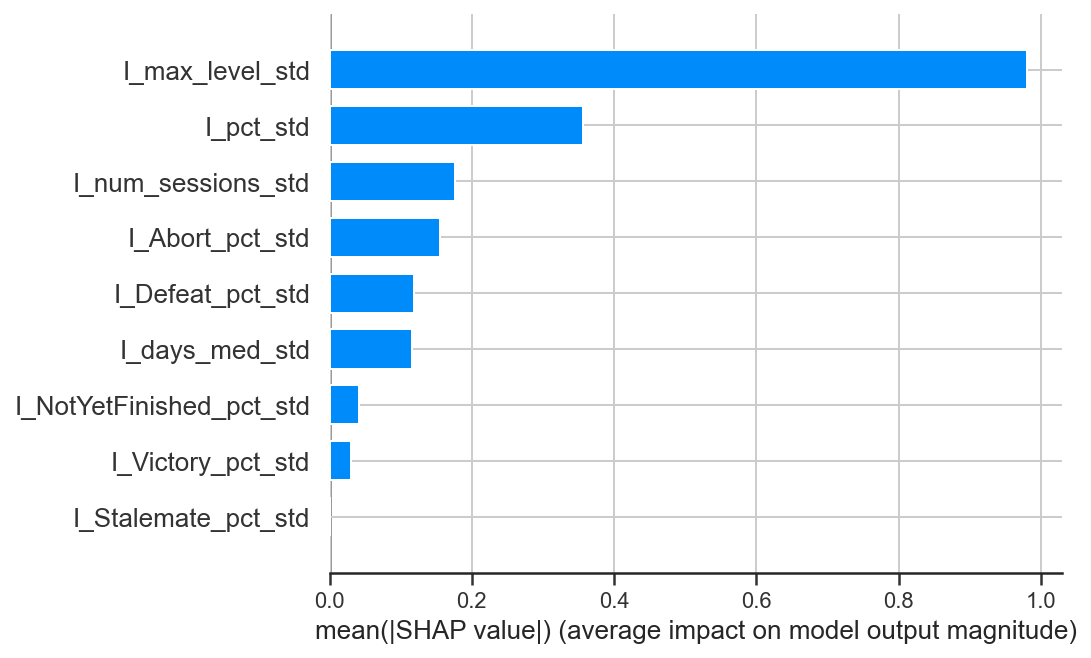

In [103]:
shap.summary_plot(shap_values, df_I, plot_type='bar', show=False)

In [104]:
classifiers = {
    "Logistic Regression": clf_lr,
    "Ridge Regression": clf_ridge,
    "Support Vector Machine":clf_svc,
    "Decision Tree": clf_cart,
    "Random Forest": clf_rf
}


clf_scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'average_precision']

for name, clf in classifiers.items():
    print(f"Evaluating {name}:")
    
    eval_game = cross_validate(clf, df_I, df_v2[cls_type], scoring=clf_scoring, cv=5)
    print(f"Results for {name} on first subset of columns which are related game performance:")
    print_clf_metric(eval_zscore)
    
    print("--------------------------------------------------")

Evaluating Logistic Regression:
Results for Logistic Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7203    0.0577
P             0.7430    0.0758
R             0.7203    0.0577
F1            0.7163    0.0560
AUROC         0.8191    0.0637
AUPRC         0.7913    0.0841
--------------------------------------------------
Evaluating Ridge Regression:
Results for Ridge Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7203    0.0577
P             0.7430    0.0758
R             0.7203    0.0577
F1            0.7163    0.0560
AUROC         0.8191    0.0637
AUPRC         0.7913    0.0841
--------------------------------------------------
Evaluating Support Vector Machine:
Results for Support Vector Machine on first subset of columns which are related game performance:
Metric          Mean 

In [105]:
cls_type = 'ful_adhr_cls' 
RS_game=['RS_num_sessions_std','RS_pct_std','RS_Abort_pct_std','RS_Defeat_pct_std','RS_Victory_pct_std', 'RS_Stalemate_pct_std',
              'RS_NotYetFinished_pct_std','RS_days_med_std','RS_max_level_std']
df_RS = df_v2[RS_game]

In [106]:
model = LogisticRegression(random_state=42)
model.fit(df_RS, df_v2[cls_type])
masker = shap.maskers.Independent(data=df_RS)
explainer = shap.LinearExplainer(model, masker)
shap_values = explainer.shap_values(df_RS)

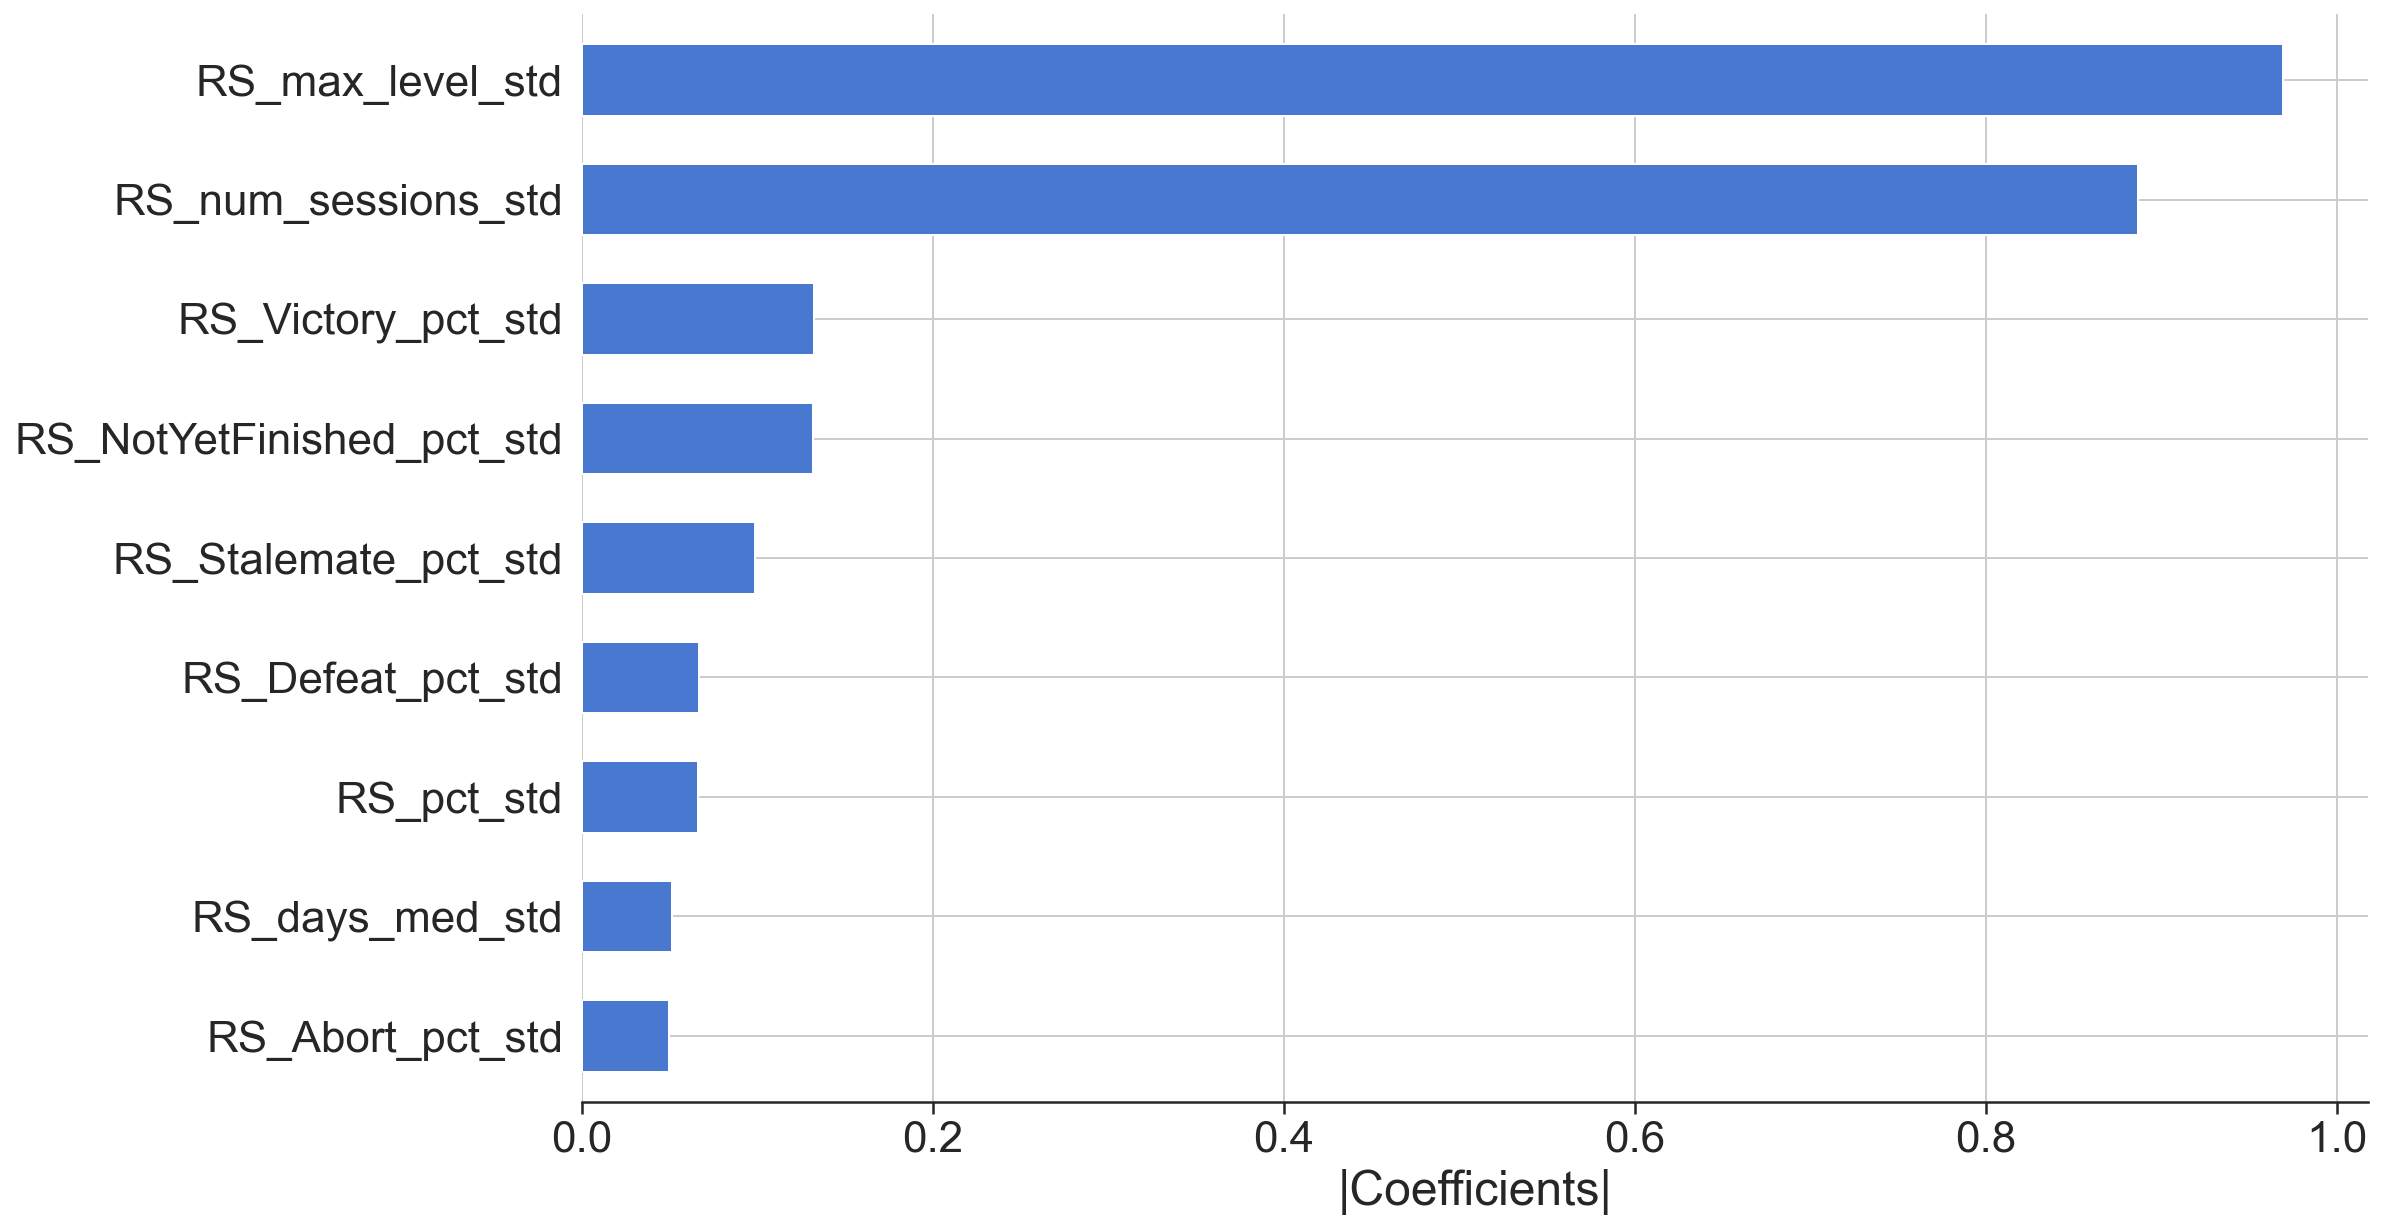

In [107]:
df = pd.DataFrame(data={'variables':list(df_RS.columns), 'coefs':abs(model.coef_).tolist()[0]})
ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

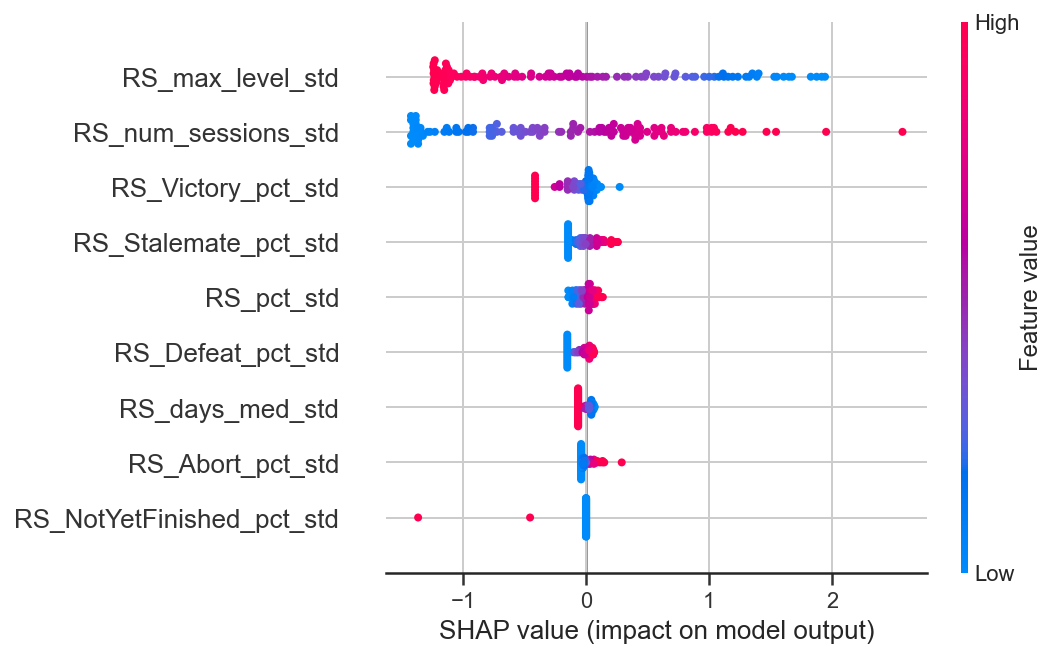

In [108]:
shap.summary_plot(shap_values, df_RS, show=False)

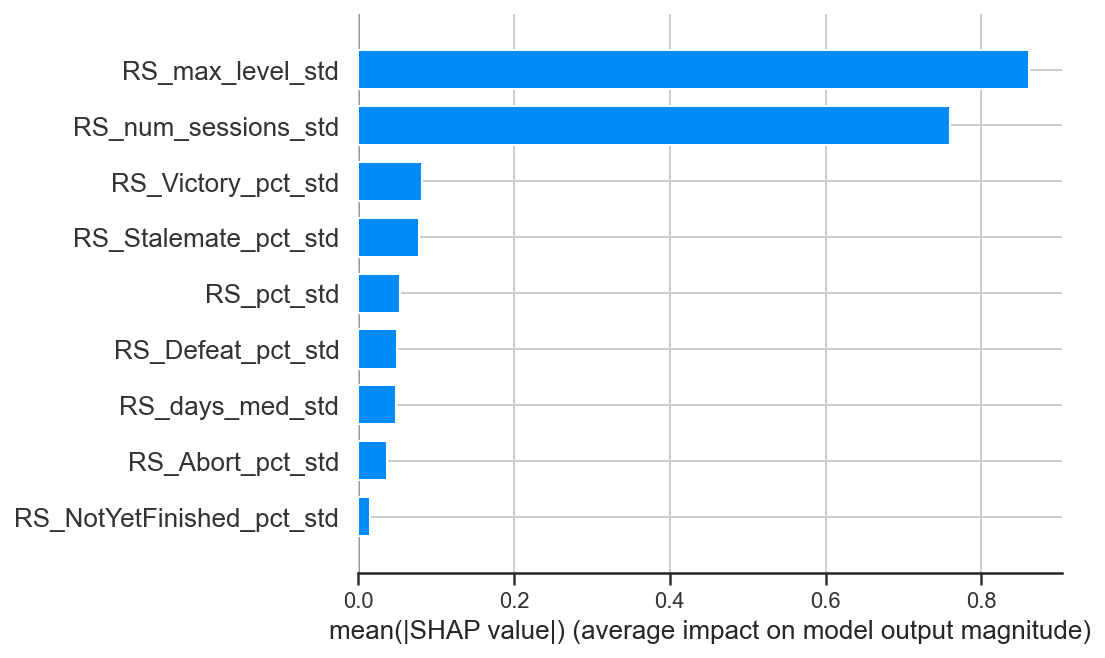

In [109]:
shap.summary_plot(shap_values, df_RS, plot_type='bar', show=False)

In [110]:
classifiers = {
    "Logistic Regression": clf_lr,
    "Ridge Regression": clf_ridge,
    "Support Vector Machine":clf_svc,
    "Decision Tree": clf_cart,
    "Random Forest": clf_rf
}


clf_scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'average_precision']

for name, clf in classifiers.items():
    print(f"Evaluating {name}:")
    
    eval_game = cross_validate(clf, df_RS, df_v2[cls_type], scoring=clf_scoring, cv=5)
    print(f"Results for {name} on first subset of columns which are related game performance:")
    print_clf_metric(eval_game)
    
    print("--------------------------------------------------")

Evaluating Logistic Regression:
Results for Logistic Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7551    0.0811
P             0.7636    0.0827
R             0.7551    0.0811
F1            0.7530    0.0818
AUROC         0.7945    0.0758
AUPRC         0.7689    0.1116
--------------------------------------------------
Evaluating Ridge Regression:
Results for Ridge Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7551    0.0892
P             0.7622    0.0910
R             0.7551    0.0892
F1            0.7534    0.0898
AUROC         0.8106    0.0713
AUPRC         0.7757    0.1071
--------------------------------------------------
Evaluating Support Vector Machine:
Results for Support Vector Machine on first subset of columns which are related game performance:
Metric          Mean 

In [111]:
cls_type = 'ful_adhr_cls' 
PEU_game=['PEU_num_sessions_std','PEU_pct_std','PEU_Abort_pct_std','PEU_Defeat_pct_std','PEU_Victory_pct_std', 'PEU_Stalemate_pct_std',
              'PEU_NotYetFinished_pct_std','PEU_days_med_std','PEU_max_level_std']
df_PEU = df_v2[PEU_game]

In [112]:
model = LogisticRegression(random_state=42)
model.fit(df_PEU, df_v2[cls_type])
masker = shap.maskers.Independent(data=df_PEU)
explainer = shap.LinearExplainer(model, masker)
shap_values = explainer.shap_values(df_PEU)

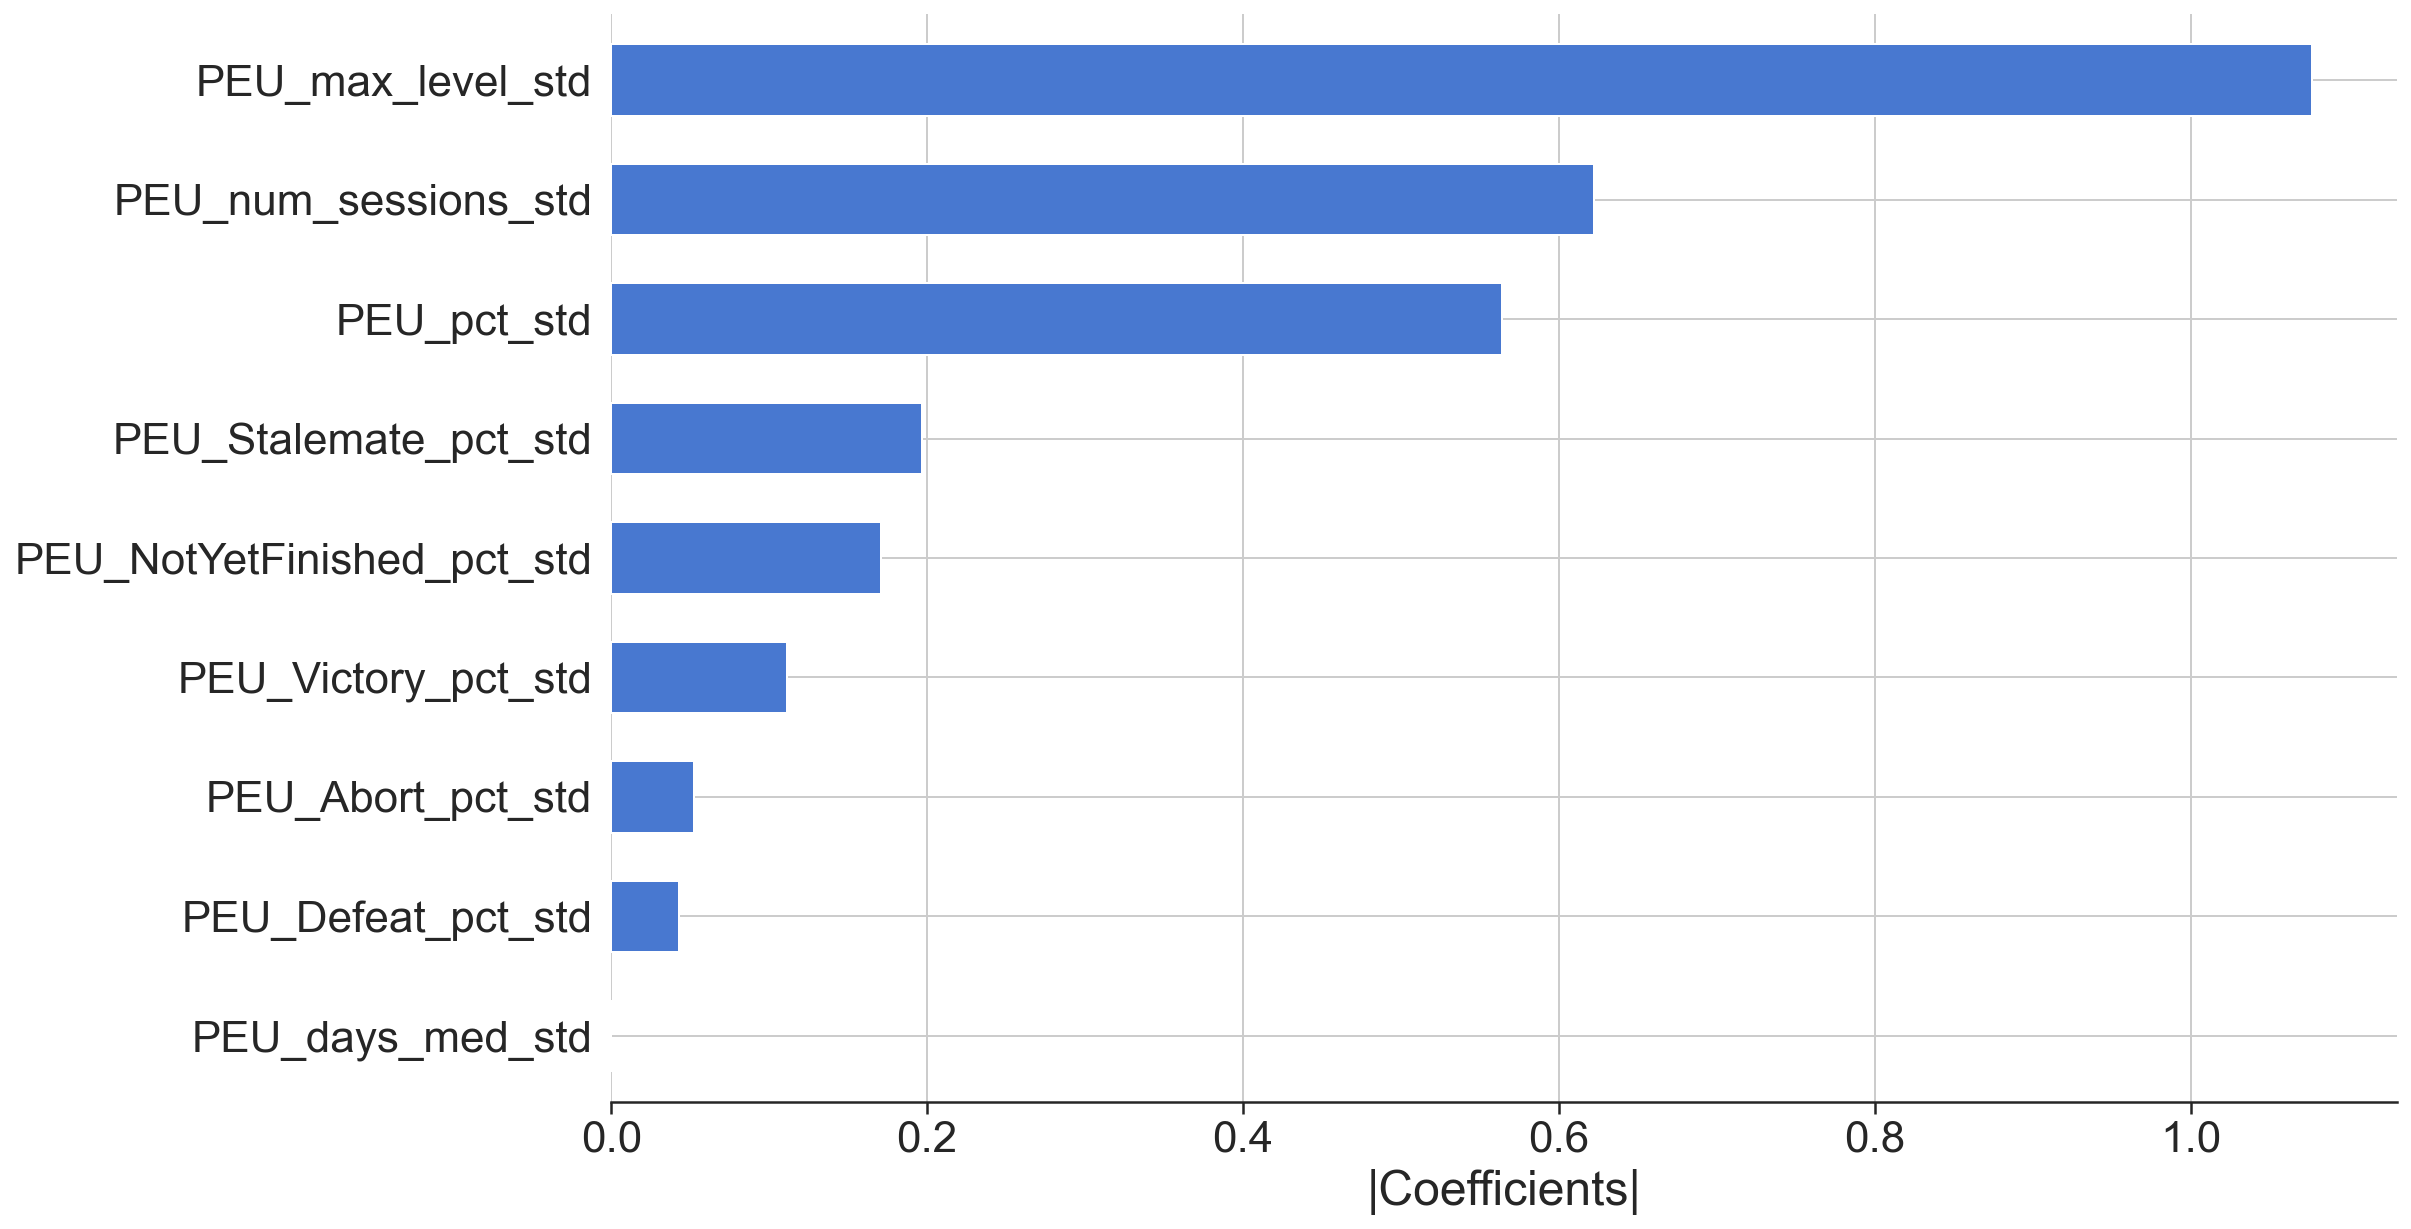

In [113]:
df = pd.DataFrame(data={'variables':list(df_PEU.columns), 'coefs':abs(model.coef_).tolist()[0]})
ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

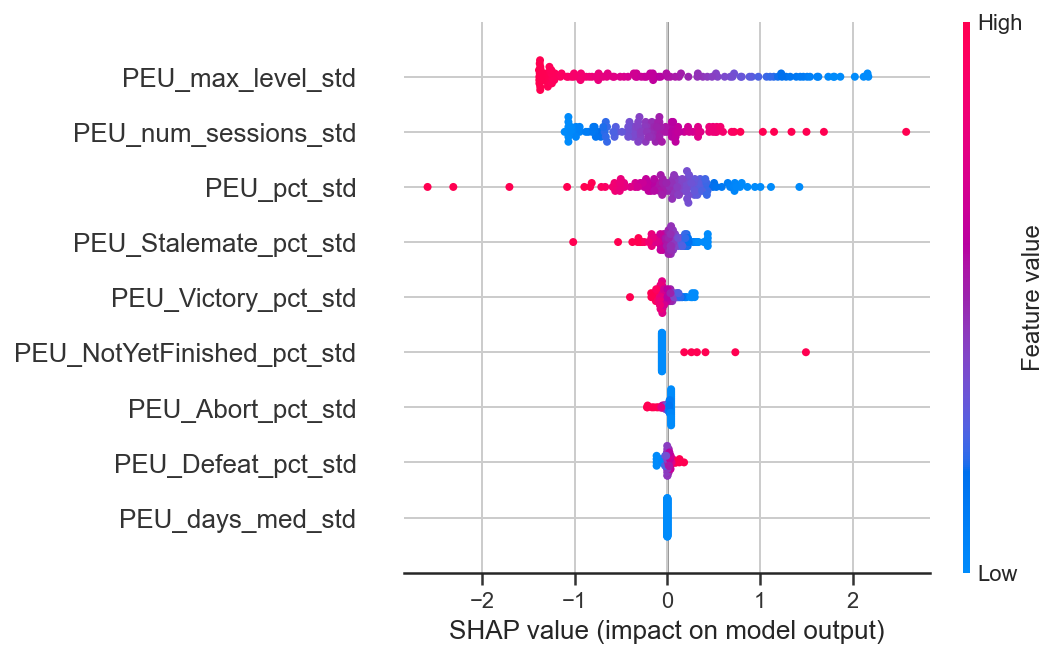

In [114]:
shap.summary_plot(shap_values, df_PEU, show=False)

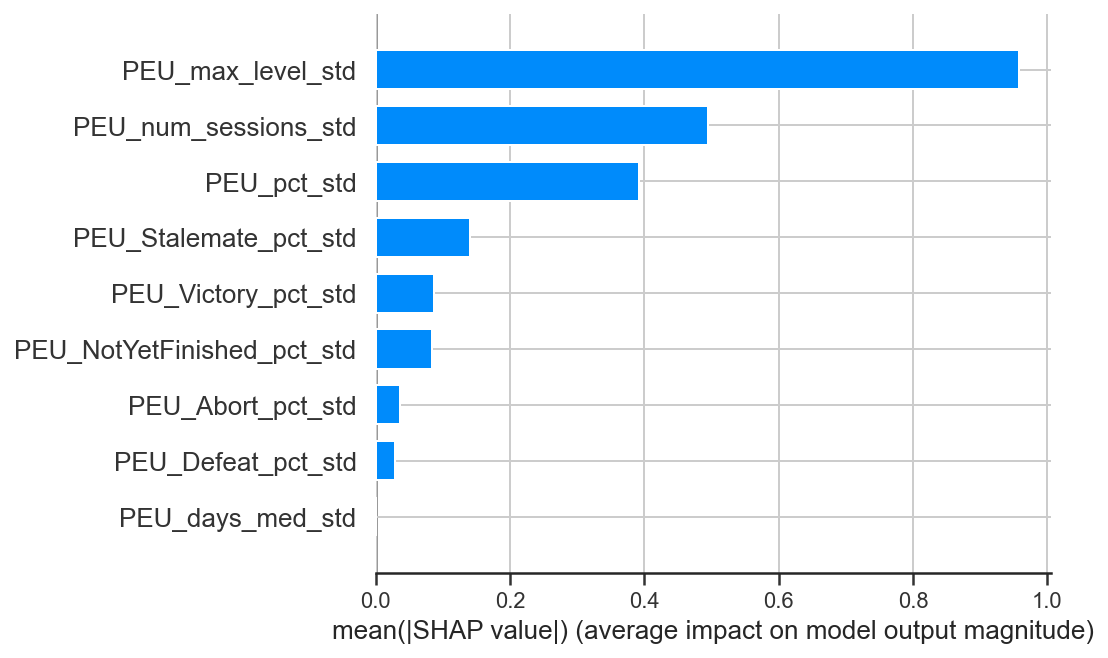

In [115]:
shap.summary_plot(shap_values, df_PEU, plot_type='bar', show=False)

In [116]:
classifiers = {
    "Logistic Regression": clf_lr,
    "Ridge Regression": clf_ridge,
    "Support Vector Machine":clf_svc,
    "Decision Tree": clf_cart,
    "Random Forest": clf_rf
}


clf_scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'average_precision']

for name, clf in classifiers.items():
    print(f"Evaluating {name}:")
    
    eval_game = cross_validate(clf, df_PEU, df_v2[cls_type], scoring=clf_scoring, cv=5)
    print(f"Results for {name} on first subset of columns which are related game performance and:")
    print_clf_metric(eval_game)
    
    print("--------------------------------------------------")

Evaluating Logistic Regression:
Results for Logistic Regression on first subset of columns which are related game performance and:
Metric          Mean       Std
------------------------------
ACCU          0.7116    0.0831
P             0.7190    0.0853
R             0.7116    0.0831
F1            0.7063    0.0866
AUROC         0.8047    0.0569
AUPRC         0.7562    0.0879
--------------------------------------------------
Evaluating Ridge Regression:
Results for Ridge Regression on first subset of columns which are related game performance and:
Metric          Mean       Std
------------------------------
ACCU          0.7116    0.0831
P             0.7190    0.0853
R             0.7116    0.0831
F1            0.7063    0.0866
AUROC         0.8047    0.0569
AUPRC         0.7548    0.0881
--------------------------------------------------
Evaluating Support Vector Machine:
Results for Support Vector Machine on first subset of columns which are related game performance and:
Metric   

In [117]:
cls_type = 'ful_adhr_cls' 
AU_game=['AU_num_sessions_std','AU_pct_std','AU_Abort_pct_std','AU_Defeat_pct_std','AU_Victory_pct_std', 'AU_Stalemate_pct_std',
              'AU_NotYetFinished_pct_std','AU_days_med_std','AU_max_level_std']
df_AU = df_v2[AU_game]

In [118]:
model = LogisticRegression(random_state=42)
model.fit(df_AU, df_v2[cls_type])
masker = shap.maskers.Independent(data=df_AU)
explainer = shap.LinearExplainer(model, masker)
shap_values = explainer.shap_values(df_AU)

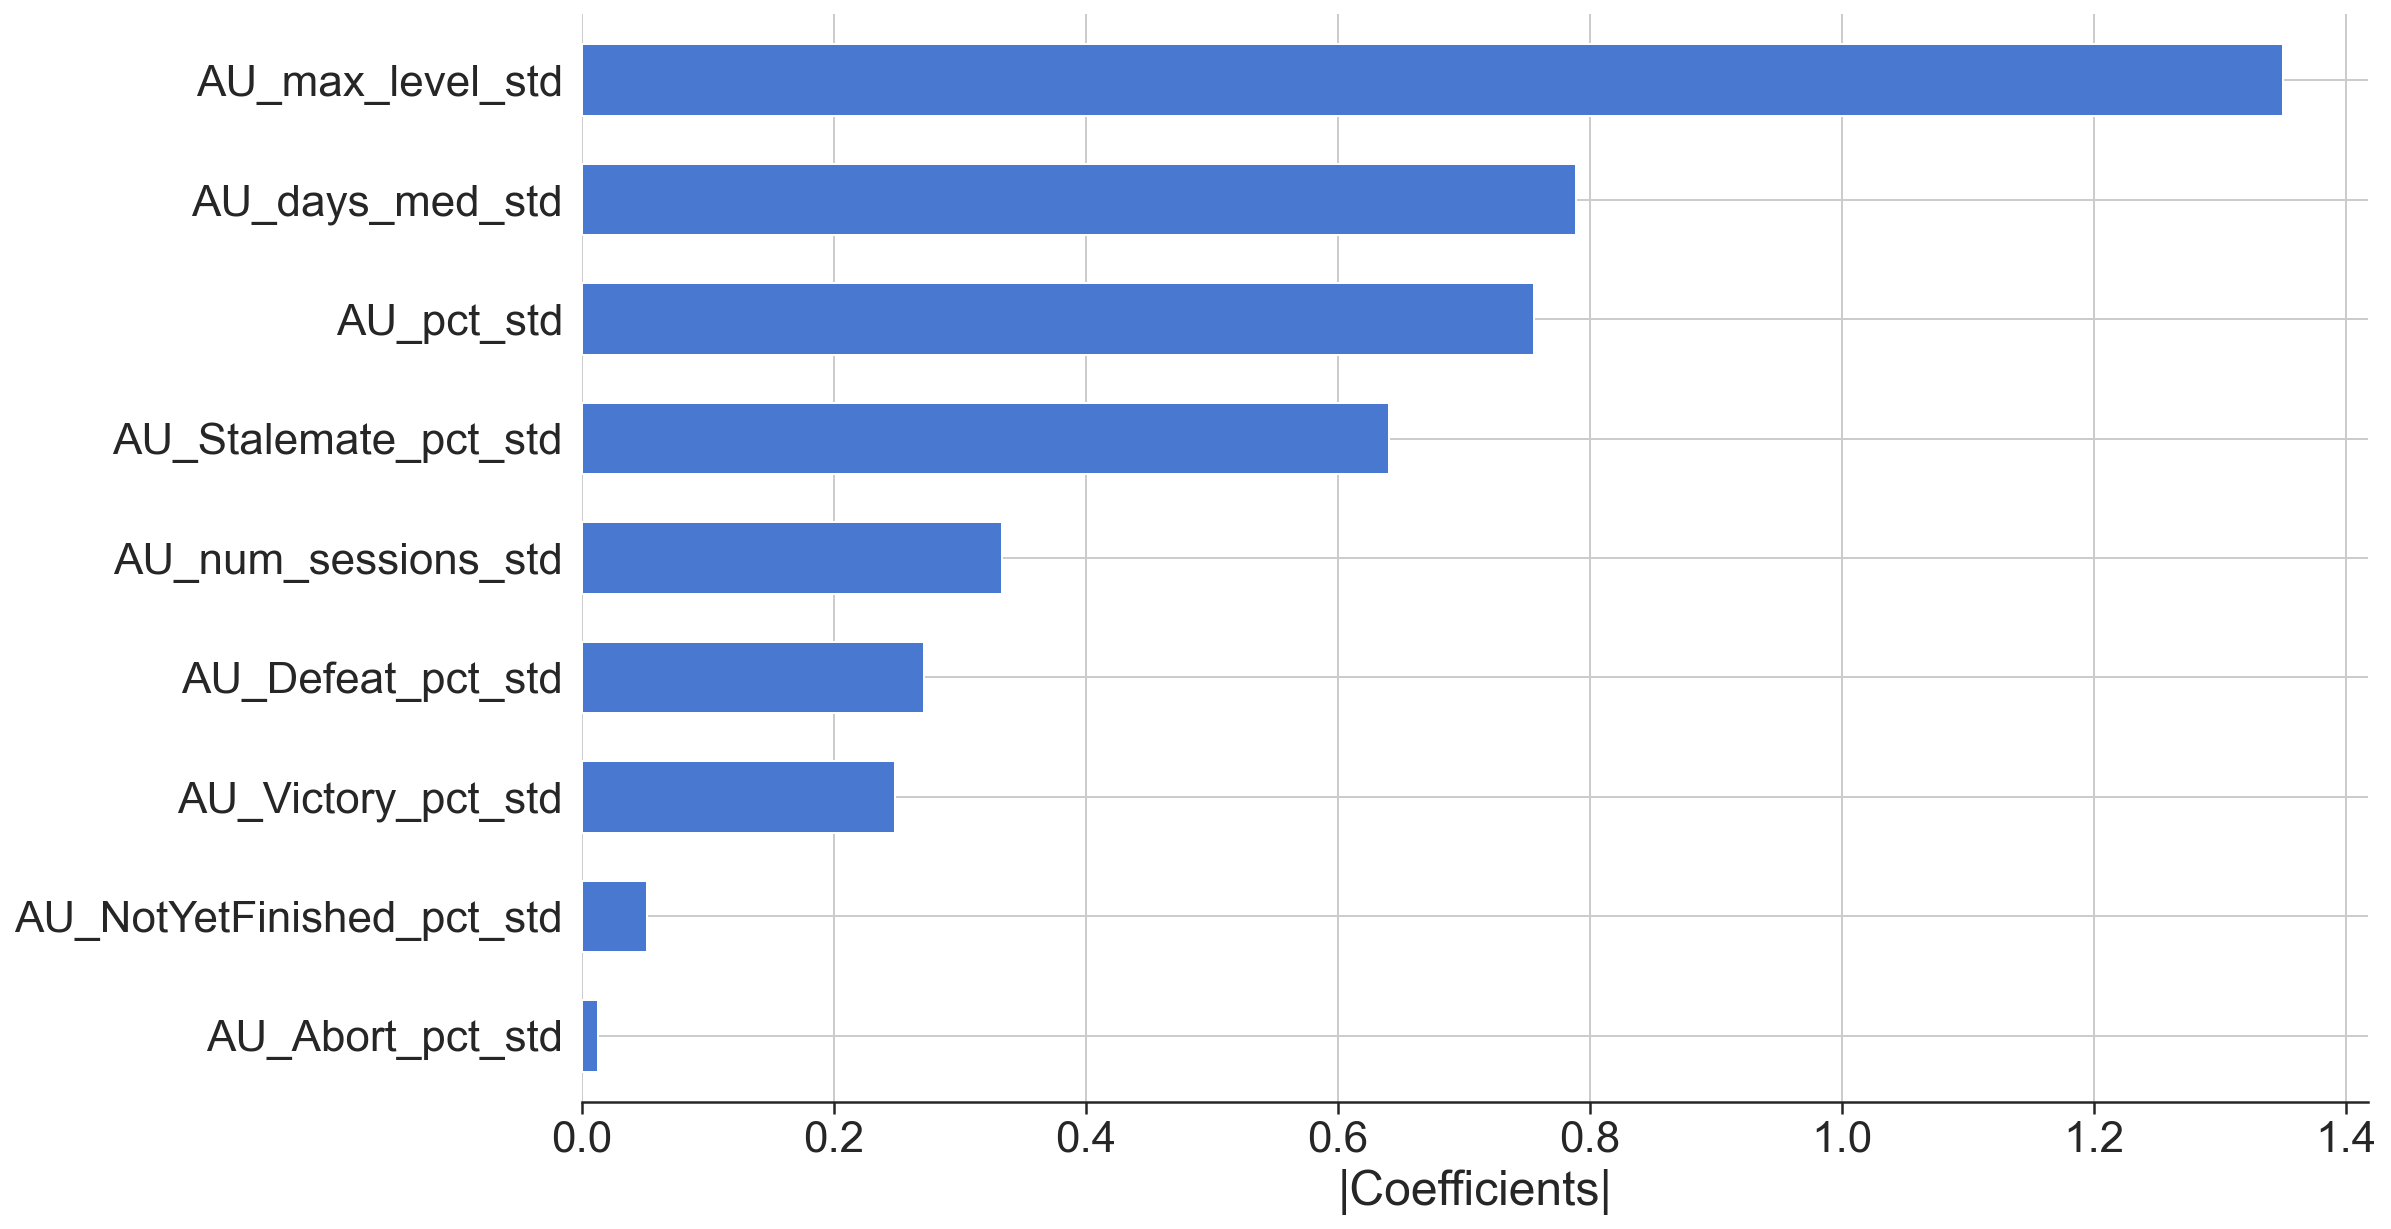

In [119]:
df = pd.DataFrame(data={'variables':list(df_AU.columns), 'coefs':abs(model.coef_).tolist()[0]})
ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

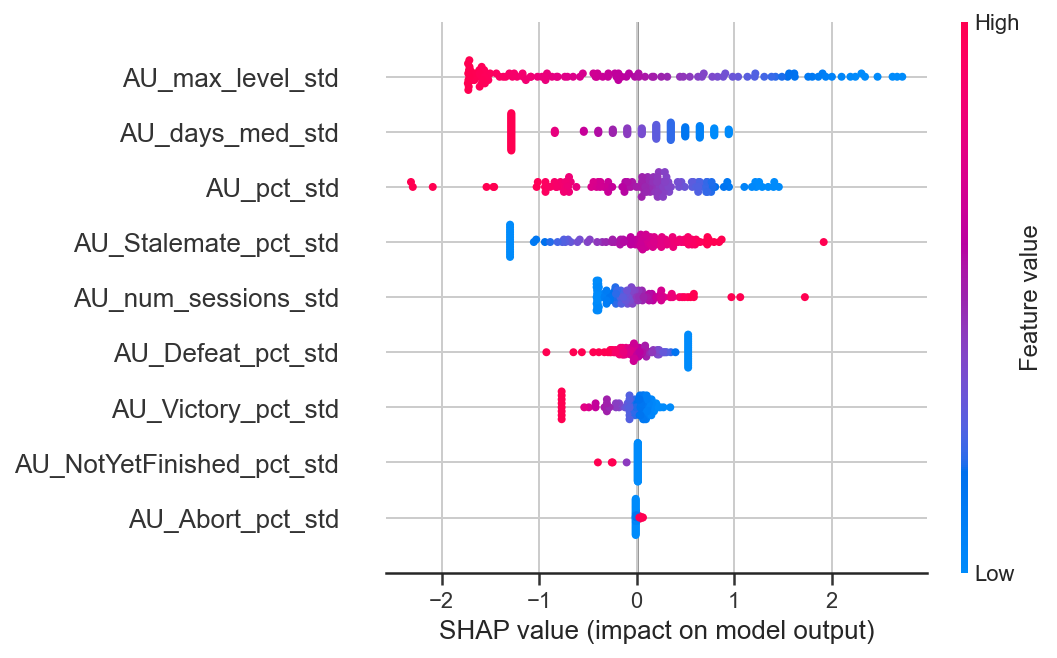

In [120]:
shap.summary_plot(shap_values, df_AU, show=False)

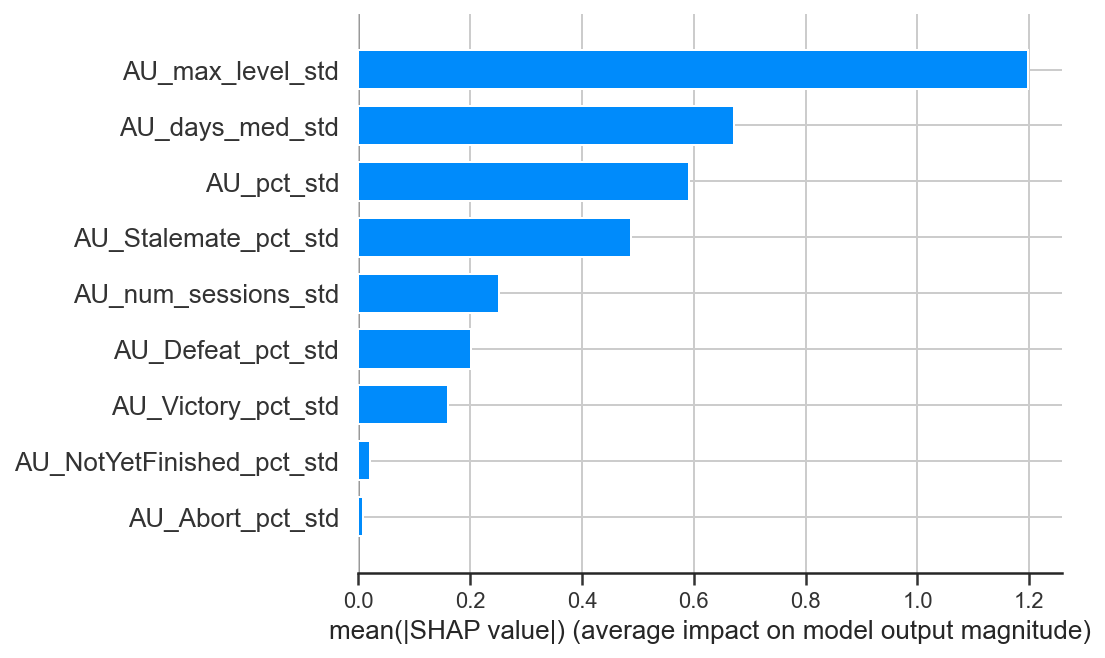

In [121]:
shap.summary_plot(shap_values, df_AU, plot_type='bar', show=False)

In [122]:
classifiers = {
    "Logistic Regression": clf_lr,
    "Ridge Regression": clf_ridge,
    "Support Vector Machine":clf_svc,
    "Decision Tree": clf_cart,
    "Random Forest": clf_rf
}


clf_scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'average_precision']

for name, clf in classifiers.items():
    print(f"Evaluating {name}:")
    
    eval_game = cross_validate(clf, df_AU, df_v2[cls_type], scoring=clf_scoring, cv=5)
    print(f"Results for {name} on first subset of columns which are related game performance:")
    print_clf_metric(eval_game)
    
    print("--------------------------------------------------")

Evaluating Logistic Regression:
Results for Logistic Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7547    0.0719
P             0.7632    0.0801
R             0.7547    0.0719
F1            0.7532    0.0721
AUROC         0.8502    0.0778
AUPRC         0.8495    0.0813
--------------------------------------------------
Evaluating Ridge Regression:
Results for Ridge Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7714    0.0688
P             0.7810    0.0765
R             0.7714    0.0688
F1            0.7692    0.0694
AUROC         0.8556    0.0821
AUPRC         0.8532    0.0872
--------------------------------------------------
Evaluating Support Vector Machine:
Results for Support Vector Machine on first subset of columns which are related game performance:
Metric          Mean 

In [123]:
cls_type = 'ful_adhr_cls' 
TJ_game=['TJ_num_sessions_std','TJ_pct_std','TJ_Abort_pct_std','TJ_Defeat_pct_std','TJ_Victory_pct_std', 'TJ_Stalemate_pct_std',
              'TJ_NotYetFinished_pct_std','TJ_days_med_std','TJ_max_level_std']
df_TJ = df_v2[TJ_game]

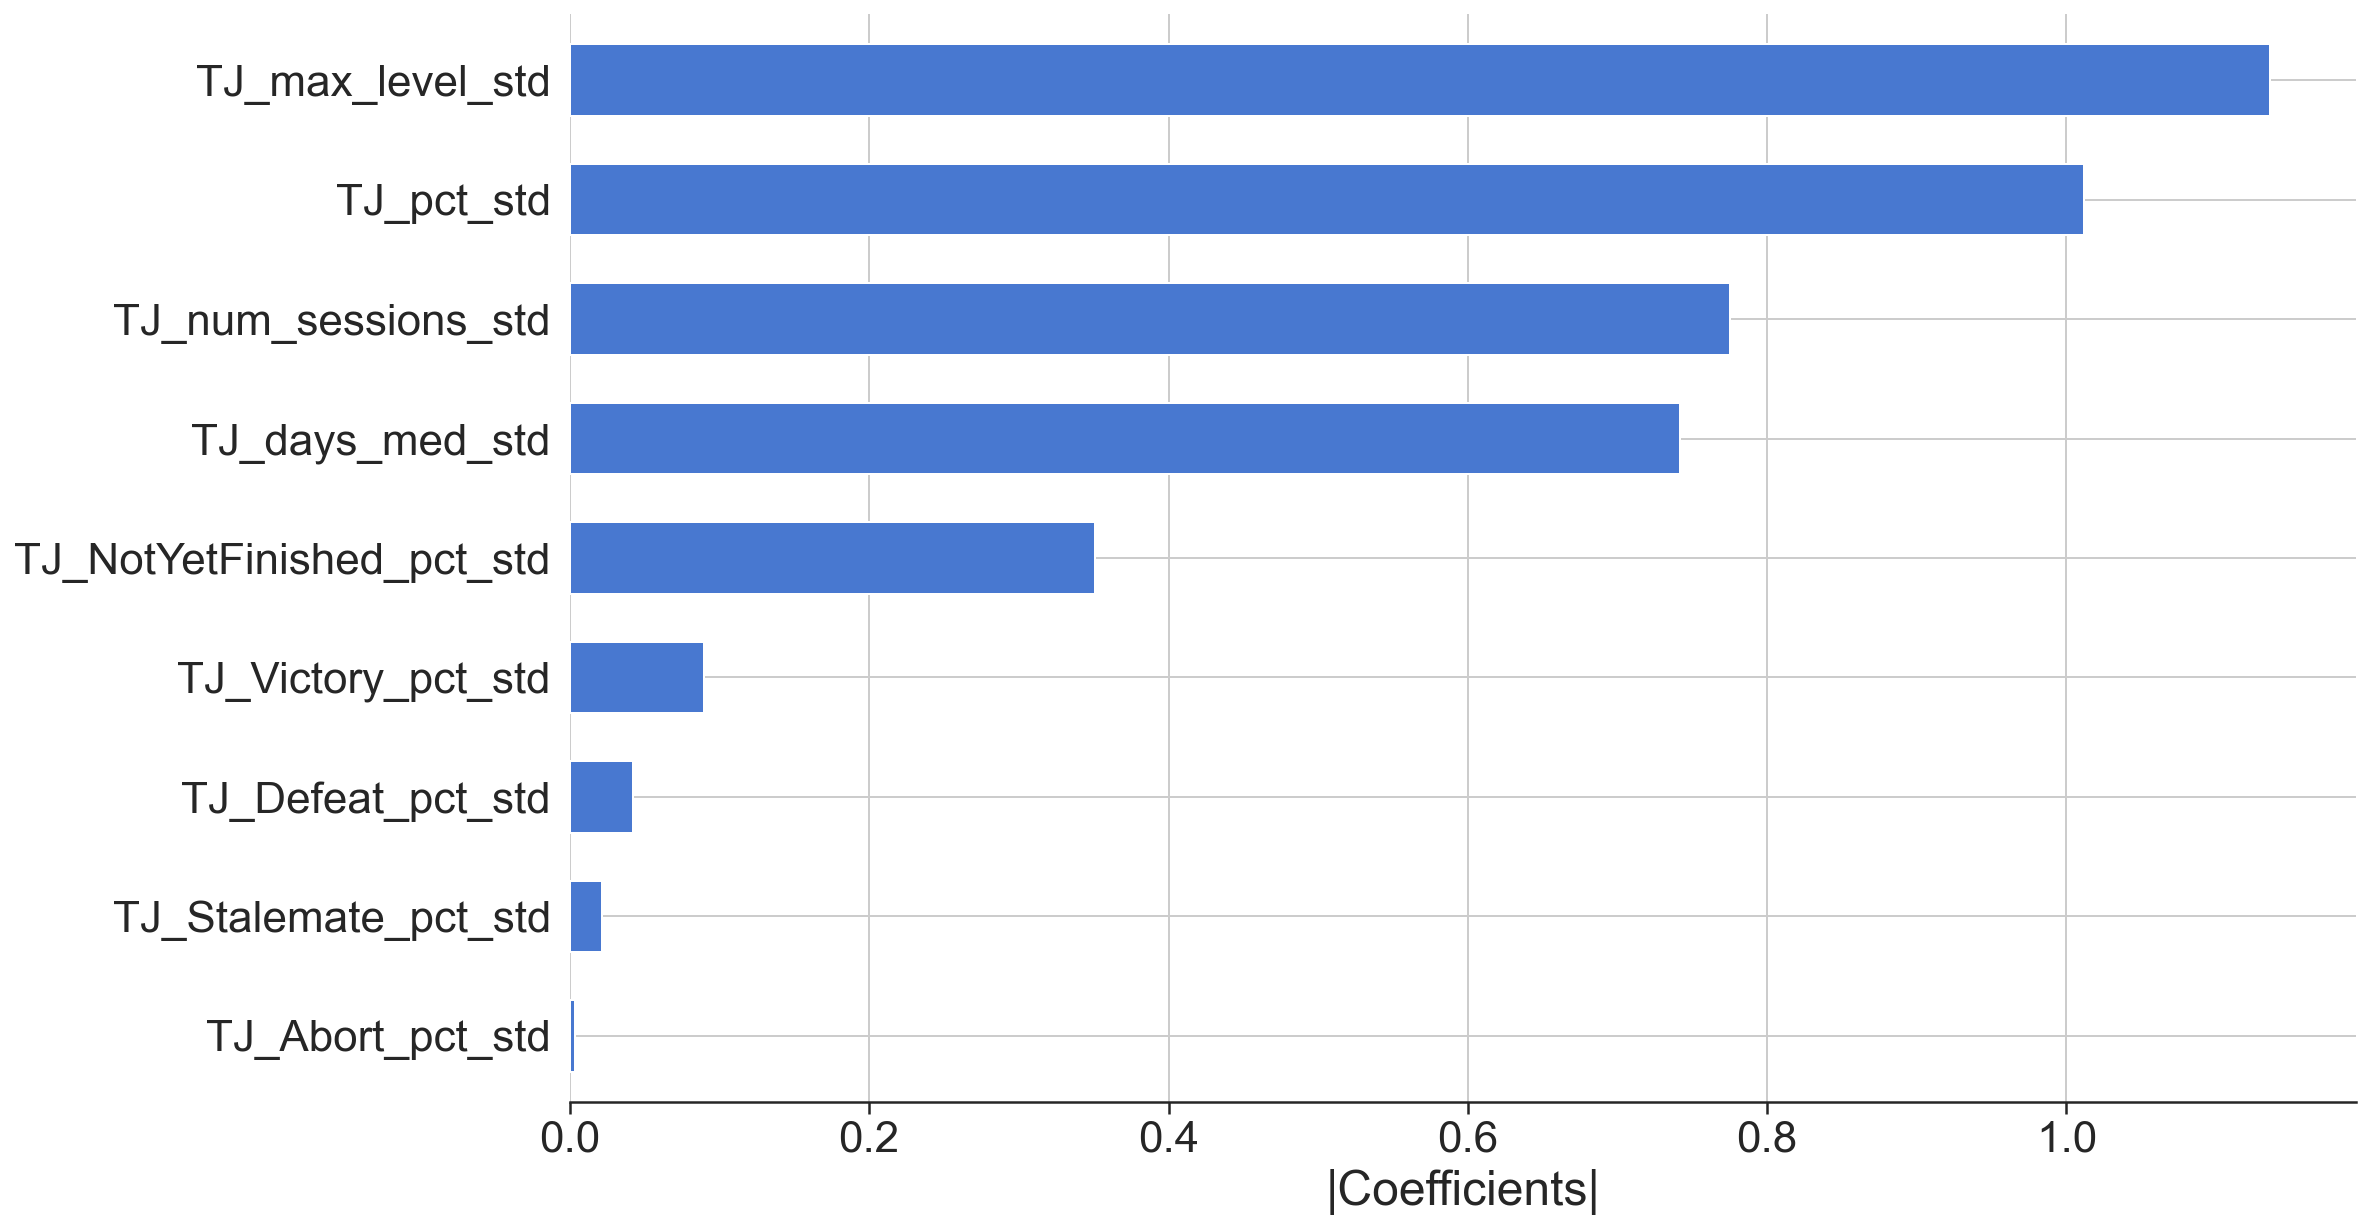

In [124]:
model = LogisticRegression(random_state=42)
model.fit(df_TJ, df_v2[cls_type])
masker = shap.maskers.Independent(data=df_TJ)
explainer = shap.LinearExplainer(model, masker)
shap_values = explainer.shap_values(df_TJ)

df = pd.DataFrame(data={'variables':list(df_TJ.columns), 'coefs':abs(model.coef_).tolist()[0]})
ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

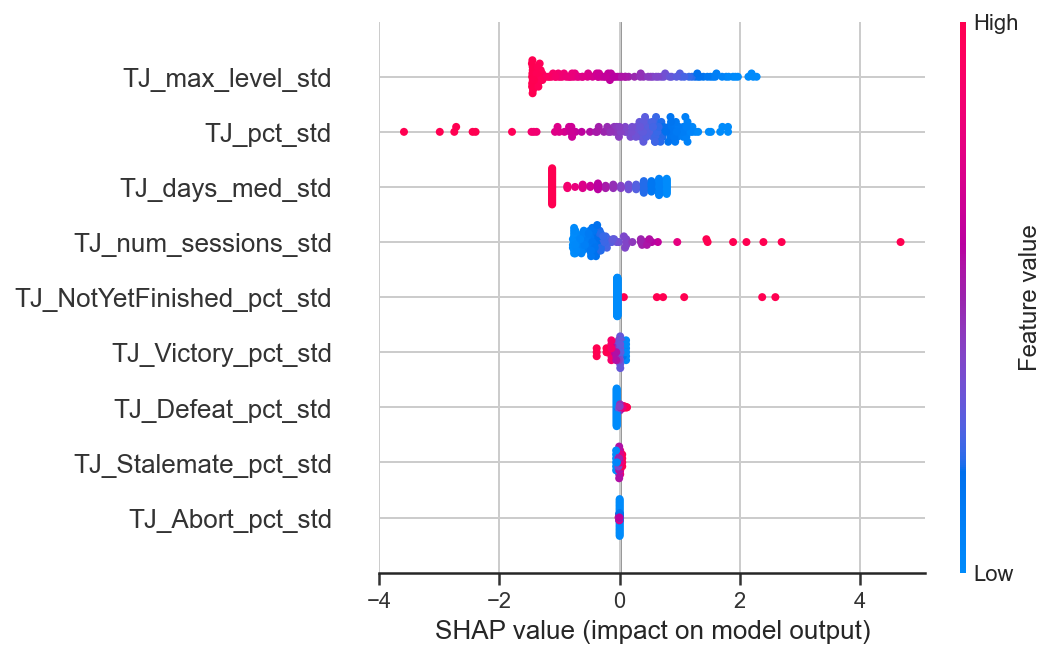

In [125]:
shap.summary_plot(shap_values, df_TJ, show=False)

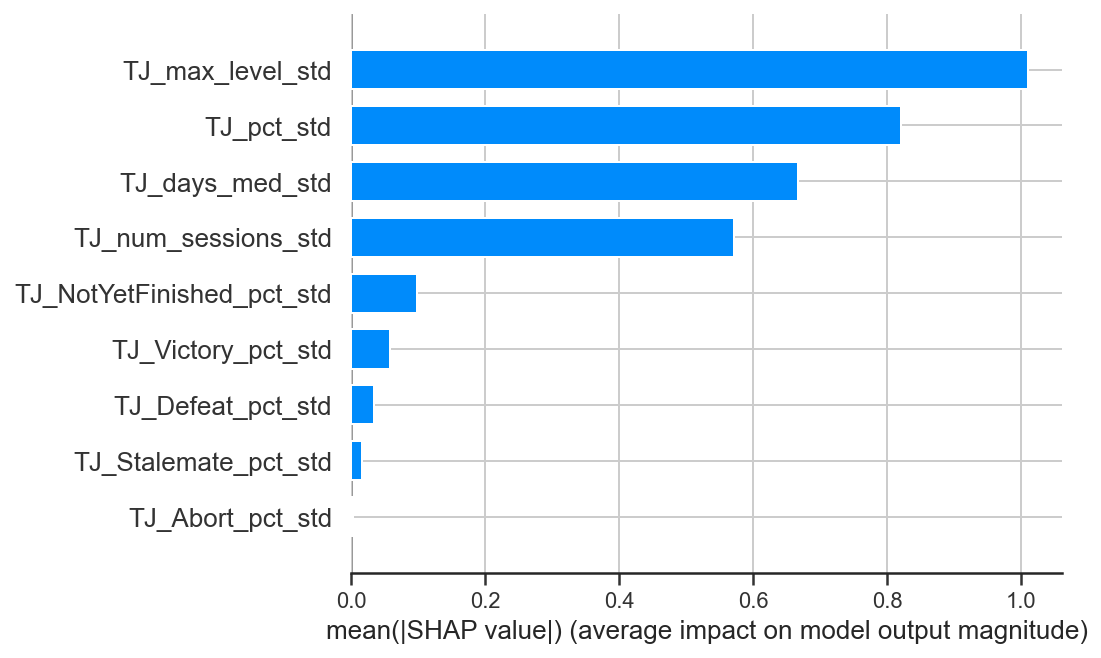

In [126]:
shap.summary_plot(shap_values, df_TJ, plot_type='bar', show=False)

In [127]:
classifiers = {
    "Logistic Regression": clf_lr,
    "Ridge Regression": clf_ridge,
    "Support Vector Machine":clf_svc,
    "Decision Tree": clf_cart,
    "Random Forest": clf_rf
}

clf_scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'average_precision']

for name, clf in classifiers.items():
    print(f"Evaluating {name}:")
    
    eval_game = cross_validate(clf, df_TJ, df_v2[cls_type], scoring=clf_scoring, cv=5)
    print(f"Results for {name} on first subset of columns which are related game performance:")
    print_clf_metric(eval_game)
    
    print("--------------------------------------------------")

Evaluating Logistic Regression:
Results for Logistic Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7540    0.1438
P             0.7574    0.1464
R             0.7540    0.1438
F1            0.7537    0.1443
AUROC         0.8382    0.1327
AUPRC         0.8386    0.1346
--------------------------------------------------
Evaluating Ridge Regression:
Results for Ridge Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7457    0.1587
P             0.7500    0.1584
R             0.7457    0.1587
F1            0.7449    0.1595
AUROC         0.8372    0.1328
AUPRC         0.8378    0.1360
--------------------------------------------------
Evaluating Support Vector Machine:
Results for Support Vector Machine on first subset of columns which are related game performance:
Metric          Mean 

In [128]:
cls_type = 'ful_adhr_cls' 
SD_game=['SD_num_sessions_std','SD_pct_std','SD_Abort_pct_std','SD_Defeat_pct_std','SD_Victory_pct_std', 'SD_Stalemate_pct_std',
              'SD_NotYetFinished_pct_std','SD_days_med_std','SD_max_level_std']
df_SD = df_v2[SD_game]

In [129]:
model.fit(df_SD, df_v2[cls_type])
masker = shap.maskers.Independent(data=df_SD)
explainer = shap.LinearExplainer(model, masker)
shap_values = explainer.shap_values(df_SD)

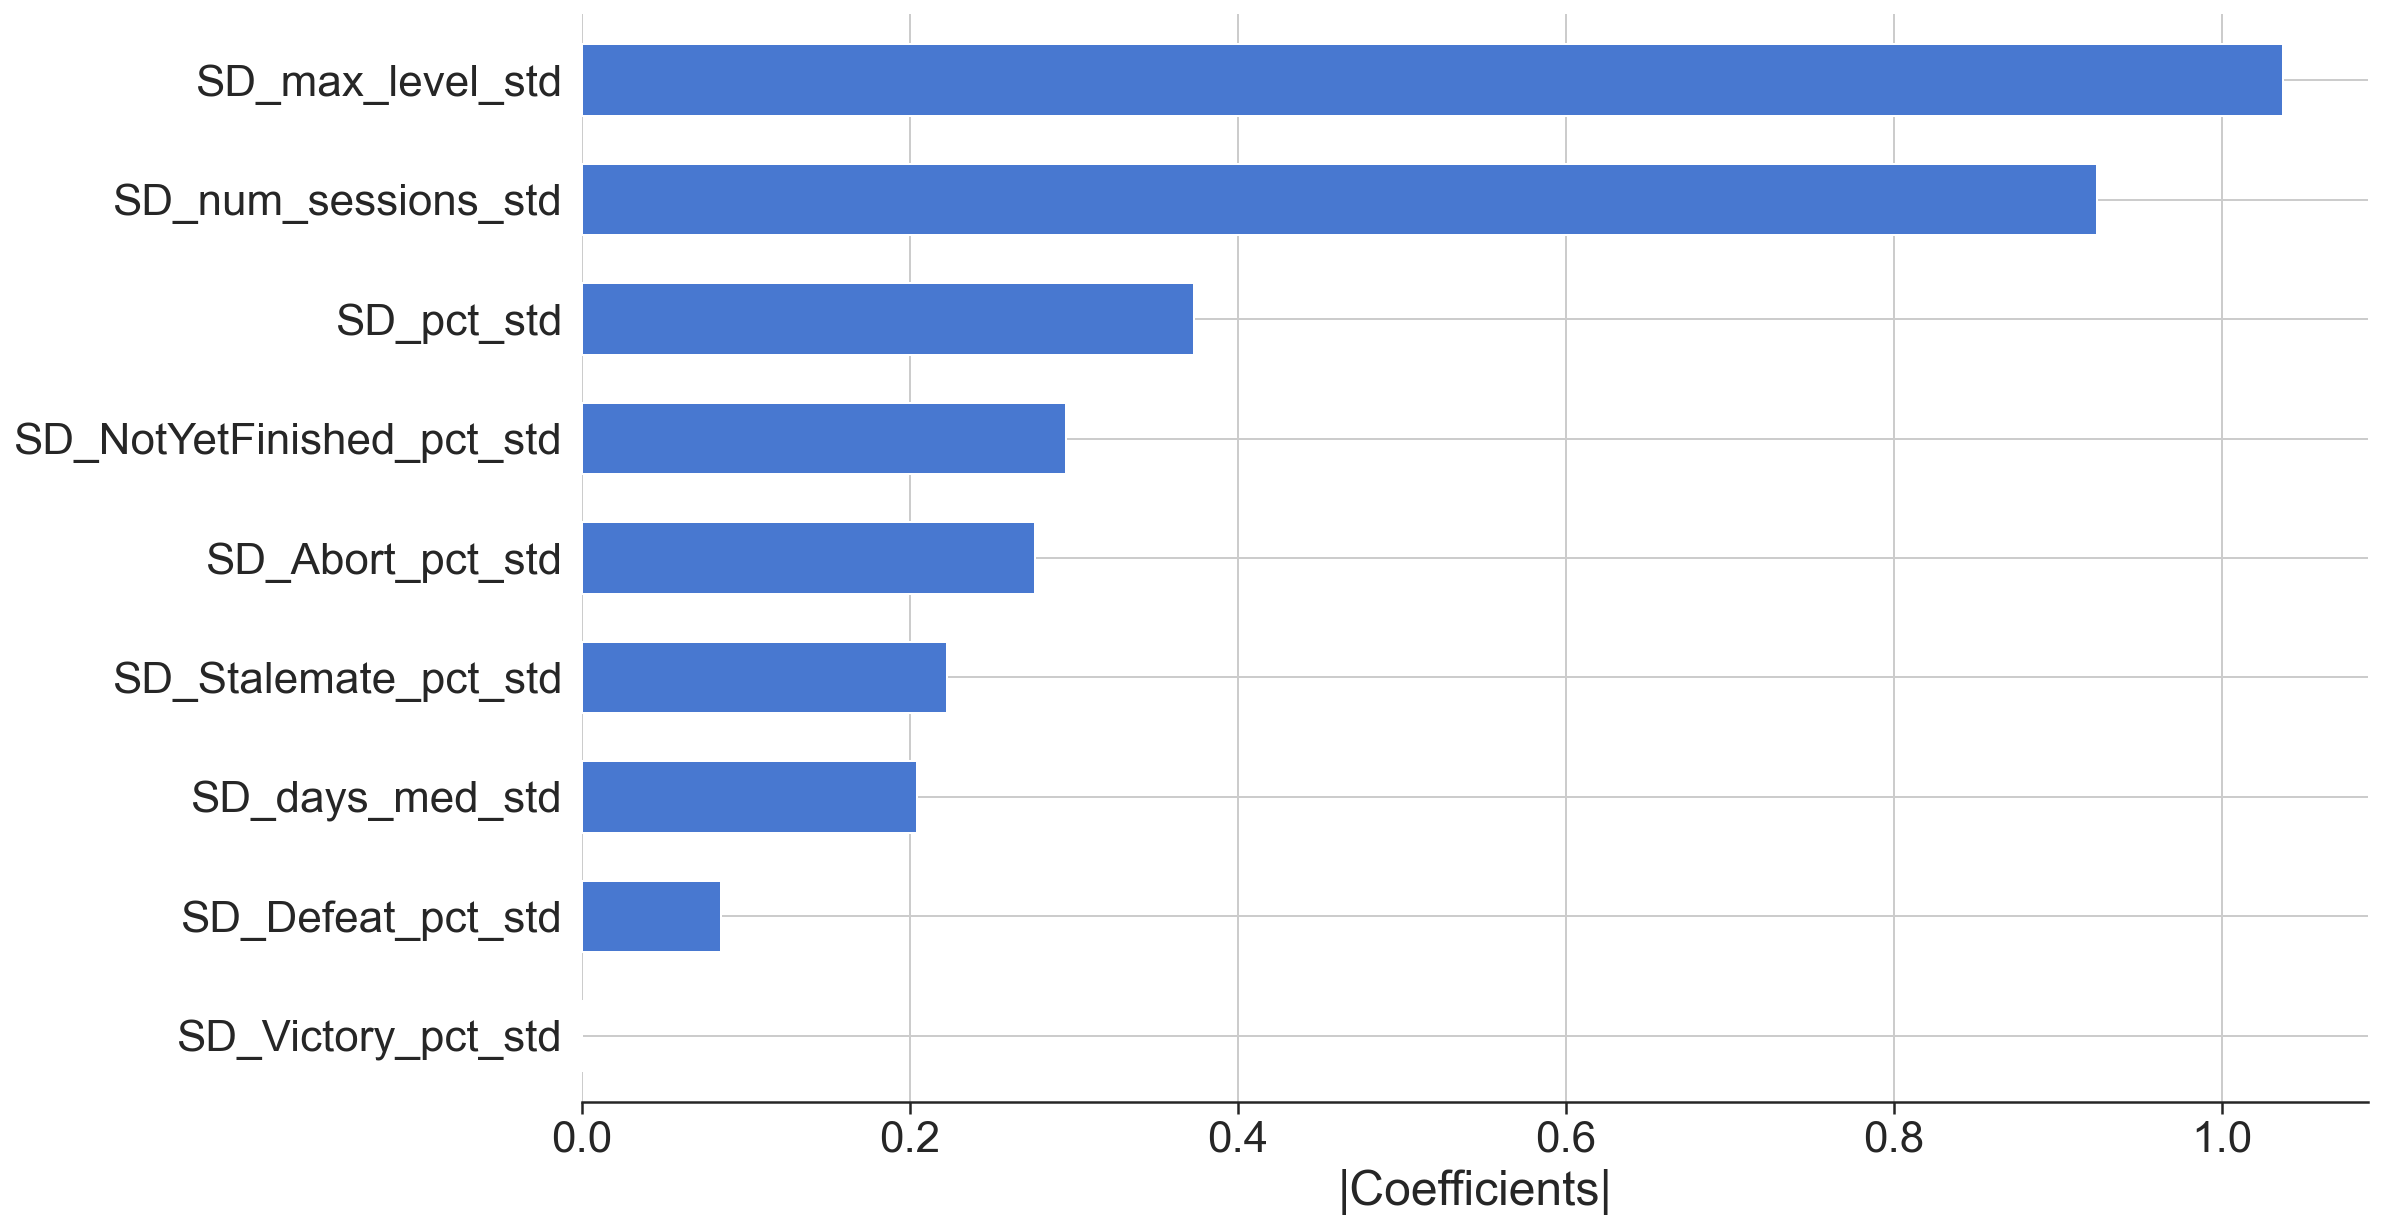

In [130]:
df = pd.DataFrame(data={'variables':list(df_SD.columns), 'coefs':abs(model.coef_).tolist()[0]})
ax = df.sort_values(by='coefs').plot.barh(x='variables', y='coefs', legend=False, width=.6)
ax.set(xlabel = "|Coefficients|", ylabel = "")
ax.tick_params(left=False)
sns.despine(left=True);

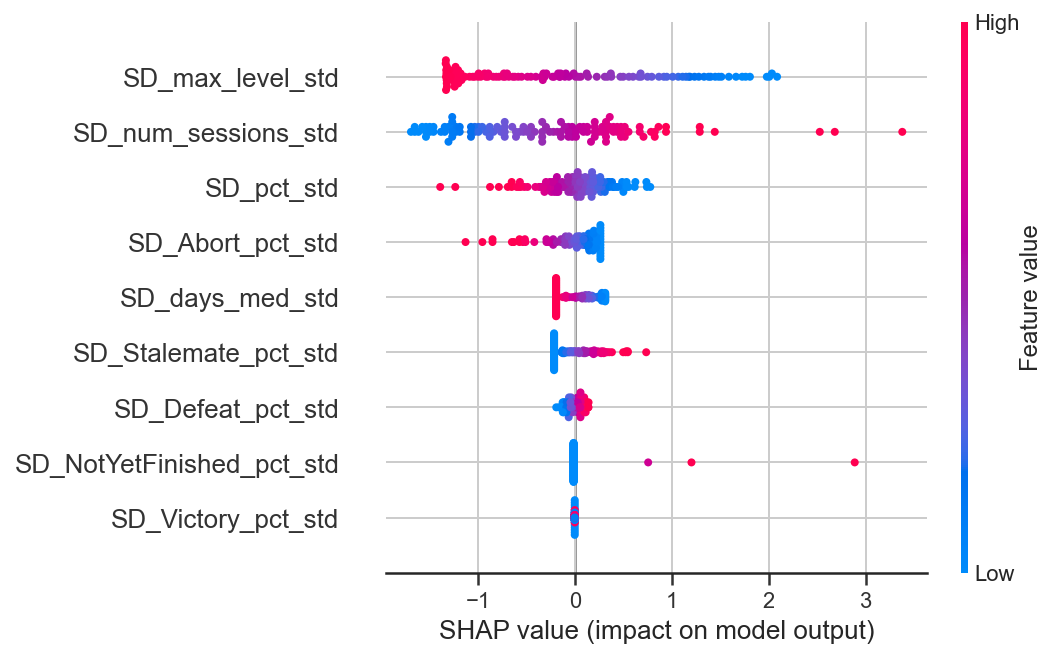

In [131]:
shap.summary_plot(shap_values, df_SD, show=False)

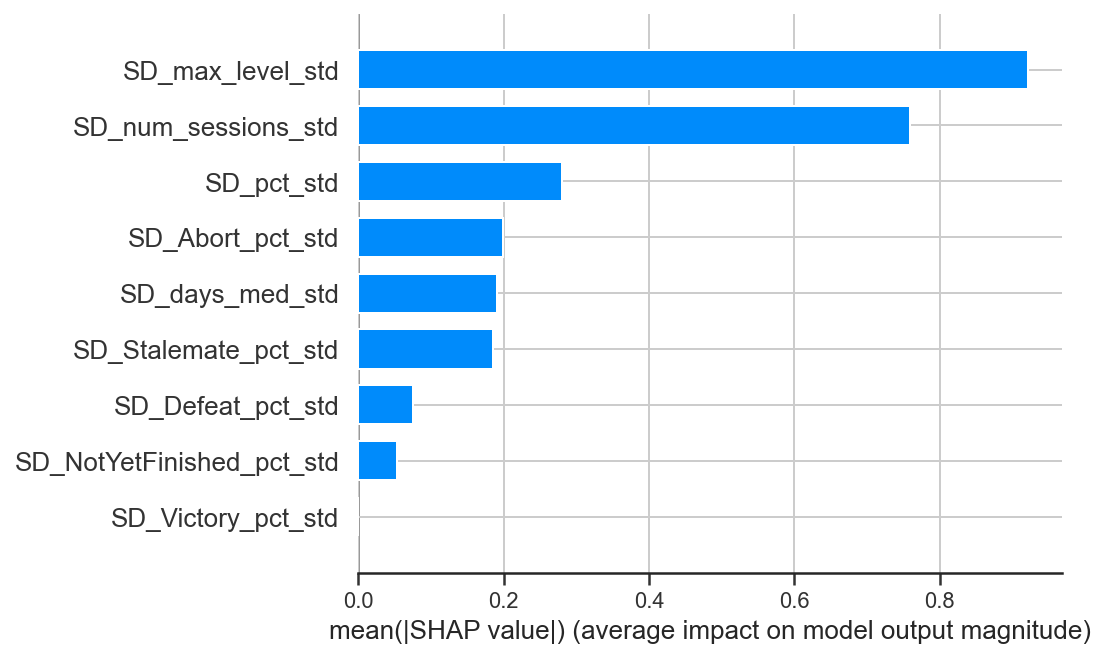

In [132]:
shap.summary_plot(shap_values, df_SD, plot_type='bar', show=False)

In [133]:
classifiers = {
    "Logistic Regression": clf_lr,
    "Ridge Regression": clf_ridge,
    "Support Vector Machine":clf_svc,
    "Decision Tree": clf_cart,
    "Random Forest": clf_rf
}


clf_scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'average_precision']

for name, clf in classifiers.items():
    print(f"Evaluating {name}:")
    
    eval_game = cross_validate(clf, df_SD, df_v2[cls_type], scoring=clf_scoring, cv=5)
    print(f"Results for {name} on first subset of columns which are related game performance:")
    print_clf_metric(eval_game)
    
    print("--------------------------------------------------")

Evaluating Logistic Regression:
Results for Logistic Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7214    0.1011
P             0.7231    0.1005
R             0.7214    0.1011
F1            0.7205    0.1017
AUROC         0.8035    0.0840
AUPRC         0.7703    0.1310
--------------------------------------------------
Evaluating Ridge Regression:
Results for Ridge Regression on first subset of columns which are related game performance:
Metric          Mean       Std
------------------------------
ACCU          0.7301    0.1001
P             0.7302    0.1003
R             0.7301    0.1001
F1            0.7297    0.1005
AUROC         0.8020    0.0806
AUPRC         0.7696    0.1284
--------------------------------------------------
Evaluating Support Vector Machine:
Results for Support Vector Machine on first subset of columns which are related game performance:
Metric          Mean 

## Soft Voting Ensemble Modeling
- Hard Voting. Predict the class with the largest sum of votes from models
- Soft Voting. Predict the class with the largest summed probability from models.

In [134]:
cls_type = 'min_adhr_cls' 
 
per_zscore=['z_hopkins_delayed','z_rey_delayed','z_gse','z_tse','z_techreadiness']

per_compscore=['composite_selfefficacy',
 'composite_obj_cognition_memory_delayedrecall',
 'composite_obj_cognition_memory_immediate_and_delayed_recall']

SD=['SD_num_sessions_std','SD_pct_std','SD_Abort_pct_std','SD_Defeat_pct_std','SD_Victory_pct_std', 'SD_Stalemate_pct_std',
      'SD_NotYetFinished_pct_std','SD_days_med_std','SD_max_level_std']
AU=['AU_num_sessions','AU_pct','AU_Abort_pct','AU_Defeat_pct','AU_Victory_pct', 'AU_Stalemate_pct',
      'AU_NotYetFinished_pct','AU_days_med','AU_max_level']
SR=['SR_num_sessions','SR_pct','SR_Abort_pct','SR_Defeat_pct','SR_Victory_pct', 'SR_Stalemate_pct',
      'SR_NotYetFinished_pct','SR_days_med','SR_max_level']

In [135]:
from sklearn.model_selection import StratifiedKFold
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize arrays to store metrics
accuracies, precisions, recalls, f1s, aucs = [], [], [], [], []

# Use the target variable for splitting
Y = df_v2[cls_type]  
results = []

for train_index, test_index in kf.split(df_v2, Y):
    X_A_train, X_A_test = df_v2[SR].iloc[train_index], df_v2[SR].iloc[test_index]
    X_B_train, X_B_test = df_v2[AU].iloc[train_index], df_v2[AU].iloc[test_index]
    X_C_train, X_C_test = df_v2[SD].iloc[train_index], df_v2[SD].iloc[test_index]
    X_D_train, X_D_test = df_v2[per_compscore].iloc[train_index], df_v2[per_compscore].iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Train models
    model_a = LogisticRegression(random_state=42).fit(X_A_train, Y_train)
    model_b = LogisticRegression(random_state=42).fit(X_B_train, Y_train)
    model_c = LogisticRegression(random_state=42).fit(X_C_train, Y_train)
    model_d =LogisticRegression(random_state=42).fit(X_D_train, Y_train)

    # Predict probabilities and perform soft voting
    proba_a = model_a.predict_proba(X_A_test)
    proba_b = model_b.predict_proba(X_B_test)
    proba_c = model_c.predict_proba(X_C_test)
    proba_d = model_d.predict_proba(X_D_test)
    avg_proba = (proba_a + proba_b+proba_c + proba_d) / 4
    predictions = np.argmax(avg_proba, axis=1)

    # Store results for this fold
    results.append({
        'Fold': len(results) + 1,
        'Accuracy': accuracy_score(Y_test, predictions),
        'Precision': precision_score(Y_test, predictions, zero_division=0),
        'Recall': recall_score(Y_test, predictions, zero_division=0),
        'F1 Score': f1_score(Y_test, predictions, zero_division=0),
        'AUC': roc_auc_score(Y_test, avg_proba[:, 1]),
        'AUPRC':average_precision_score(Y_test, avg_proba[:, 1])
    })


In [136]:
results_df = pd.DataFrame(results)
avg_results = {
    'Fold': 'Average',
    'Accuracy': np.mean(results_df['Accuracy']),
    'Precision': np.mean(results_df['Precision']),
    'Recall': np.mean(results_df['Recall']),
    'F1 Score': np.mean(results_df['F1 Score']),
    'AUC': np.mean(results_df['AUC']),
    'AUPRC': np.mean(results_df['AUPRC'])
}
avg_results_df = pd.DataFrame([avg_results])
results_df = pd.concat([results_df, avg_results_df], ignore_index=True)

print(results_df)

      Fold  Accuracy  Precision    Recall  F1 Score       AUC     AUPRC
0        1  0.791667   0.818182  0.750000  0.782609  0.791667  0.713701
1        2  0.833333   0.785714  0.916667  0.846154  0.909722  0.906287
2        3  0.916667   0.916667  0.916667  0.916667  0.979167  0.981151
3        4  0.652174   0.666667  0.545455  0.600000  0.795455  0.738537
4        5  0.695652   0.700000  0.636364  0.666667  0.825758  0.812912
5  Average  0.777899   0.777446  0.753030  0.762419  0.860354  0.830518


In [137]:
cls_type = 'ful_adhr_cls' 

per_zscore=['z_hopkins_delayed',
 'z_rey_immediate',
 'z_rey_delayed',
 'z_gse',
 'z_tse',
 'z_techreadiness','condition']

per_compscore=['composite_selfefficacy',
 'composite_obj_cognition_memory_delayedrecall',
 'composite_obj_cognition_memory_immediate_and_delayed_recall','condition']

SD=['SD_num_sessions_std','SD_pct_std','SD_Abort_pct_std','SD_Defeat_pct_std','SD_Victory_pct_std', 'SD_Stalemate_pct_std',
      'SD_NotYetFinished_pct_std','SD_days_med_std','SD_max_level_std']
AU=['AU_num_sessions','AU_pct','AU_Abort_pct','AU_Defeat_pct','AU_Victory_pct', 'AU_Stalemate_pct',
      'AU_NotYetFinished_pct','AU_days_med','AU_max_level']
SR=['SR_num_sessions','SR_pct','SR_Abort_pct','SR_Defeat_pct','SR_Victory_pct', 'SR_Stalemate_pct',
      'SR_NotYetFinished_pct','SR_days_med','SR_max_level']

In [138]:
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize arrays to store metrics
accuracies, precisions, recalls, f1s, aucs = [], [], [], [], []

# Use the target variable for splitting
Y = df_v2[cls_type]  
results = []

for train_index, test_index in kf.split(df_v2, Y):
    X_A_train, X_A_test = df_v2[SR].iloc[train_index], df_v2[SR].iloc[test_index]
    X_B_train, X_B_test = df_v2[AU].iloc[train_index], df_v2[AU].iloc[test_index]
    X_C_train, X_C_test = df_v2[SD].iloc[train_index], df_v2[SD].iloc[test_index]
    X_D_train, X_D_test = df_v2[per_compscore].iloc[train_index], df_v2[per_compscore].iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Train models
    model_a = LogisticRegression(random_state=42).fit(X_A_train, Y_train)
    model_b = LogisticRegression(random_state=42).fit(X_B_train, Y_train)
    model_c = LogisticRegression(random_state=42).fit(X_C_train, Y_train)
    model_d =LogisticRegression(random_state=42).fit(X_D_train, Y_train)

    # Predict probabilities and perform soft voting
    proba_a = model_a.predict_proba(X_A_test)
    proba_b = model_b.predict_proba(X_B_test)
    proba_c = model_c.predict_proba(X_C_test)
    proba_d = model_d.predict_proba(X_D_test)
    avg_proba = (proba_a + proba_b+proba_c + proba_d) / 4
    predictions = np.argmax(avg_proba, axis=1)

    # Store results for this fold
    results.append({
        'Fold': len(results) + 1,
        'Accuracy': accuracy_score(Y_test, predictions),
        'Precision': precision_score(Y_test, predictions, zero_division=0),
        'Recall': recall_score(Y_test, predictions, zero_division=0),
        'F1 Score': f1_score(Y_test, predictions, zero_division=0),
        'AUC': roc_auc_score(Y_test, avg_proba[:, 1]),
        'AUPRC':average_precision_score(Y_test, avg_proba[:, 1])
    })

In [139]:
results_df = pd.DataFrame(results)
avg_results = {
    'Fold': 'Average',
    'Accuracy': np.mean(results_df['Accuracy']),
    'Precision': np.mean(results_df['Precision']),
    'Recall': np.mean(results_df['Recall']),
    'F1 Score': np.mean(results_df['F1 Score']),
    'AUC': np.mean(results_df['AUC']),
    'AUPRC': np.mean(results_df['AUPRC'])
}
avg_results_df = pd.DataFrame([avg_results])
results_df = pd.concat([results_df, avg_results_df], ignore_index=True)

print(results_df)

      Fold  Accuracy  Precision    Recall  F1 Score       AUC     AUPRC
0        1  0.625000   0.600000  0.545455  0.571429  0.741259  0.702020
1        2  0.833333   0.888889  0.727273  0.800000  0.902098  0.910981
2        3  0.791667   0.800000  0.727273  0.761905  0.888112  0.895134
3        4  0.739130   0.777778  0.636364  0.700000  0.871212  0.882699
4        5  0.695652   0.750000  0.545455  0.631579  0.818182  0.743001
5  Average  0.736957   0.763333  0.636364  0.692982  0.844172  0.826767
